In [1]:
import torch
import numpy as np
import cv2
import os
import random as rand
import torchvision
from tqdm import tqdm
from torch import nn, Tensor
import matplotlib.pyplot as plt
from typing import Optional
from torch.nn import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from math import ceil

In [2]:
class CIFAR(Dataset):
    def __init__(self, path="/scratch/s25090/archive/cifar-10/train", dataset:Optional[list]=None):
        super().__init__()
        self.path = path
        self.files = os.listdir(self.path) if dataset is None else dataset
        self.T = T.Compose([
           T.ToImage(), 
           T.ToDtype(torch.float32, scale=True),
           T.Resize((32, 32)),
           T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img_path = os.path.join(self.path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.T(img)
        return img

In [3]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_final):
        super().__init__()
        layers = [
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d((in_channel+out_channel)//2, out_channel, 3, 1, 1)
        ]
        
        if not is_final:
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class DisBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2),
            nn.Conv2d((out_channel+in_channel)//2, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.layer(x)

class ResGenBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        )
        
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.initial_linear = nn.Linear(z_dim, 1024 * 4 * 4)
        
        self.net = nn.Sequential(
            GenBlock(1024, 512, is_final=False), 
            GenBlock(512, 256, is_final=False),  
            GenBlock(256, 128,  is_final=False), 
            GenBlock(128,  64,  is_final=False),
            GenBlock(64,  64,  is_final=True),
        )
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        if len(z.shape) > 2:
            z = z.view(z.size(0), -1)
            
        x = self.initial_linear(z)
        x = x.view(-1, 1024, 4, 4)
        x = self.net(x)
        return self.final_layer(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            DisBlock(3, 32),   
            DisBlock(32, 64),
            DisBlock(64, 128),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1) 
        )

    def forward(self, x):
        x = self.net(x)
        return self.classifier(x)

class ResNetGenerator(nn.Module):
    def __init__(self, z_dim=100, base_channels=256):
        super().__init__()
        self.linear = nn.Linear(z_dim, 4 * 4 * base_channels)
        self.base_channels = base_channels

        self.blocks = nn.Sequential(
            ResGenBlock(base_channels, base_channels),    
            ResGenBlock(base_channels, base_channels // 2), 
            ResGenBlock(base_channels // 2, base_channels // 4),
        )
        
        self.final_layer = nn.Sequential(
            nn.BatchNorm2d(base_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 4, 3, 3, 1, 1), 
            nn.Tanh() 
        )

    def forward(self, z):
        if z.ndim > 2: z = z.view(z.size(0), -1)
            
        x = self.linear(z)
        x = x.view(-1, self.base_channels, 4, 4)
        x = self.blocks(x)
        return self.final_layer(x)

class GANModel(nn.Module):
    def __init__(self, z_dim=100, is_res=True):
        super().__init__()
        self.generator = Generator(z_dim) if not is_res else ResNetGenerator()
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, z):
        return self.generator(z)

    def compute_discriminator_loss(self, real_imgs, z):
        batch_size = real_imgs.size(0)
        device = real_imgs.device
        
        with torch.no_grad():
            fake_imgs = self.generator(z).detach()

        real_logits = self.discriminator(real_imgs)
        fake_logits = self.discriminator(fake_imgs)

        real_labels = torch.full_like(real_logits, 0.9, device=device) 
        real_loss = self.criterion(real_logits, real_labels)
        fake_labels = torch.zeros_like(fake_logits, device=device)
        fake_loss = self.criterion(fake_logits, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        return d_loss

    def compute_generator_loss(self, z):
        fake_imgs = self.generator(z)
        fake_logits = self.discriminator(fake_imgs)
        target_labels = torch.ones_like(fake_logits).to(fake_logits.device)
        g_loss = self.criterion(fake_logits, target_labels)
        return g_loss, fake_imgs

Epoch-1/1000: 100%|██████████| 782/782 [00:40<00:00, 19.23it/s, GenLoss=0.909, DisLoss=0.772, DisSteps=1]


Generator Loss: 1.3024223334992024
Discriminator Loss: 0.6052193892047838


Epoch-2/1000: 100%|██████████| 782/782 [00:55<00:00, 14.14it/s, GenLoss=2.09, DisLoss=0.488, DisSteps=1] 


Generator Loss: 1.531125472558429
Discriminator Loss: 0.5275953169292806


Epoch-3/1000: 100%|██████████| 782/782 [00:52<00:00, 14.94it/s, GenLoss=1.08, DisLoss=0.999, DisSteps=1]


Generator Loss: 1.9754183391475921
Discriminator Loss: 0.45464282900171205


Epoch-4/1000: 100%|██████████| 782/782 [01:00<00:00, 12.96it/s, GenLoss=2.27, DisLoss=0.351, DisSteps=1]


Generator Loss: 1.8149961573845894
Discriminator Loss: 0.48997301507331525


Epoch-5/1000: 100%|██████████| 782/782 [00:49<00:00, 15.75it/s, GenLoss=1.31, DisLoss=0.674, DisSteps=1]


Generator Loss: 1.9323412966545281
Discriminator Loss: 0.4687530018027176


Epoch-6/1000: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s, GenLoss=2.82, DisLoss=0.25, DisSteps=1]  


Generator Loss: 2.041221834814457
Discriminator Loss: 0.4319658037036886


Epoch-7/1000: 100%|██████████| 782/782 [00:41<00:00, 18.81it/s, GenLoss=1.45, DisLoss=0.948, DisSteps=1]


Generator Loss: 2.1359638611374
Discriminator Loss: 0.43706023184311055


Epoch-8/1000: 100%|██████████| 782/782 [01:03<00:00, 12.40it/s, GenLoss=1.46, DisLoss=0.578, DisSteps=1] 


Generator Loss: 2.069486776809863
Discriminator Loss: 0.44912183667768907


Epoch-9/1000: 100%|██████████| 782/782 [01:02<00:00, 12.48it/s, GenLoss=1.85, DisLoss=0.383, DisSteps=1] 


Generator Loss: 1.917536081407991
Discriminator Loss: 0.4635728268748354


Epoch-10/1000: 100%|██████████| 782/782 [01:14<00:00, 10.44it/s, GenLoss=1.65, DisLoss=0.622, DisSteps=1] 


Generator Loss: 1.9657110334052454
Discriminator Loss: 0.4603879704042469


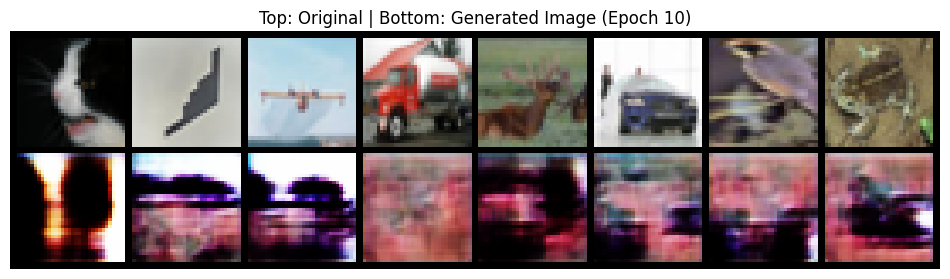

Epoch-11/1000: 100%|██████████| 782/782 [01:12<00:00, 10.72it/s, GenLoss=1.28, DisLoss=0.775, DisSteps=1] 


Generator Loss: 1.9670515372929975
Discriminator Loss: 0.4648807686193825


Epoch-12/1000: 100%|██████████| 782/782 [00:55<00:00, 14.15it/s, GenLoss=1.54, DisLoss=0.802, DisSteps=1] 


Generator Loss: 1.9756374317209433
Discriminator Loss: 0.45536092912678217


Epoch-13/1000: 100%|██████████| 782/782 [00:59<00:00, 13.20it/s, GenLoss=1.69, DisLoss=0.482, DisSteps=1] 


Generator Loss: 1.8246230401498886
Discriminator Loss: 0.48184955968042775


Epoch-14/1000: 100%|██████████| 782/782 [00:54<00:00, 14.26it/s, GenLoss=1.94, DisLoss=0.556, DisSteps=1] 


Generator Loss: 1.9488287595531824
Discriminator Loss: 0.47978676057151515


Epoch-15/1000: 100%|██████████| 782/782 [00:59<00:00, 13.09it/s, GenLoss=1.94, DisLoss=0.291, DisSteps=1] 


Generator Loss: 1.9836161161780053
Discriminator Loss: 0.45347528502611856


Epoch-16/1000: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s, GenLoss=1.35, DisLoss=0.995, DisSteps=1] 


Generator Loss: 1.8274123814252332
Discriminator Loss: 0.4739795992403384


Epoch-17/1000: 100%|██████████| 782/782 [00:49<00:00, 15.76it/s, GenLoss=1.17, DisLoss=0.472, DisSteps=1] 


Generator Loss: 1.651834735480111
Discriminator Loss: 0.5221924432708175


Epoch-18/1000: 100%|██████████| 782/782 [00:24<00:00, 32.07it/s, GenLoss=2.09, DisLoss=0.371, DisSteps=1] 


Generator Loss: 2.0250735273751457
Discriminator Loss: 0.4560200220826642


Epoch-19/1000: 100%|██████████| 782/782 [00:13<00:00, 56.80it/s, GenLoss=2.64, DisLoss=0.62, DisSteps=1]  


Generator Loss: 1.9042340900434558
Discriminator Loss: 0.47492023559330065


Epoch-20/1000: 100%|██████████| 782/782 [00:14<00:00, 54.61it/s, GenLoss=1.13, DisLoss=0.626, DisSteps=1] 


Generator Loss: 1.9225391385043065
Discriminator Loss: 0.46463563973489014


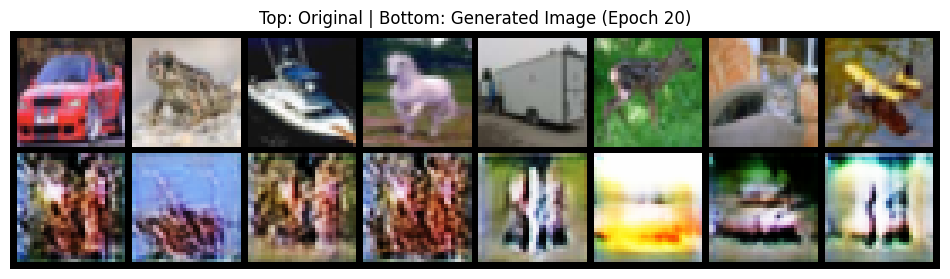

Epoch-21/1000: 100%|██████████| 782/782 [00:20<00:00, 38.41it/s, GenLoss=2.61, DisLoss=0.671, DisSteps=1] 


Generator Loss: 1.8816506407602365
Discriminator Loss: 0.48009949432843174


Epoch-22/1000: 100%|██████████| 782/782 [00:47<00:00, 16.60it/s, GenLoss=1.36, DisLoss=0.611, DisSteps=1]


Generator Loss: 2.041302889204391
Discriminator Loss: 0.44370366800624084


Epoch-23/1000: 100%|██████████| 782/782 [00:54<00:00, 14.42it/s, GenLoss=1.07, DisLoss=0.84, DisSteps=1]  


Generator Loss: 1.9092237564456431
Discriminator Loss: 0.4701352205194171


Epoch-24/1000: 100%|██████████| 782/782 [00:57<00:00, 13.57it/s, GenLoss=3.19, DisLoss=0.363, DisSteps=1] 


Generator Loss: 1.941806337412666
Discriminator Loss: 0.4699510984179919


Epoch-25/1000: 100%|██████████| 782/782 [00:56<00:00, 13.75it/s, GenLoss=1.78, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.997112461139479
Discriminator Loss: 0.46007884745402716


Epoch-26/1000: 100%|██████████| 782/782 [01:10<00:00, 11.10it/s, GenLoss=1.48, DisLoss=0.438, DisSteps=1] 


Generator Loss: 1.9095691731366355
Discriminator Loss: 0.4654300433519246


Epoch-27/1000: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s, GenLoss=3.32, DisLoss=0.367, DisSteps=1] 


Generator Loss: 2.021368525674581
Discriminator Loss: 0.4510602282593622


Epoch-28/1000: 100%|██████████| 782/782 [00:39<00:00, 19.59it/s, GenLoss=1.68, DisLoss=0.642, DisSteps=1] 


Generator Loss: 2.0214942232574646
Discriminator Loss: 0.450546946119317


Epoch-29/1000: 100%|██████████| 782/782 [00:13<00:00, 57.81it/s, GenLoss=2.05, DisLoss=0.489, DisSteps=1] 


Generator Loss: 1.970896178575428
Discriminator Loss: 0.4635555645655793


Epoch-30/1000: 100%|██████████| 782/782 [00:13<00:00, 57.64it/s, GenLoss=2.19, DisLoss=1.07, DisSteps=1]  


Generator Loss: 1.9980169966855013
Discriminator Loss: 0.4401237648885573


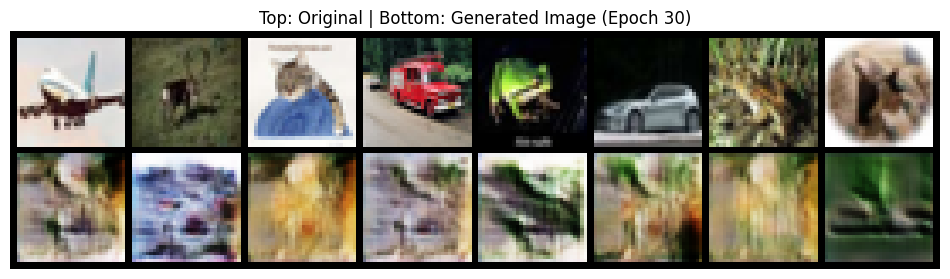

Epoch-31/1000: 100%|██████████| 782/782 [00:13<00:00, 56.35it/s, GenLoss=2.01, DisLoss=0.798, DisSteps=1] 


Generator Loss: 1.9646580886962774
Discriminator Loss: 0.46970706976130794


Epoch-32/1000: 100%|██████████| 782/782 [00:13<00:00, 57.30it/s, GenLoss=2.17, DisLoss=0.421, DisSteps=1] 


Generator Loss: 1.960085971885935
Discriminator Loss: 0.4779631927647554


Epoch-33/1000: 100%|██████████| 782/782 [00:13<00:00, 57.44it/s, GenLoss=4.33, DisLoss=0.728, DisSteps=1]


Generator Loss: 1.9423435742745314
Discriminator Loss: 0.45555099515277714


Epoch-34/1000: 100%|██████████| 782/782 [00:13<00:00, 57.28it/s, GenLoss=3.91, DisLoss=0.286, DisSteps=1] 


Generator Loss: 2.1664165083099816
Discriminator Loss: 0.42099956080050727


Epoch-35/1000: 100%|██████████| 782/782 [00:13<00:00, 57.49it/s, GenLoss=2.56, DisLoss=0.513, DisSteps=1] 


Generator Loss: 2.057131527939721
Discriminator Loss: 0.4441720385799932


Epoch-36/1000: 100%|██████████| 782/782 [00:30<00:00, 25.57it/s, GenLoss=2.13, DisLoss=0.646, DisSteps=1] 


Generator Loss: 1.7719674303251154
Discriminator Loss: 0.4981797141644656


Epoch-37/1000: 100%|██████████| 782/782 [00:54<00:00, 14.37it/s, GenLoss=3.19, DisLoss=0.452, DisSteps=1] 


Generator Loss: 1.8235112895136294
Discriminator Loss: 0.504791902459186


Epoch-38/1000: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s, GenLoss=1.46, DisLoss=0.604, DisSteps=1] 


Generator Loss: 1.8629400021279865
Discriminator Loss: 0.4798280849404957


Epoch-39/1000: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s, GenLoss=1.7, DisLoss=0.597, DisSteps=1]  


Generator Loss: 2.002879901081705
Discriminator Loss: 0.459297743104303


Epoch-40/1000: 100%|██████████| 782/782 [00:54<00:00, 14.22it/s, GenLoss=1.33, DisLoss=0.545, DisSteps=1] 


Generator Loss: 1.7779451945553655
Discriminator Loss: 0.5128442394306593


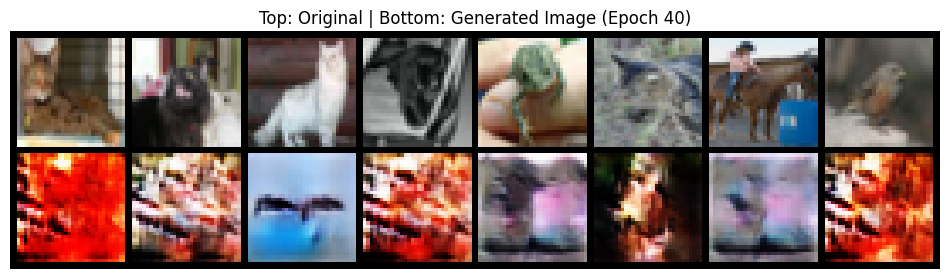

Epoch-41/1000: 100%|██████████| 782/782 [00:58<00:00, 13.46it/s, GenLoss=1.93, DisLoss=0.356, DisSteps=1] 


Generator Loss: 1.721966896215668
Discriminator Loss: 0.5123710574396431


Epoch-42/1000: 100%|██████████| 782/782 [00:43<00:00, 17.85it/s, GenLoss=1.46, DisLoss=0.279, DisSteps=1] 


Generator Loss: 1.8285230344061352
Discriminator Loss: 0.485040742875365


Epoch-43/1000: 100%|██████████| 782/782 [00:48<00:00, 16.09it/s, GenLoss=2.64, DisLoss=0.634, DisSteps=1] 


Generator Loss: 1.758688414569401
Discriminator Loss: 0.5061113331324


Epoch-44/1000: 100%|██████████| 782/782 [00:51<00:00, 15.30it/s, GenLoss=1.21, DisLoss=0.727, DisSteps=1] 


Generator Loss: 1.7153875256895714
Discriminator Loss: 0.5058002726501211


Epoch-45/1000: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, GenLoss=2.94, DisLoss=0.724, DisSteps=1] 


Generator Loss: 1.7147466742321658
Discriminator Loss: 0.5185073643084377


Epoch-46/1000: 100%|██████████| 782/782 [00:48<00:00, 16.21it/s, GenLoss=3.29, DisLoss=0.946, DisSteps=1] 


Generator Loss: 1.6837422533718216
Discriminator Loss: 0.5332194087679124


Epoch-47/1000: 100%|██████████| 782/782 [00:32<00:00, 24.20it/s, GenLoss=1.19, DisLoss=0.72, DisSteps=1]  


Generator Loss: 1.7151253537448776
Discriminator Loss: 0.531778909170719


Epoch-48/1000: 100%|██████████| 782/782 [00:14<00:00, 55.05it/s, GenLoss=2.67, DisLoss=0.54, DisSteps=1]  


Generator Loss: 1.7561088973451453
Discriminator Loss: 0.5092243825840523


Epoch-49/1000: 100%|██████████| 782/782 [00:52<00:00, 15.03it/s, GenLoss=1.46, DisLoss=0.418, DisSteps=1] 


Generator Loss: 1.8052745458415098
Discriminator Loss: 0.4980640850027504


Epoch-50/1000: 100%|██████████| 782/782 [00:59<00:00, 13.24it/s, GenLoss=1.46, DisLoss=0.462, DisSteps=1] 


Generator Loss: 1.8103828644356155
Discriminator Loss: 0.4898862967939328


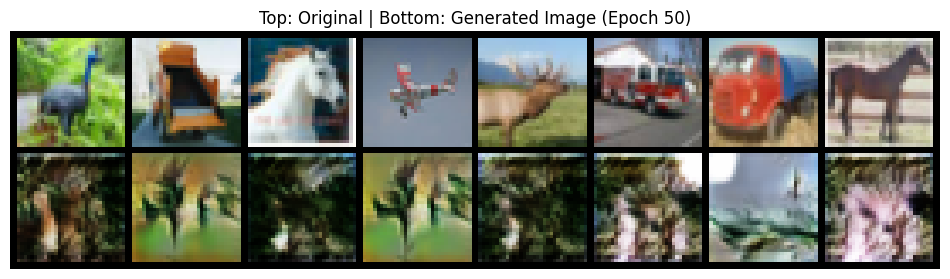

Epoch-51/1000: 100%|██████████| 782/782 [00:56<00:00, 13.73it/s, GenLoss=1.3, DisLoss=0.489, DisSteps=1]  


Generator Loss: 1.7967439335020607
Discriminator Loss: 0.48190498317751435


Epoch-52/1000: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s, GenLoss=1.82, DisLoss=0.42, DisSteps=1]  


Generator Loss: 1.7970246206921385
Discriminator Loss: 0.4973896247194246


Epoch-53/1000: 100%|██████████| 782/782 [00:47<00:00, 16.62it/s, GenLoss=1.29, DisLoss=0.598, DisSteps=1] 


Generator Loss: 1.740128952600157
Discriminator Loss: 0.49767187466401885


Epoch-54/1000: 100%|██████████| 782/782 [00:29<00:00, 26.67it/s, GenLoss=1.37, DisLoss=1.18, DisSteps=1]  


Generator Loss: 1.7920604313121122
Discriminator Loss: 0.49139298174692236


Epoch-55/1000: 100%|██████████| 782/782 [00:14<00:00, 55.06it/s, GenLoss=2.97, DisLoss=0.665, DisSteps=1] 


Generator Loss: 1.7142410776804171
Discriminator Loss: 0.5045528789729719


Epoch-56/1000: 100%|██████████| 782/782 [00:14<00:00, 54.05it/s, GenLoss=1.64, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.666078765907556
Discriminator Loss: 0.530066141691964


Epoch-57/1000: 100%|██████████| 782/782 [01:13<00:00, 10.64it/s, GenLoss=3.57, DisLoss=0.59, DisSteps=1]  


Generator Loss: 1.8396762953999708
Discriminator Loss: 0.4771624200636774


Epoch-58/1000: 100%|██████████| 782/782 [00:55<00:00, 13.99it/s, GenLoss=1.35, DisLoss=0.908, DisSteps=1] 


Generator Loss: 1.8037851626610817
Discriminator Loss: 0.49556287303757485


Epoch-59/1000: 100%|██████████| 782/782 [01:25<00:00,  9.10it/s, GenLoss=3.14, DisLoss=0.495, DisSteps=1] 


Generator Loss: 1.7001538166152241
Discriminator Loss: 0.5131809015941742


Epoch-60/1000: 100%|██████████| 782/782 [00:55<00:00, 14.17it/s, GenLoss=1.73, DisLoss=0.405, DisSteps=1] 


Generator Loss: 1.7001772793510077
Discriminator Loss: 0.5244088817359237


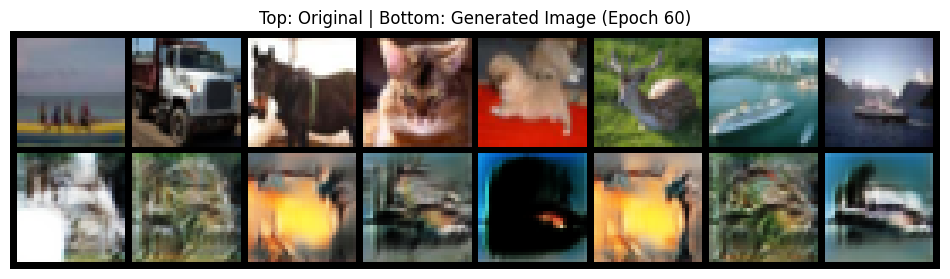

Epoch-61/1000: 100%|██████████| 782/782 [01:03<00:00, 12.27it/s, GenLoss=1.65, DisLoss=0.843, DisSteps=1] 


Generator Loss: 1.8792838319335752
Discriminator Loss: 0.4633687235548368


Epoch-62/1000: 100%|██████████| 782/782 [00:52<00:00, 14.97it/s, GenLoss=1.64, DisLoss=0.603, DisSteps=1] 


Generator Loss: 1.9061312078667418
Discriminator Loss: 0.4645223418236389


Epoch-63/1000: 100%|██████████| 782/782 [01:39<00:00,  7.85it/s, GenLoss=2.07, DisLoss=0.295, DisSteps=1] 


Generator Loss: 1.7277464808710397
Discriminator Loss: 0.5096529339585463


Epoch-64/1000: 100%|██████████| 782/782 [01:20<00:00,  9.71it/s, GenLoss=2.31, DisLoss=0.442, DisSteps=1] 


Generator Loss: 1.8026427490936825
Discriminator Loss: 0.4898931090255528


Epoch-65/1000: 100%|██████████| 782/782 [01:56<00:00,  6.72it/s, GenLoss=1.42, DisLoss=0.604, DisSteps=1] 


Generator Loss: 1.8497482724201955
Discriminator Loss: 0.47198275865420053


Epoch-66/1000: 100%|██████████| 782/782 [00:57<00:00, 13.68it/s, GenLoss=1.85, DisLoss=0.79, DisSteps=1]  


Generator Loss: 1.7098800389053266
Discriminator Loss: 0.5028635245531111


Epoch-67/1000: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s, GenLoss=3.38, DisLoss=0.373, DisSteps=1] 


Generator Loss: 1.7081919231683091
Discriminator Loss: 0.49413889234937974


Epoch-68/1000: 100%|██████████| 782/782 [01:05<00:00, 11.94it/s, GenLoss=0.834, DisLoss=1.95, DisSteps=1] 


Generator Loss: 1.7332790551130728
Discriminator Loss: 0.49869088115899457


Epoch-69/1000: 100%|██████████| 782/782 [00:53<00:00, 14.68it/s, GenLoss=2.21, DisLoss=0.76, DisSteps=1]  


Generator Loss: 1.6433476750045786
Discriminator Loss: 0.5330289383907147


Epoch-70/1000: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s, GenLoss=1.17, DisLoss=0.755, DisSteps=1] 


Generator Loss: 1.796342684027484
Discriminator Loss: 0.5044559855061723


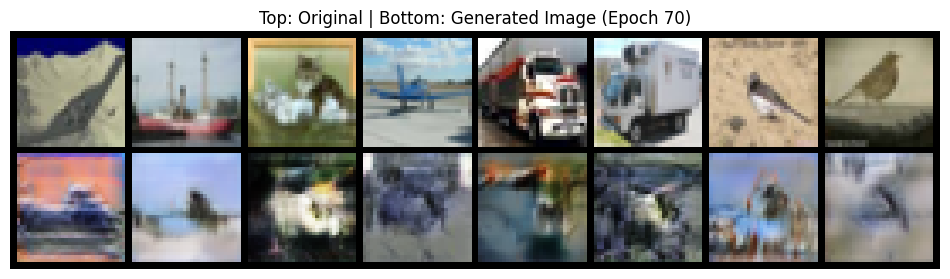

Epoch-71/1000: 100%|██████████| 782/782 [01:05<00:00, 11.93it/s, GenLoss=4.53, DisLoss=0.607, DisSteps=1] 


Generator Loss: 1.599881725009445
Discriminator Loss: 0.5258173694848405


Epoch-72/1000: 100%|██████████| 782/782 [00:56<00:00, 13.93it/s, GenLoss=1.87, DisLoss=0.404, DisSteps=1] 


Generator Loss: 1.5678581965853795
Discriminator Loss: 0.5494423225865035


Epoch-73/1000: 100%|██████████| 782/782 [01:07<00:00, 11.60it/s, GenLoss=0.937, DisLoss=0.583, DisSteps=1]


Generator Loss: 1.704230079794174
Discriminator Loss: 0.512093910475826


Epoch-74/1000: 100%|██████████| 782/782 [01:20<00:00,  9.76it/s, GenLoss=1.97, DisLoss=0.405, DisSteps=1] 


Generator Loss: 1.7389829475861376
Discriminator Loss: 0.5148401232555394


Epoch-75/1000: 100%|██████████| 782/782 [01:13<00:00, 10.63it/s, GenLoss=1.89, DisLoss=0.388, DisSteps=1] 


Generator Loss: 1.888764194210472
Discriminator Loss: 0.4672731179791643


Epoch-76/1000: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s, GenLoss=1.97, DisLoss=0.477, DisSteps=1] 


Generator Loss: 1.8731135209198193
Discriminator Loss: 0.4697364800421478


Epoch-77/1000: 100%|██████████| 782/782 [01:28<00:00,  8.83it/s, GenLoss=2.72, DisLoss=0.888, DisSteps=1] 


Generator Loss: 1.7972761143351454
Discriminator Loss: 0.48117545559583114


Epoch-78/1000: 100%|██████████| 782/782 [01:20<00:00,  9.77it/s, GenLoss=2.34, DisLoss=1.16, DisSteps=1]  


Generator Loss: 1.6848192861317979
Discriminator Loss: 0.5209608991890002


Epoch-79/1000: 100%|██████████| 782/782 [00:36<00:00, 21.27it/s, GenLoss=1.34, DisLoss=0.368, DisSteps=1] 


Generator Loss: 1.5767398412575198
Discriminator Loss: 0.530993561381879


Epoch-80/1000: 100%|██████████| 782/782 [00:49<00:00, 15.83it/s, GenLoss=1.29, DisLoss=0.455, DisSteps=1] 


Generator Loss: 1.6375699424377792
Discriminator Loss: 0.5201688953067946


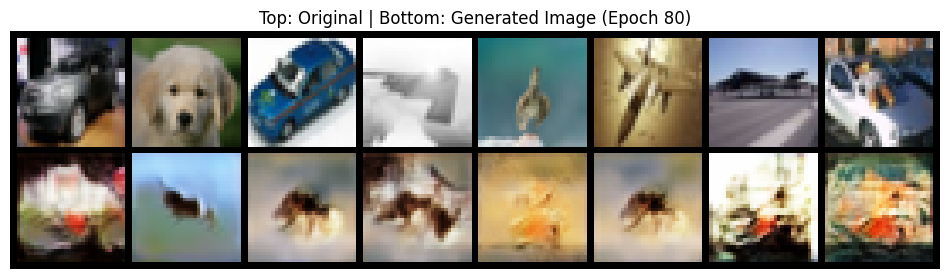

Epoch-81/1000: 100%|██████████| 782/782 [00:27<00:00, 28.63it/s, GenLoss=1.16, DisLoss=0.461, DisSteps=1] 


Generator Loss: 1.6684481720332904
Discriminator Loss: 0.49903627715604687


Epoch-82/1000: 100%|██████████| 782/782 [01:00<00:00, 12.99it/s, GenLoss=1.24, DisLoss=0.879, DisSteps=1] 


Generator Loss: 1.621872660372873
Discriminator Loss: 0.5290095978761877


Epoch-83/1000: 100%|██████████| 782/782 [00:49<00:00, 15.69it/s, GenLoss=1.62, DisLoss=0.403, DisSteps=1] 


Generator Loss: 1.571866982809418
Discriminator Loss: 0.5421574356229714


Epoch-84/1000: 100%|██████████| 782/782 [00:45<00:00, 17.29it/s, GenLoss=1.74, DisLoss=0.796, DisSteps=1] 


Generator Loss: 1.7375197476133362
Discriminator Loss: 0.49822495633836295


Epoch-85/1000: 100%|██████████| 782/782 [00:59<00:00, 13.24it/s, GenLoss=1.95, DisLoss=0.593, DisSteps=1] 


Generator Loss: 1.5830272525320273
Discriminator Loss: 0.5336766877899999


Epoch-86/1000: 100%|██████████| 782/782 [00:42<00:00, 18.32it/s, GenLoss=1.49, DisLoss=0.419, DisSteps=1] 


Generator Loss: 1.5858774275121177
Discriminator Loss: 0.5352356543626322


Epoch-87/1000: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s, GenLoss=3.87, DisLoss=2.14, DisSteps=1]  


Generator Loss: 1.6847975332566234
Discriminator Loss: 0.5229617545138234


Epoch-88/1000: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s, GenLoss=2.6, DisLoss=1.35, DisSteps=1]   


Generator Loss: 1.586769679242083
Discriminator Loss: 0.5348986870873614


Epoch-89/1000: 100%|██████████| 782/782 [00:31<00:00, 25.09it/s, GenLoss=1.77, DisLoss=0.966, DisSteps=1] 


Generator Loss: 1.5641112007448434
Discriminator Loss: 0.5651545691901766


Epoch-90/1000: 100%|██████████| 782/782 [00:19<00:00, 40.49it/s, GenLoss=1.33, DisLoss=0.613, DisSteps=1] 


Generator Loss: 1.5089516369887934
Discriminator Loss: 0.5571408527510245


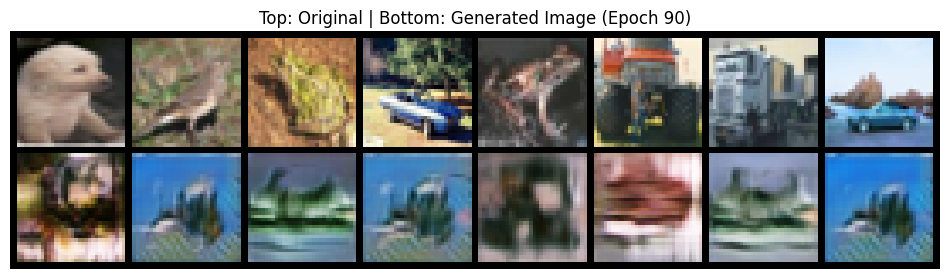

Epoch-91/1000: 100%|██████████| 782/782 [01:06<00:00, 11.76it/s, GenLoss=2.05, DisLoss=0.764, DisSteps=1] 


Generator Loss: 1.6711928088341832
Discriminator Loss: 0.517057781596013


Epoch-92/1000: 100%|██████████| 782/782 [00:46<00:00, 16.89it/s, GenLoss=1.55, DisLoss=0.72, DisSteps=1]  


Generator Loss: 1.6469946573762333
Discriminator Loss: 0.5298449270179509


Epoch-93/1000: 100%|██████████| 782/782 [01:04<00:00, 12.14it/s, GenLoss=2.15, DisLoss=0.381, DisSteps=1] 


Generator Loss: 1.5953848828440127
Discriminator Loss: 0.5302475730857581


Epoch-94/1000: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s, GenLoss=4.31, DisLoss=0.697, DisSteps=1] 


Generator Loss: 1.5665375289252348
Discriminator Loss: 0.5550180045540071


Epoch-95/1000: 100%|██████████| 782/782 [00:14<00:00, 55.56it/s, GenLoss=1.09, DisLoss=0.774, DisSteps=1] 


Generator Loss: 1.5779119276482125
Discriminator Loss: 0.5498669014486206


Epoch-96/1000: 100%|██████████| 782/782 [00:14<00:00, 55.78it/s, GenLoss=2.51, DisLoss=0.385, DisSteps=1] 


Generator Loss: 1.5039252512290349
Discriminator Loss: 0.5447691080667784


Epoch-97/1000: 100%|██████████| 782/782 [00:13<00:00, 55.92it/s, GenLoss=2.96, DisLoss=0.727, DisSteps=1] 


Generator Loss: 1.5079129800543456
Discriminator Loss: 0.5665561068622048


Epoch-98/1000: 100%|██████████| 782/782 [00:17<00:00, 45.86it/s, GenLoss=1.67, DisLoss=0.949, DisSteps=1] 


Generator Loss: 1.5920949082087983
Discriminator Loss: 0.5496376046286825


Epoch-99/1000: 100%|██████████| 782/782 [01:06<00:00, 11.69it/s, GenLoss=1.38, DisLoss=0.718, DisSteps=1] 


Generator Loss: 1.5115367092592331
Discriminator Loss: 0.5620043132539905


Epoch-100/1000: 100%|██████████| 782/782 [00:50<00:00, 15.55it/s, GenLoss=2.11, DisLoss=0.872, DisSteps=1] 


Generator Loss: 1.5902810262139802
Discriminator Loss: 0.5313708565347944


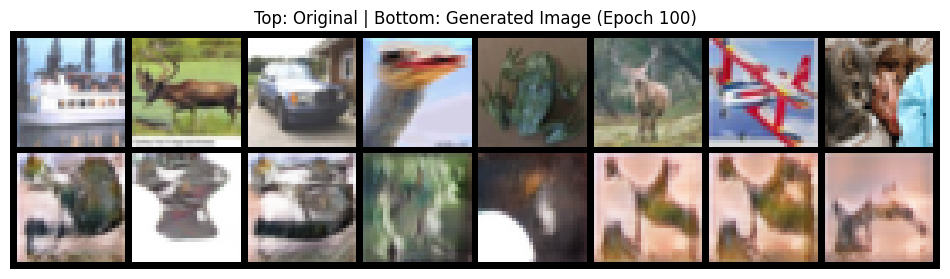

Epoch-101/1000: 100%|██████████| 782/782 [01:22<00:00,  9.45it/s, GenLoss=1.91, DisLoss=0.705, DisSteps=1] 


Generator Loss: 1.5775862941351693
Discriminator Loss: 0.5413679722172525


Epoch-102/1000: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s, GenLoss=1.58, DisLoss=0.795, DisSteps=1] 


Generator Loss: 1.5641770868959939
Discriminator Loss: 0.5468793515201724


Epoch-103/1000: 100%|██████████| 782/782 [00:36<00:00, 21.42it/s, GenLoss=2.02, DisLoss=0.5, DisSteps=1]   


Generator Loss: 1.5029234892267096
Discriminator Loss: 0.553841730670246


Epoch-104/1000: 100%|██████████| 782/782 [00:59<00:00, 13.20it/s, GenLoss=1.87, DisLoss=0.741, DisSteps=1] 


Generator Loss: 1.4765421401356797
Discriminator Loss: 0.5681522676287709


Epoch-105/1000: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s, GenLoss=3.61, DisLoss=0.588, DisSteps=1] 


Generator Loss: 1.5640174251840548
Discriminator Loss: 0.5388419966563545


Epoch-106/1000: 100%|██████████| 782/782 [00:49<00:00, 15.94it/s, GenLoss=1.64, DisLoss=0.687, DisSteps=1] 


Generator Loss: 1.5782577447269275
Discriminator Loss: 0.5275619992095492


Epoch-107/1000: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s, GenLoss=2.3, DisLoss=0.487, DisSteps=1]  


Generator Loss: 1.4564650450521113
Discriminator Loss: 0.5611769270409098


Epoch-108/1000: 100%|██████████| 782/782 [00:48<00:00, 16.17it/s, GenLoss=4.31, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.6700798409521733
Discriminator Loss: 0.5077946192163336


Epoch-109/1000: 100%|██████████| 782/782 [00:21<00:00, 35.83it/s, GenLoss=3.41, DisLoss=0.398, DisSteps=1] 


Generator Loss: 1.650043135485076
Discriminator Loss: 0.5174936469634781


Epoch-110/1000: 100%|██████████| 782/782 [00:14<00:00, 53.91it/s, GenLoss=2.07, DisLoss=2.3, DisSteps=1]   


Generator Loss: 1.5672159470865488
Discriminator Loss: 0.5420196468720351


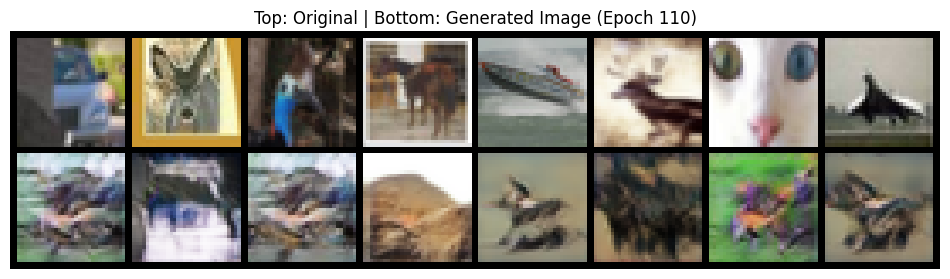

Epoch-111/1000: 100%|██████████| 782/782 [00:14<00:00, 53.55it/s, GenLoss=3.43, DisLoss=0.883, DisSteps=1] 


Generator Loss: 1.5351377810968463
Discriminator Loss: 0.5425850477669855


Epoch-112/1000: 100%|██████████| 782/782 [00:14<00:00, 55.27it/s, GenLoss=3.25, DisLoss=1.45, DisSteps=1]  


Generator Loss: 1.4913726184526672
Discriminator Loss: 0.5636127410108781


Epoch-113/1000: 100%|██████████| 782/782 [00:41<00:00, 18.93it/s, GenLoss=1.94, DisLoss=0.728, DisSteps=1] 


Generator Loss: 1.4629194932749203
Discriminator Loss: 0.5690299360572225


Epoch-114/1000: 100%|██████████| 782/782 [00:46<00:00, 16.69it/s, GenLoss=2.73, DisLoss=0.725, DisSteps=1] 


Generator Loss: 1.6018334550930715
Discriminator Loss: 0.5276286653469285


Epoch-115/1000: 100%|██████████| 782/782 [00:45<00:00, 17.03it/s, GenLoss=3.89, DisLoss=0.85, DisSteps=1]  


Generator Loss: 1.9013514538555194
Discriminator Loss: 0.44772741053720266


Epoch-116/1000: 100%|██████████| 782/782 [00:27<00:00, 28.31it/s, GenLoss=1.01, DisLoss=0.532, DisSteps=1] 


Generator Loss: 1.6008396376962857
Discriminator Loss: 0.5445835514141776


Epoch-117/1000: 100%|██████████| 782/782 [00:31<00:00, 24.65it/s, GenLoss=1.15, DisLoss=0.57, DisSteps=1]  


Generator Loss: 1.6091542622012556
Discriminator Loss: 0.5264146355411891


Epoch-118/1000: 100%|██████████| 782/782 [00:17<00:00, 45.06it/s, GenLoss=3.11, DisLoss=1.38, DisSteps=1]  


Generator Loss: 1.6382400637011394
Discriminator Loss: 0.5263019303988923


Epoch-119/1000: 100%|██████████| 782/782 [00:14<00:00, 55.20it/s, GenLoss=1.89, DisLoss=1.61, DisSteps=1]  


Generator Loss: 1.5986441964536067
Discriminator Loss: 0.5262761618703833


Epoch-120/1000: 100%|██████████| 782/782 [00:18<00:00, 41.87it/s, GenLoss=2.32, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.474369377012143
Discriminator Loss: 0.5578170163780832


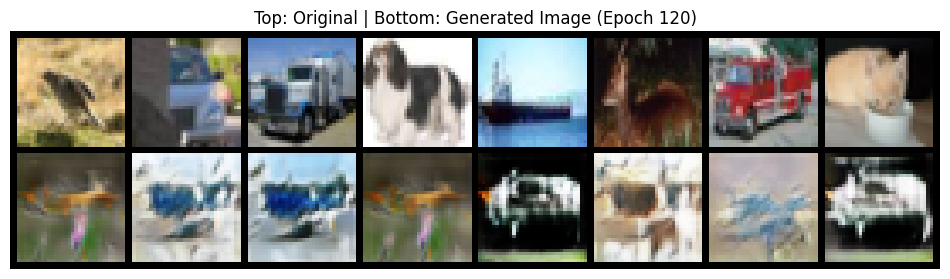

Epoch-121/1000: 100%|██████████| 782/782 [00:22<00:00, 34.50it/s, GenLoss=1.27, DisLoss=1, DisSteps=1]     


Generator Loss: 1.5535479844226252
Discriminator Loss: 0.5340881699796223


Epoch-122/1000: 100%|██████████| 782/782 [00:14<00:00, 53.51it/s, GenLoss=2.62, DisLoss=0.256, DisSteps=1] 


Generator Loss: 1.6031769862412797
Discriminator Loss: 0.5279676931745866


Epoch-123/1000: 100%|██████████| 782/782 [00:13<00:00, 56.08it/s, GenLoss=1.74, DisLoss=1.29, DisSteps=1]  


Generator Loss: 1.609665453586432
Discriminator Loss: 0.5205297274205386


Epoch-124/1000: 100%|██████████| 782/782 [00:14<00:00, 55.32it/s, GenLoss=2.77, DisLoss=0.765, DisSteps=1] 


Generator Loss: 1.6046994632619727
Discriminator Loss: 0.5323211852546847


Epoch-125/1000: 100%|██████████| 782/782 [00:40<00:00, 19.36it/s, GenLoss=1.07, DisLoss=1.75, DisSteps=1]  


Generator Loss: 1.618291717508565
Discriminator Loss: 0.5093722639181425


Epoch-126/1000: 100%|██████████| 782/782 [00:24<00:00, 31.97it/s, GenLoss=2.42, DisLoss=0.642, DisSteps=1] 


Generator Loss: 1.592994062110896
Discriminator Loss: 0.5269983790795821


Epoch-127/1000: 100%|██████████| 782/782 [00:16<00:00, 46.52it/s, GenLoss=0.749, DisLoss=0.451, DisSteps=1]


Generator Loss: 1.547316304710515
Discriminator Loss: 0.5447694944298785


Epoch-128/1000: 100%|██████████| 782/782 [00:15<00:00, 50.83it/s, GenLoss=2.34, DisLoss=0.379, DisSteps=1] 


Generator Loss: 1.564920957512258
Discriminator Loss: 0.5279690872144212


Epoch-129/1000: 100%|██████████| 782/782 [00:17<00:00, 45.69it/s, GenLoss=2.43, DisLoss=0.655, DisSteps=1] 


Generator Loss: 1.5612980157822904
Discriminator Loss: 0.5400913377552081


Epoch-130/1000: 100%|██████████| 782/782 [00:16<00:00, 46.05it/s, GenLoss=2.76, DisLoss=0.318, DisSteps=1] 


Generator Loss: 1.564145986076511
Discriminator Loss: 0.5325221322152925


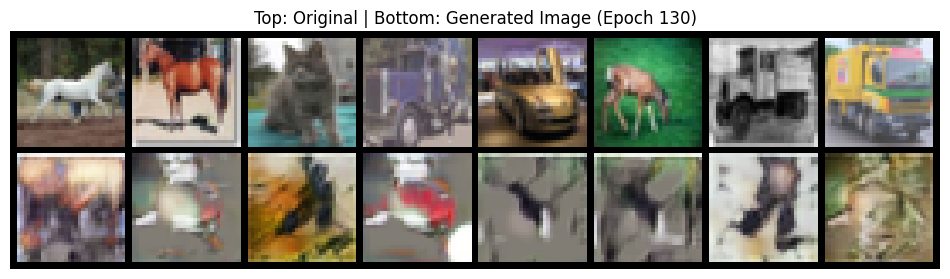

Epoch-131/1000: 100%|██████████| 782/782 [00:22<00:00, 35.10it/s, GenLoss=2.13, DisLoss=0.628, DisSteps=1] 


Generator Loss: 1.5912262553068073
Discriminator Loss: 0.5234339023794969


Epoch-132/1000: 100%|██████████| 782/782 [00:16<00:00, 48.04it/s, GenLoss=4.14, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.5489939222555331
Discriminator Loss: 0.5263098112457548


Epoch-133/1000: 100%|██████████| 782/782 [00:19<00:00, 40.37it/s, GenLoss=1.59, DisLoss=0.584, DisSteps=1] 


Generator Loss: 1.5556870092973685
Discriminator Loss: 0.5382408482568038


Epoch-134/1000: 100%|██████████| 782/782 [00:14<00:00, 54.86it/s, GenLoss=3.13, DisLoss=0.527, DisSteps=1] 


Generator Loss: 1.6124048403004552
Discriminator Loss: 0.5178194427124375


Epoch-135/1000: 100%|██████████| 782/782 [00:14<00:00, 55.35it/s, GenLoss=2.19, DisLoss=0.573, DisSteps=1] 


Generator Loss: 1.5030120472087884
Discriminator Loss: 0.565630494443047


Epoch-136/1000: 100%|██████████| 782/782 [00:13<00:00, 56.91it/s, GenLoss=2.01, DisLoss=0.263, DisSteps=1] 


Generator Loss: 1.5859233005272457
Discriminator Loss: 0.5188274966633838


Epoch-137/1000: 100%|██████████| 782/782 [00:13<00:00, 56.09it/s, GenLoss=2.58, DisLoss=0.85, DisSteps=1]  


Generator Loss: 1.7015201989799509
Discriminator Loss: 0.5140717970326428


Epoch-138/1000: 100%|██████████| 782/782 [00:14<00:00, 52.13it/s, GenLoss=3.06, DisLoss=0.305, DisSteps=1] 


Generator Loss: 1.6240303571266896
Discriminator Loss: 0.5194710161146301


Epoch-139/1000: 100%|██████████| 782/782 [00:14<00:00, 55.16it/s, GenLoss=0.287, DisLoss=0.616, DisSteps=1]


Generator Loss: 1.8399936695537908
Discriminator Loss: 0.46118274994213565


Epoch-140/1000: 100%|██████████| 782/782 [00:14<00:00, 55.66it/s, GenLoss=3.12, DisLoss=0.325, DisSteps=1] 


Generator Loss: 1.8280490790791524
Discriminator Loss: 0.46800068514350124


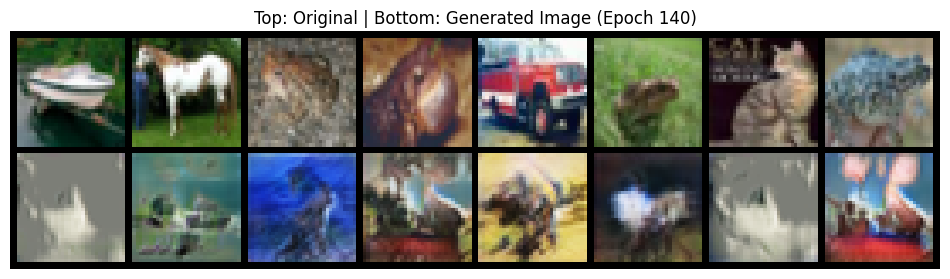

Epoch-141/1000: 100%|██████████| 782/782 [00:13<00:00, 56.69it/s, GenLoss=4.05, DisLoss=0.33, DisSteps=1]  


Generator Loss: 1.7019443111041623
Discriminator Loss: 0.5086280176287417


Epoch-142/1000: 100%|██████████| 782/782 [00:14<00:00, 53.17it/s, GenLoss=5.35, DisLoss=1.41, DisSteps=1]  


Generator Loss: 1.7098949314916836
Discriminator Loss: 0.49515467318122647


Epoch-143/1000: 100%|██████████| 782/782 [00:14<00:00, 55.65it/s, GenLoss=5.07, DisLoss=1.09, DisSteps=1]  


Generator Loss: 1.6798337426636836
Discriminator Loss: 0.48980188828981136


Epoch-144/1000: 100%|██████████| 782/782 [00:14<00:00, 54.81it/s, GenLoss=1.98, DisLoss=0.38, DisSteps=1]  


Generator Loss: 1.6984102096017974
Discriminator Loss: 0.5003656876247252


Epoch-145/1000: 100%|██████████| 782/782 [00:29<00:00, 26.83it/s, GenLoss=3.1, DisLoss=0.446, DisSteps=1]  


Generator Loss: 1.8310541042586421
Discriminator Loss: 0.4677237664799556


Epoch-146/1000: 100%|██████████| 782/782 [00:14<00:00, 54.58it/s, GenLoss=5.52, DisLoss=0.958, DisSteps=1] 


Generator Loss: 1.7054986390463835
Discriminator Loss: 0.505432617557628


Epoch-147/1000: 100%|██████████| 782/782 [00:21<00:00, 36.48it/s, GenLoss=2.2, DisLoss=0.635, DisSteps=1]  


Generator Loss: 1.6792953451881019
Discriminator Loss: 0.4953971116058052


Epoch-148/1000: 100%|██████████| 782/782 [00:39<00:00, 19.71it/s, GenLoss=4.04, DisLoss=0.605, DisSteps=1] 


Generator Loss: 1.6354679109342873
Discriminator Loss: 0.5165299254914989


Epoch-149/1000: 100%|██████████| 782/782 [00:26<00:00, 29.80it/s, GenLoss=1.68, DisLoss=0.258, DisSteps=1] 


Generator Loss: 1.7089650545583661
Discriminator Loss: 0.5013618933232239


Epoch-150/1000: 100%|██████████| 782/782 [00:14<00:00, 55.54it/s, GenLoss=1.84, DisLoss=0.309, DisSteps=1] 


Generator Loss: 1.7124370060994496
Discriminator Loss: 0.506243203340284


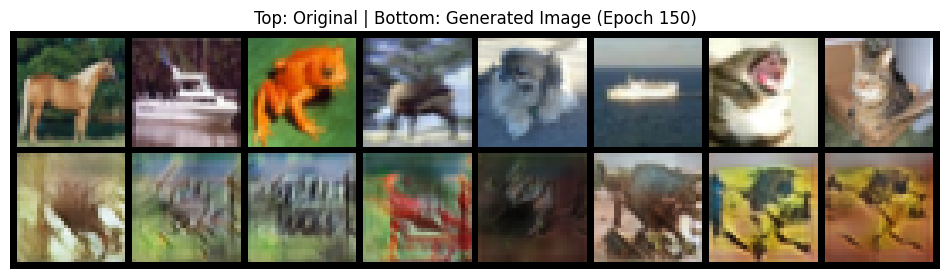

Epoch-151/1000: 100%|██████████| 782/782 [00:15<00:00, 50.17it/s, GenLoss=2.52, DisLoss=1.37, DisSteps=1]  


Generator Loss: 1.5992785843894304
Discriminator Loss: 0.5259729475545152


Epoch-152/1000: 100%|██████████| 782/782 [00:22<00:00, 35.33it/s, GenLoss=3.83, DisLoss=0.44, DisSteps=1]  


Generator Loss: 1.6868740468073988
Discriminator Loss: 0.5159376067349978


Epoch-153/1000: 100%|██████████| 782/782 [00:18<00:00, 42.65it/s, GenLoss=2.41, DisLoss=1.03, DisSteps=1]  


Generator Loss: 1.62268246272031
Discriminator Loss: 0.49610869742720326


Epoch-154/1000: 100%|██████████| 782/782 [00:13<00:00, 57.17it/s, GenLoss=2.4, DisLoss=0.537, DisSteps=1]  


Generator Loss: 1.6462522543909606
Discriminator Loss: 0.5152832214789622


Epoch-155/1000: 100%|██████████| 782/782 [00:14<00:00, 52.27it/s, GenLoss=2.86, DisLoss=0.428, DisSteps=1] 


Generator Loss: 1.6852627665642888
Discriminator Loss: 0.5240022714256936


Epoch-156/1000: 100%|██████████| 782/782 [00:14<00:00, 52.56it/s, GenLoss=2.31, DisLoss=0.583, DisSteps=1] 


Generator Loss: 1.720172351240502
Discriminator Loss: 0.4978201381881219


Epoch-157/1000: 100%|██████████| 782/782 [00:18<00:00, 43.28it/s, GenLoss=1.68, DisLoss=0.267, DisSteps=1] 


Generator Loss: 1.5760560198055813
Discriminator Loss: 0.5339283882580754


Epoch-158/1000: 100%|██████████| 782/782 [00:14<00:00, 55.58it/s, GenLoss=4.31, DisLoss=0.688, DisSteps=1] 


Generator Loss: 1.7182890009849578
Discriminator Loss: 0.5123805919152391


Epoch-159/1000: 100%|██████████| 782/782 [00:30<00:00, 25.54it/s, GenLoss=3.89, DisLoss=1.64, DisSteps=1]  


Generator Loss: 1.682995428971927
Discriminator Loss: 0.4984421473177498


Epoch-160/1000: 100%|██████████| 782/782 [00:23<00:00, 33.77it/s, GenLoss=8.12, DisLoss=0.371, DisSteps=1] 


Generator Loss: 1.6822069073119736
Discriminator Loss: 0.5165294449766884


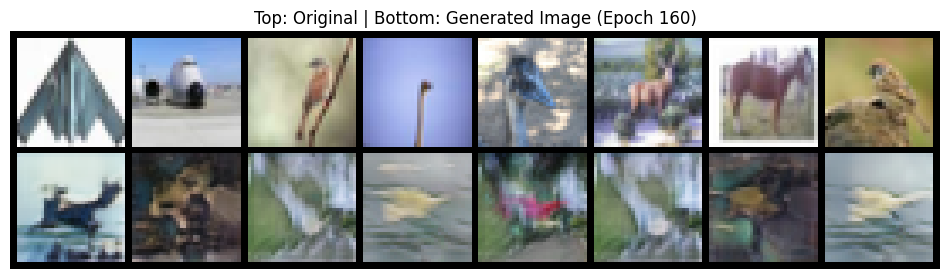

Epoch-161/1000: 100%|██████████| 782/782 [00:25<00:00, 31.01it/s, GenLoss=3.22, DisLoss=0.688, DisSteps=1] 


Generator Loss: 1.6027770790907427
Discriminator Loss: 0.5265092983117798


Epoch-162/1000: 100%|██████████| 782/782 [00:17<00:00, 43.50it/s, GenLoss=4.36, DisLoss=0.276, DisSteps=1] 


Generator Loss: 1.6394609969747647
Discriminator Loss: 0.51260842592515


Epoch-163/1000: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s, GenLoss=1.57, DisLoss=0.89, DisSteps=1]  


Generator Loss: 1.510404140900468
Discriminator Loss: 0.5496874312915461


Epoch-164/1000: 100%|██████████| 782/782 [00:15<00:00, 50.78it/s, GenLoss=2.19, DisLoss=0.473, DisSteps=1] 


Generator Loss: 1.6850028810903543
Discriminator Loss: 0.5111324927005012


Epoch-165/1000: 100%|██████████| 782/782 [00:14<00:00, 54.47it/s, GenLoss=1.88, DisLoss=0.425, DisSteps=1] 


Generator Loss: 1.6733977439458414
Discriminator Loss: 0.5060143945619578


Epoch-166/1000: 100%|██████████| 782/782 [00:19<00:00, 40.28it/s, GenLoss=7.29, DisLoss=1.43, DisSteps=1]  


Generator Loss: 1.7037932886491955
Discriminator Loss: 0.4916633472913671


Epoch-167/1000: 100%|██████████| 782/782 [00:25<00:00, 30.36it/s, GenLoss=2.22, DisLoss=0.3, DisSteps=1]   


Generator Loss: 1.630084763173862
Discriminator Loss: 0.5075171514392813


Epoch-168/1000: 100%|██████████| 782/782 [00:18<00:00, 42.92it/s, GenLoss=5.89, DisLoss=0.34, DisSteps=1]  


Generator Loss: 1.7348197535480685
Discriminator Loss: 0.489035448854994


Epoch-169/1000: 100%|██████████| 782/782 [00:28<00:00, 27.04it/s, GenLoss=4.3, DisLoss=1.42, DisSteps=1]   


Generator Loss: 1.7933158312764619
Discriminator Loss: 0.485420062833125


Epoch-170/1000: 100%|██████████| 782/782 [00:23<00:00, 33.45it/s, GenLoss=2.54, DisLoss=1.65, DisSteps=1]  


Generator Loss: 1.8363262471335624
Discriminator Loss: 0.4515240524164246


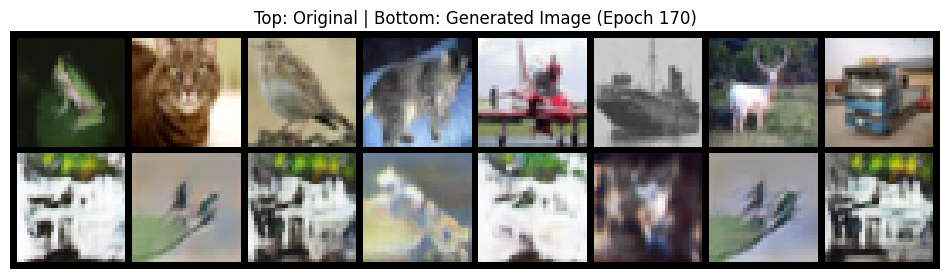

Epoch-171/1000: 100%|██████████| 782/782 [00:16<00:00, 47.86it/s, GenLoss=2.41, DisLoss=0.616, DisSteps=1] 


Generator Loss: 1.8359507242660693
Discriminator Loss: 0.48183096747111787


Epoch-172/1000: 100%|██████████| 782/782 [00:20<00:00, 38.52it/s, GenLoss=3.8, DisLoss=1.27, DisSteps=1]   


Generator Loss: 1.7603767579397582
Discriminator Loss: 0.49156196653614265


Epoch-173/1000: 100%|██████████| 782/782 [00:21<00:00, 36.63it/s, GenLoss=2.07, DisLoss=0.453, DisSteps=1] 


Generator Loss: 1.655246863584689
Discriminator Loss: 0.5375280062217846


Epoch-174/1000: 100%|██████████| 782/782 [00:14<00:00, 54.33it/s, GenLoss=2.05, DisLoss=0.306, DisSteps=1] 


Generator Loss: 1.7457349417764512
Discriminator Loss: 0.4717087335598743


Epoch-175/1000: 100%|██████████| 782/782 [00:14<00:00, 54.63it/s, GenLoss=7.57, DisLoss=2.34, DisSteps=1]  


Generator Loss: 1.7893389462662475
Discriminator Loss: 0.48135984586099223


Epoch-176/1000: 100%|██████████| 782/782 [00:14<00:00, 55.06it/s, GenLoss=1.04, DisLoss=0.46, DisSteps=1]  


Generator Loss: 1.8633168353830152
Discriminator Loss: 0.4712215683725484


Epoch-177/1000: 100%|██████████| 782/782 [00:19<00:00, 39.41it/s, GenLoss=3.78, DisLoss=0.59, DisSteps=1]  


Generator Loss: 1.7801315095418555
Discriminator Loss: 0.4837070562116935


Epoch-178/1000: 100%|██████████| 782/782 [00:14<00:00, 53.88it/s, GenLoss=2.8, DisLoss=0.367, DisSteps=1]  


Generator Loss: 1.8208463595193976
Discriminator Loss: 0.48844344612887447


Epoch-179/1000: 100%|██████████| 782/782 [00:14<00:00, 53.43it/s, GenLoss=3.71, DisLoss=0.366, DisSteps=1] 


Generator Loss: 1.6771455417813548
Discriminator Loss: 0.5160626294210439


Epoch-180/1000: 100%|██████████| 782/782 [00:14<00:00, 52.55it/s, GenLoss=7.42, DisLoss=1.55, DisSteps=1]  


Generator Loss: 1.664113490858956
Discriminator Loss: 0.5320305452322411


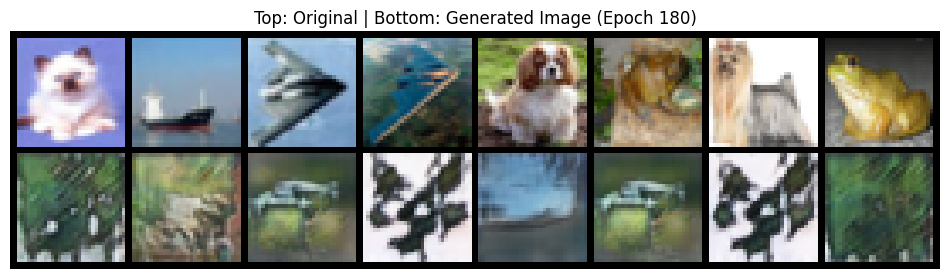

Epoch-181/1000: 100%|██████████| 782/782 [00:14<00:00, 55.37it/s, GenLoss=1.91, DisLoss=0.567, DisSteps=1] 


Generator Loss: 1.5670149958194675
Discriminator Loss: 0.5440542751261036


Epoch-182/1000: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s, GenLoss=1.85, DisLoss=0.604, DisSteps=1] 


Generator Loss: 1.554702139495279
Discriminator Loss: 0.5148909435705151


Epoch-183/1000: 100%|██████████| 782/782 [00:24<00:00, 31.88it/s, GenLoss=2.51, DisLoss=0.529, DisSteps=1] 


Generator Loss: 1.7343552701003717
Discriminator Loss: 0.48749143902755454


Epoch-184/1000: 100%|██████████| 782/782 [00:15<00:00, 51.64it/s, GenLoss=3.35, DisLoss=0.23, DisSteps=1]  


Generator Loss: 1.65684213434034
Discriminator Loss: 0.5079307010411607


Epoch-185/1000: 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, GenLoss=1.88, DisLoss=0.244, DisSteps=1] 


Generator Loss: 1.6624416328223466
Discriminator Loss: 0.5232263999750547


Epoch-186/1000: 100%|██████████| 782/782 [00:29<00:00, 26.28it/s, GenLoss=4.88, DisLoss=0.612, DisSteps=1] 


Generator Loss: 1.6636153282716757
Discriminator Loss: 0.5202026951038624


Epoch-187/1000: 100%|██████████| 782/782 [00:22<00:00, 34.55it/s, GenLoss=1.86, DisLoss=0.888, DisSteps=1] 


Generator Loss: 1.6944516440639106
Discriminator Loss: 0.4984045889600159


Epoch-188/1000: 100%|██████████| 782/782 [00:16<00:00, 46.79it/s, GenLoss=1.41, DisLoss=1.42, DisSteps=1]  


Generator Loss: 1.6606591754709668
Discriminator Loss: 0.5366468214432297


Epoch-189/1000: 100%|██████████| 782/782 [00:22<00:00, 34.50it/s, GenLoss=2.05, DisLoss=0.967, DisSteps=1] 


Generator Loss: 1.5944563395074567
Discriminator Loss: 0.5078995321565272


Epoch-190/1000: 100%|██████████| 782/782 [00:14<00:00, 54.22it/s, GenLoss=2.21, DisLoss=0.75, DisSteps=1]  


Generator Loss: 1.7604422416833356
Discriminator Loss: 0.48245995638468075


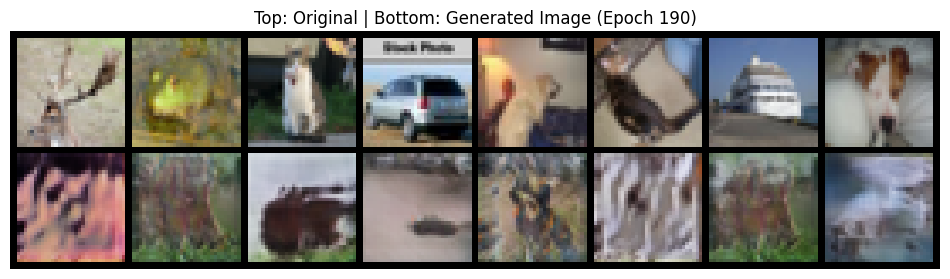

Epoch-191/1000: 100%|██████████| 782/782 [00:24<00:00, 32.09it/s, GenLoss=3.18, DisLoss=0.484, DisSteps=1] 


Generator Loss: 1.74293179402266
Discriminator Loss: 0.49390899306139374


Epoch-192/1000: 100%|██████████| 782/782 [00:15<00:00, 50.29it/s, GenLoss=4.33, DisLoss=0.379, DisSteps=1] 


Generator Loss: 1.6600424170951404
Discriminator Loss: 0.49644647999797636


Epoch-193/1000: 100%|██████████| 782/782 [00:22<00:00, 35.15it/s, GenLoss=4.56, DisLoss=0.187, DisSteps=1] 


Generator Loss: 1.768478534944222
Discriminator Loss: 0.492964882832354


Epoch-194/1000: 100%|██████████| 782/782 [00:21<00:00, 36.31it/s, GenLoss=1.43, DisLoss=0.621, DisSteps=1] 


Generator Loss: 1.783420161365548
Discriminator Loss: 0.4838239624524665


Epoch-195/1000: 100%|██████████| 782/782 [00:14<00:00, 55.53it/s, GenLoss=1.77, DisLoss=0.431, DisSteps=1] 


Generator Loss: 1.6992812652112272
Discriminator Loss: 0.49912610240375904


Epoch-196/1000: 100%|██████████| 782/782 [00:18<00:00, 43.34it/s, GenLoss=2.72, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.7993281091113225
Discriminator Loss: 0.4769064835117906


Epoch-197/1000: 100%|██████████| 782/782 [00:14<00:00, 55.59it/s, GenLoss=3.47, DisLoss=0.844, DisSteps=1] 


Generator Loss: 1.6145649899912002
Discriminator Loss: 0.525755864465633


Epoch-198/1000: 100%|██████████| 782/782 [00:14<00:00, 55.63it/s, GenLoss=4.31, DisLoss=0.214, DisSteps=1] 


Generator Loss: 1.7106685168526667
Discriminator Loss: 0.5030015557432723


Epoch-199/1000: 100%|██████████| 782/782 [00:13<00:00, 57.12it/s, GenLoss=1.72, DisLoss=0.248, DisSteps=1] 


Generator Loss: 1.8456042295374224
Discriminator Loss: 0.48085971346215517


Epoch-200/1000: 100%|██████████| 782/782 [00:19<00:00, 40.52it/s, GenLoss=2.54, DisLoss=1.59, DisSteps=1]  


Generator Loss: 1.8658760140466568
Discriminator Loss: 0.4663895480048931


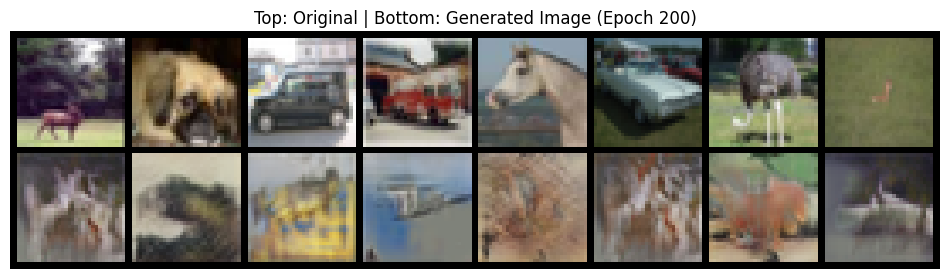

Epoch-201/1000: 100%|██████████| 782/782 [00:18<00:00, 43.08it/s, GenLoss=3.12, DisLoss=1.34, DisSteps=1]  


Generator Loss: 1.75209914555635
Discriminator Loss: 0.4836225957821702


Epoch-202/1000: 100%|██████████| 782/782 [00:13<00:00, 56.06it/s, GenLoss=3.88, DisLoss=1.26, DisSteps=1]  


Generator Loss: 1.7116692635561803
Discriminator Loss: 0.4963400347344101


Epoch-203/1000: 100%|██████████| 782/782 [00:21<00:00, 37.00it/s, GenLoss=3.2, DisLoss=0.776, DisSteps=1]  


Generator Loss: 1.559138785390293
Discriminator Loss: 0.5397002989297632


Epoch-204/1000: 100%|██████████| 782/782 [00:14<00:00, 55.23it/s, GenLoss=1.69, DisLoss=0.607, DisSteps=1] 


Generator Loss: 1.5812841577984182
Discriminator Loss: 0.5348099303215056


Epoch-205/1000: 100%|██████████| 782/782 [00:22<00:00, 34.08it/s, GenLoss=2.96, DisLoss=0.418, DisSteps=1] 


Generator Loss: 1.5408599000910055
Discriminator Loss: 0.5442680007280292


Epoch-206/1000: 100%|██████████| 782/782 [00:26<00:00, 29.40it/s, GenLoss=2.67, DisLoss=0.196, DisSteps=1] 


Generator Loss: 1.5739935546579873
Discriminator Loss: 0.5352625891451945


Epoch-207/1000: 100%|██████████| 782/782 [00:26<00:00, 29.95it/s, GenLoss=5.58, DisLoss=0.837, DisSteps=1] 


Generator Loss: 1.610760800521392
Discriminator Loss: 0.5312040336906453


Epoch-208/1000: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s, GenLoss=2.87, DisLoss=0.455, DisSteps=1] 


Generator Loss: 1.5581904254148684
Discriminator Loss: 0.5470906228513059


Epoch-209/1000: 100%|██████████| 782/782 [00:14<00:00, 52.61it/s, GenLoss=4.19, DisLoss=0.821, DisSteps=1] 


Generator Loss: 1.6715445931991348
Discriminator Loss: 0.5038673576644009


Epoch-210/1000: 100%|██████████| 782/782 [00:17<00:00, 43.49it/s, GenLoss=2.04, DisLoss=0.787, DisSteps=1] 


Generator Loss: 1.6550013896297007
Discriminator Loss: 0.5160379948289803


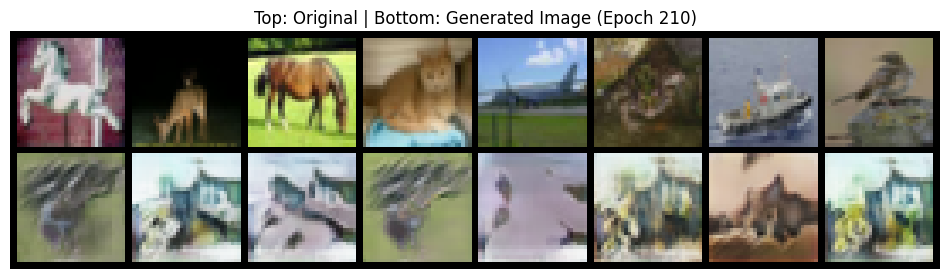

Epoch-211/1000: 100%|██████████| 782/782 [00:14<00:00, 55.66it/s, GenLoss=2.6, DisLoss=0.713, DisSteps=1]  


Generator Loss: 1.6609544048223959
Discriminator Loss: 0.5155039904329478


Epoch-212/1000: 100%|██████████| 782/782 [00:13<00:00, 56.06it/s, GenLoss=1.8, DisLoss=0.25, DisSteps=1]   


Generator Loss: 1.6620327098214107
Discriminator Loss: 0.4990957617531042


Epoch-213/1000: 100%|██████████| 782/782 [00:14<00:00, 54.60it/s, GenLoss=3.81, DisLoss=0.708, DisSteps=1] 


Generator Loss: 1.493912375148605
Discriminator Loss: 0.5499799727745678


Epoch-214/1000: 100%|██████████| 782/782 [00:14<00:00, 53.84it/s, GenLoss=2.28, DisLoss=0.813, DisSteps=1] 


Generator Loss: 1.7802710610887278
Discriminator Loss: 0.5131164826548008


Epoch-215/1000: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s, GenLoss=4.23, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.6255968511104584
Discriminator Loss: 0.5379518052501142


Epoch-216/1000: 100%|██████████| 782/782 [00:13<00:00, 56.95it/s, GenLoss=3.43, DisLoss=1.3, DisSteps=1]   


Generator Loss: 1.4775581652169947
Discriminator Loss: 0.5856106025559823


Epoch-217/1000: 100%|██████████| 782/782 [00:24<00:00, 32.38it/s, GenLoss=3.94, DisLoss=0.565, DisSteps=1] 


Generator Loss: 1.6140896681019716
Discriminator Loss: 0.5298974690268107


Epoch-218/1000: 100%|██████████| 782/782 [00:19<00:00, 39.13it/s, GenLoss=5.71, DisLoss=0.559, DisSteps=1] 


Generator Loss: 1.7019548448912627
Discriminator Loss: 0.5005163291416814


Epoch-219/1000: 100%|██████████| 782/782 [00:16<00:00, 47.10it/s, GenLoss=1.95, DisLoss=1.34, DisSteps=1]  


Generator Loss: 1.7752244716410137
Discriminator Loss: 0.4873225603376508


Epoch-220/1000: 100%|██████████| 782/782 [00:25<00:00, 30.98it/s, GenLoss=2.18, DisLoss=1.38, DisSteps=1]  


Generator Loss: 1.6626348025963436
Discriminator Loss: 0.5127794602719109


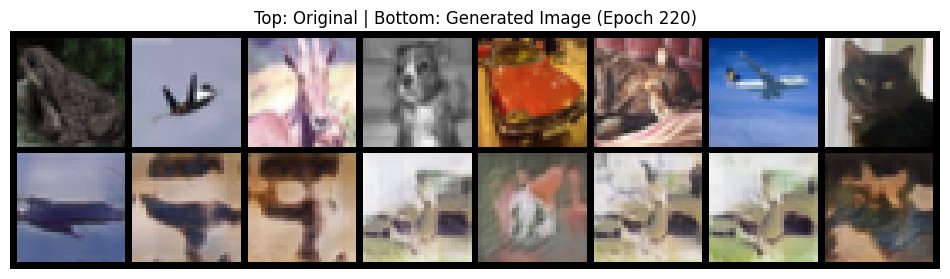

Epoch-221/1000: 100%|██████████| 782/782 [00:15<00:00, 51.23it/s, GenLoss=1.87, DisLoss=0.985, DisSteps=1] 


Generator Loss: 1.783465137300284
Discriminator Loss: 0.49493279220426784


Epoch-222/1000: 100%|██████████| 782/782 [00:13<00:00, 55.97it/s, GenLoss=2.79, DisLoss=0.771, DisSteps=1] 


Generator Loss: 1.6257016750247888
Discriminator Loss: 0.524583387386311


Epoch-223/1000: 100%|██████████| 782/782 [00:15<00:00, 50.55it/s, GenLoss=4.79, DisLoss=0.821, DisSteps=1] 


Generator Loss: 1.5657591317468287
Discriminator Loss: 0.5406331054847259


Epoch-224/1000: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s, GenLoss=4.08, DisLoss=0.263, DisSteps=1] 


Generator Loss: 1.6467743115809264
Discriminator Loss: 0.5095721863191146


Epoch-225/1000: 100%|██████████| 782/782 [00:27<00:00, 28.33it/s, GenLoss=2.2, DisLoss=1.32, DisSteps=1]   


Generator Loss: 1.6869745965275313
Discriminator Loss: 0.49789270084075


Epoch-226/1000: 100%|██████████| 782/782 [00:23<00:00, 32.87it/s, GenLoss=3.29, DisLoss=0.311, DisSteps=1] 


Generator Loss: 1.5866031345275358
Discriminator Loss: 0.5463644641134745


Epoch-227/1000: 100%|██████████| 782/782 [00:24<00:00, 31.63it/s, GenLoss=3.24, DisLoss=1.66, DisSteps=1]  


Generator Loss: 1.651945222026247
Discriminator Loss: 0.5242986969859399


Epoch-228/1000: 100%|██████████| 782/782 [00:14<00:00, 53.89it/s, GenLoss=1.97, DisLoss=0.75, DisSteps=1]  


Generator Loss: 1.623612499374258
Discriminator Loss: 0.5616895575314531


Epoch-229/1000: 100%|██████████| 782/782 [00:31<00:00, 25.12it/s, GenLoss=1.69, DisLoss=1.09, DisSteps=1]  


Generator Loss: 1.6076026600035256
Discriminator Loss: 0.5029122624022272


Epoch-230/1000: 100%|██████████| 782/782 [00:14<00:00, 52.57it/s, GenLoss=2.28, DisLoss=0.407, DisSteps=1] 


Generator Loss: 1.6487376811483023
Discriminator Loss: 0.5232556395404174


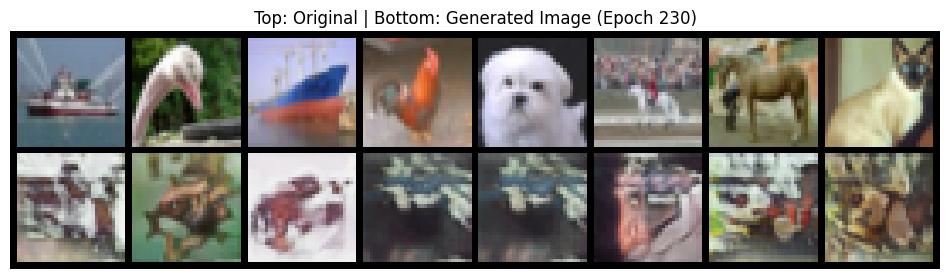

Epoch-231/1000: 100%|██████████| 782/782 [00:20<00:00, 38.33it/s, GenLoss=2.49, DisLoss=0.763, DisSteps=1] 


Generator Loss: 1.4935460217925898
Discriminator Loss: 0.5388884888890454


Epoch-232/1000: 100%|██████████| 782/782 [00:25<00:00, 30.50it/s, GenLoss=4.6, DisLoss=0.633, DisSteps=1]  


Generator Loss: 1.5926747164686623
Discriminator Loss: 0.5259355825307729


Epoch-233/1000: 100%|██████████| 782/782 [00:13<00:00, 56.95it/s, GenLoss=4.39, DisLoss=1.14, DisSteps=1]  


Generator Loss: 1.5648354660443333
Discriminator Loss: 0.5305465468398446


Epoch-234/1000: 100%|██████████| 782/782 [00:14<00:00, 54.44it/s, GenLoss=2.74, DisLoss=0.519, DisSteps=1] 


Generator Loss: 1.5557412500576595
Discriminator Loss: 0.5530871367439285


Epoch-235/1000: 100%|██████████| 782/782 [00:14<00:00, 55.40it/s, GenLoss=2.72, DisLoss=1.34, DisSteps=1]  


Generator Loss: 1.5365396050540991
Discriminator Loss: 0.5498486095491577


Epoch-236/1000: 100%|██████████| 782/782 [00:14<00:00, 53.34it/s, GenLoss=2.78, DisLoss=1.31, DisSteps=1]  


Generator Loss: 1.4999435243323027
Discriminator Loss: 0.5740220726984541


Epoch-237/1000: 100%|██████████| 782/782 [00:13<00:00, 56.46it/s, GenLoss=2.72, DisLoss=0.538, DisSteps=1] 


Generator Loss: 1.5962891003588582
Discriminator Loss: 0.5299981687113148


Epoch-238/1000: 100%|██████████| 782/782 [00:13<00:00, 56.51it/s, GenLoss=2.36, DisLoss=0.662, DisSteps=1] 


Generator Loss: 1.689972886344051
Discriminator Loss: 0.5001012277991875


Epoch-239/1000: 100%|██████████| 782/782 [00:13<00:00, 56.49it/s, GenLoss=3.88, DisLoss=1.08, DisSteps=1]  


Generator Loss: 1.5706111926709294
Discriminator Loss: 0.5548621522038794


Epoch-240/1000: 100%|██████████| 782/782 [00:14<00:00, 53.34it/s, GenLoss=2.52, DisLoss=2.31, DisSteps=1]  


Generator Loss: 1.6891677321680367
Discriminator Loss: 0.5165816792251204


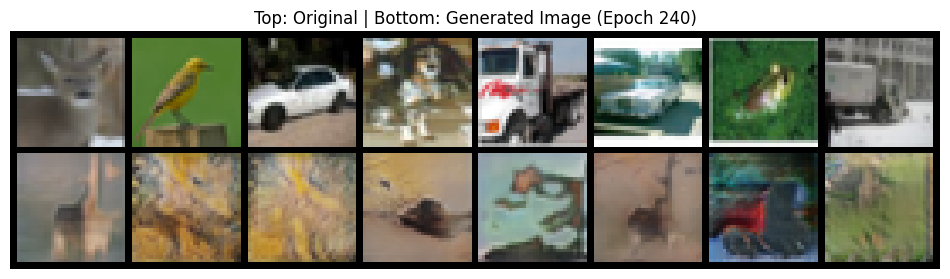

Epoch-241/1000: 100%|██████████| 782/782 [00:13<00:00, 56.01it/s, GenLoss=2.43, DisLoss=0.503, DisSteps=1] 


Generator Loss: 1.5584282802651301
Discriminator Loss: 0.5197653316552072


Epoch-242/1000: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s, GenLoss=3.02, DisLoss=0.58, DisSteps=1]  


Generator Loss: 1.6343919567744751
Discriminator Loss: 0.5108453261349207


Epoch-243/1000: 100%|██████████| 782/782 [00:14<00:00, 55.69it/s, GenLoss=2.78, DisLoss=0.664, DisSteps=1] 


Generator Loss: 1.607885219328239
Discriminator Loss: 0.5386884479266604


Epoch-244/1000: 100%|██████████| 782/782 [00:23<00:00, 32.81it/s, GenLoss=2.4, DisLoss=2.47, DisSteps=1]   


Generator Loss: 1.5826764032816338
Discriminator Loss: 0.5362655328553351


Epoch-245/1000: 100%|██████████| 782/782 [00:21<00:00, 37.09it/s, GenLoss=1.66, DisLoss=1.05, DisSteps=1]  


Generator Loss: 1.6666157340911953
Discriminator Loss: 0.50145290460428


Epoch-246/1000: 100%|██████████| 782/782 [00:16<00:00, 47.20it/s, GenLoss=2.03, DisLoss=0.768, DisSteps=1] 


Generator Loss: 1.562578486397748
Discriminator Loss: 0.5419480455729663


Epoch-247/1000: 100%|██████████| 782/782 [00:21<00:00, 36.57it/s, GenLoss=2.57, DisLoss=0.479, DisSteps=1] 


Generator Loss: 1.4929306462521443
Discriminator Loss: 0.5567509165162321


Epoch-248/1000: 100%|██████████| 782/782 [00:28<00:00, 27.24it/s, GenLoss=3.11, DisLoss=0.468, DisSteps=1] 


Generator Loss: 1.5974827582955056
Discriminator Loss: 0.5140685525429828


Epoch-249/1000: 100%|██████████| 782/782 [00:27<00:00, 28.20it/s, GenLoss=5.15, DisLoss=0.448, DisSteps=1] 


Generator Loss: 1.641117360204687
Discriminator Loss: 0.5143498177723507


Epoch-250/1000: 100%|██████████| 782/782 [00:13<00:00, 56.08it/s, GenLoss=2.26, DisLoss=0.867, DisSteps=1] 


Generator Loss: 1.59638881229836
Discriminator Loss: 0.5391947827909304


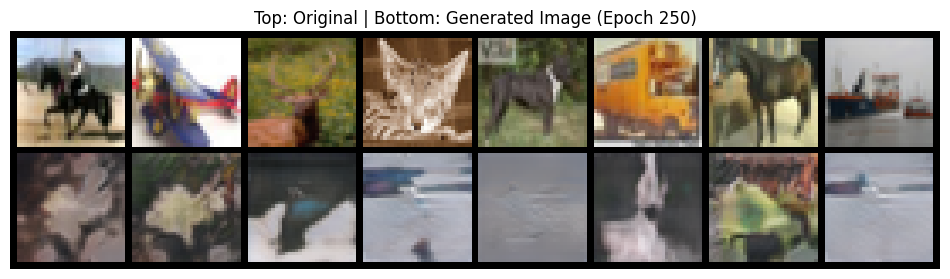

Epoch-251/1000: 100%|██████████| 782/782 [00:18<00:00, 42.41it/s, GenLoss=2.53, DisLoss=0.789, DisSteps=1] 


Generator Loss: 1.5801439907620936
Discriminator Loss: 0.5501531789941556


Epoch-252/1000: 100%|██████████| 782/782 [00:14<00:00, 53.15it/s, GenLoss=2.34, DisLoss=1.96, DisSteps=1]  


Generator Loss: 1.6687057725608807
Discriminator Loss: 0.5250523592276342


Epoch-253/1000: 100%|██████████| 782/782 [00:14<00:00, 55.25it/s, GenLoss=3.2, DisLoss=1.22, DisSteps=1]   


Generator Loss: 1.654815489526295
Discriminator Loss: 0.5042008610866259


Epoch-254/1000: 100%|██████████| 782/782 [00:15<00:00, 50.65it/s, GenLoss=2.38, DisLoss=1.15, DisSteps=1]  


Generator Loss: 1.7697690175012555
Discriminator Loss: 0.48280812304495546


Epoch-255/1000: 100%|██████████| 782/782 [00:18<00:00, 41.42it/s, GenLoss=2.45, DisLoss=0.99, DisSteps=1]  


Generator Loss: 1.805752889045974
Discriminator Loss: 0.4684064540526141


Epoch-256/1000: 100%|██████████| 782/782 [00:14<00:00, 55.36it/s, GenLoss=2.22, DisLoss=0.348, DisSteps=1] 


Generator Loss: 1.600837827338587
Discriminator Loss: 0.5366872549438111


Epoch-257/1000: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s, GenLoss=3.36, DisLoss=0.756, DisSteps=1] 


Generator Loss: 1.8342331061735178
Discriminator Loss: 0.4678825283484995


Epoch-258/1000: 100%|██████████| 782/782 [00:14<00:00, 52.92it/s, GenLoss=1.57, DisLoss=0.548, DisSteps=1] 


Generator Loss: 1.6276709361911734
Discriminator Loss: 0.529852631489944


Epoch-259/1000: 100%|██████████| 782/782 [00:13<00:00, 56.86it/s, GenLoss=3.14, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.5308247911350807
Discriminator Loss: 0.5488605265650908


Epoch-260/1000: 100%|██████████| 782/782 [00:13<00:00, 56.06it/s, GenLoss=3.13, DisLoss=2.37, DisSteps=1]  


Generator Loss: 1.471054787297383
Discriminator Loss: 0.5624545998966602


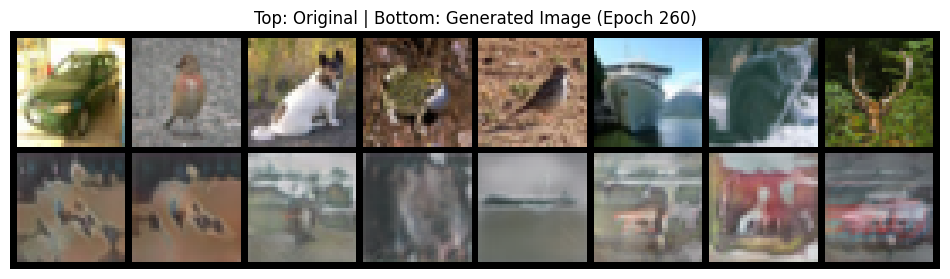

Epoch-261/1000: 100%|██████████| 782/782 [00:21<00:00, 36.85it/s, GenLoss=2, DisLoss=0.865, DisSteps=1]    


Generator Loss: 1.6015693773241604
Discriminator Loss: 0.525655275568023


Epoch-262/1000: 100%|██████████| 782/782 [00:14<00:00, 52.23it/s, GenLoss=3.41, DisLoss=1.86, DisSteps=1]  


Generator Loss: 1.5974566191053756
Discriminator Loss: 0.5386822217184565


Epoch-263/1000: 100%|██████████| 782/782 [00:14<00:00, 52.55it/s, GenLoss=1.24, DisLoss=0.498, DisSteps=1] 


Generator Loss: 1.6345248319913663
Discriminator Loss: 0.5152932205011168


Epoch-264/1000: 100%|██████████| 782/782 [00:19<00:00, 40.86it/s, GenLoss=1.73, DisLoss=0.938, DisSteps=1] 


Generator Loss: 1.646081226294303
Discriminator Loss: 0.5319266770120776


Epoch-265/1000: 100%|██████████| 782/782 [00:14<00:00, 55.67it/s, GenLoss=2.7, DisLoss=0.439, DisSteps=1]  


Generator Loss: 1.602529367674952
Discriminator Loss: 0.5184616991473586


Epoch-266/1000: 100%|██████████| 782/782 [00:14<00:00, 55.32it/s, GenLoss=3.75, DisLoss=0.903, DisSteps=1] 


Generator Loss: 1.7119029509594372
Discriminator Loss: 0.48920658383223103


Epoch-267/1000: 100%|██████████| 782/782 [00:17<00:00, 45.74it/s, GenLoss=2.33, DisLoss=1.59, DisSteps=1]  


Generator Loss: 1.5908762433797197
Discriminator Loss: 0.5319971373814452


Epoch-268/1000: 100%|██████████| 782/782 [00:14<00:00, 54.56it/s, GenLoss=4.11, DisLoss=1.29, DisSteps=1]  


Generator Loss: 1.5652447207199642
Discriminator Loss: 0.5296381780939639


Epoch-269/1000: 100%|██████████| 782/782 [00:20<00:00, 37.56it/s, GenLoss=0.983, DisLoss=0.481, DisSteps=1]


Generator Loss: 1.5335437317790888
Discriminator Loss: 0.5693182916859226


Epoch-270/1000: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s, GenLoss=2.23, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.5341424739269345
Discriminator Loss: 0.5440212676058644


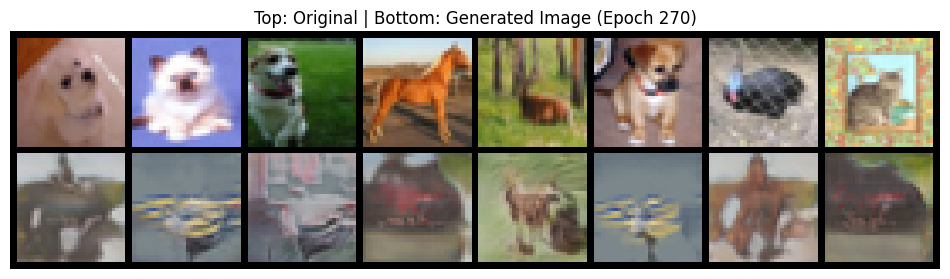

Epoch-271/1000: 100%|██████████| 782/782 [00:24<00:00, 32.33it/s, GenLoss=2.48, DisLoss=0.757, DisSteps=1] 


Generator Loss: 1.4989056858946295
Discriminator Loss: 0.5514517200877295


Epoch-272/1000: 100%|██████████| 782/782 [00:15<00:00, 51.42it/s, GenLoss=4.42, DisLoss=0.769, DisSteps=1] 


Generator Loss: 1.6076669226522031
Discriminator Loss: 0.5481540082246447


Epoch-273/1000: 100%|██████████| 782/782 [00:19<00:00, 39.59it/s, GenLoss=4.01, DisLoss=0.353, DisSteps=1] 


Generator Loss: 1.5085422833023778
Discriminator Loss: 0.5606827691883383


Epoch-274/1000: 100%|██████████| 782/782 [00:14<00:00, 54.70it/s, GenLoss=2.6, DisLoss=0.836, DisSteps=1]  


Generator Loss: 1.5255040154432702
Discriminator Loss: 0.5346016998943466


Epoch-275/1000: 100%|██████████| 782/782 [00:14<00:00, 52.97it/s, GenLoss=4.32, DisLoss=0.643, DisSteps=1] 


Generator Loss: 1.436984900699552
Discriminator Loss: 0.5793163108322626


Epoch-276/1000: 100%|██████████| 782/782 [00:14<00:00, 54.73it/s, GenLoss=2.22, DisLoss=0.448, DisSteps=1] 


Generator Loss: 1.5542130179874731
Discriminator Loss: 0.5371233748124383


Epoch-277/1000: 100%|██████████| 782/782 [00:14<00:00, 54.97it/s, GenLoss=3.36, DisLoss=0.674, DisSteps=1] 


Generator Loss: 1.7011344176729013
Discriminator Loss: 0.49728061384557154


Epoch-278/1000: 100%|██████████| 782/782 [00:13<00:00, 57.30it/s, GenLoss=2.35, DisLoss=1.41, DisSteps=1]  


Generator Loss: 1.6681259487138684
Discriminator Loss: 0.5081160001818786


Epoch-279/1000: 100%|██████████| 782/782 [00:23<00:00, 32.91it/s, GenLoss=1.5, DisLoss=0.56, DisSteps=1]   


Generator Loss: 1.7934839478157976
Discriminator Loss: 0.4738808898898342


Epoch-280/1000: 100%|██████████| 782/782 [00:14<00:00, 53.29it/s, GenLoss=4.01, DisLoss=0.86, DisSteps=1]  


Generator Loss: 1.787357804720359
Discriminator Loss: 0.47094739977356115


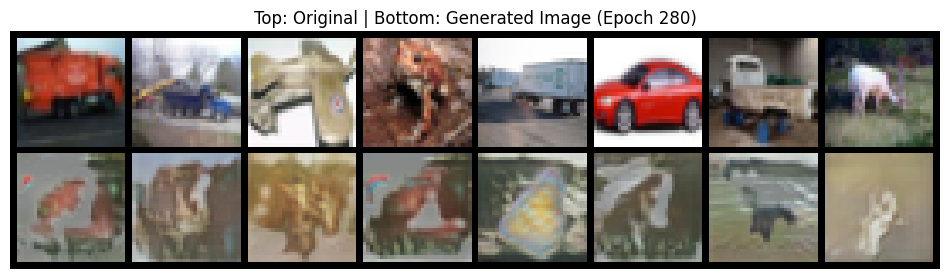

Epoch-281/1000: 100%|██████████| 782/782 [00:21<00:00, 37.17it/s, GenLoss=3.2, DisLoss=0.567, DisSteps=1]  


Generator Loss: 1.744172797331115
Discriminator Loss: 0.4790630650223064


Epoch-282/1000: 100%|██████████| 782/782 [00:13<00:00, 56.81it/s, GenLoss=1.67, DisLoss=0.276, DisSteps=1] 


Generator Loss: 1.8096504466003165
Discriminator Loss: 0.46575521656771757


Epoch-283/1000: 100%|██████████| 782/782 [00:14<00:00, 54.62it/s, GenLoss=4.63, DisLoss=0.867, DisSteps=1] 


Generator Loss: 1.7945885572134685
Discriminator Loss: 0.4823290791238665


Epoch-284/1000: 100%|██████████| 782/782 [00:14<00:00, 54.98it/s, GenLoss=1.4, DisLoss=0.99, DisSteps=1]   


Generator Loss: 1.607648999718449
Discriminator Loss: 0.5191175353610912


Epoch-285/1000: 100%|██████████| 782/782 [00:14<00:00, 54.76it/s, GenLoss=1.77, DisLoss=0.608, DisSteps=1] 


Generator Loss: 1.6067756199089767
Discriminator Loss: 0.5221947099051207


Epoch-286/1000: 100%|██████████| 782/782 [01:05<00:00, 11.91it/s, GenLoss=2.42, DisLoss=0.604, DisSteps=1] 


Generator Loss: 1.5566422941587161
Discriminator Loss: 0.5408111457972575


Epoch-287/1000: 100%|██████████| 782/782 [00:37<00:00, 20.80it/s, GenLoss=4.63, DisLoss=0.85, DisSteps=1]  


Generator Loss: 1.729488074512738
Discriminator Loss: 0.4908315389014571


Epoch-288/1000: 100%|██████████| 782/782 [00:24<00:00, 31.40it/s, GenLoss=2.52, DisLoss=0.682, DisSteps=1] 


Generator Loss: 1.7013516981735863
Discriminator Loss: 0.4963745797800896


Epoch-289/1000: 100%|██████████| 782/782 [00:22<00:00, 34.63it/s, GenLoss=2.07, DisLoss=0.504, DisSteps=1] 


Generator Loss: 1.7520047371725902
Discriminator Loss: 0.4848320200429548


Epoch-290/1000: 100%|██████████| 782/782 [00:16<00:00, 48.50it/s, GenLoss=2.07, DisLoss=0.971, DisSteps=1] 


Generator Loss: 1.6610394393848946
Discriminator Loss: 0.5106253290115415


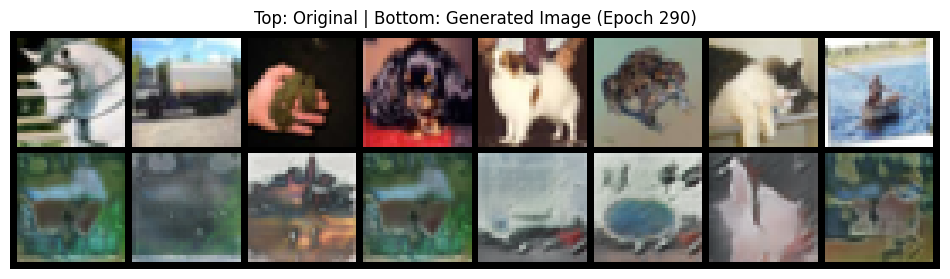

Epoch-291/1000: 100%|██████████| 782/782 [00:19<00:00, 40.22it/s, GenLoss=3.65, DisLoss=1.65, DisSteps=1]  


Generator Loss: 1.6876226524486566
Discriminator Loss: 0.5207371770039849


Epoch-292/1000: 100%|██████████| 782/782 [00:24<00:00, 31.87it/s, GenLoss=1.31, DisLoss=0.644, DisSteps=1] 


Generator Loss: 1.566347655394803
Discriminator Loss: 0.5319867901446874


Epoch-293/1000: 100%|██████████| 782/782 [00:16<00:00, 48.35it/s, GenLoss=3.07, DisLoss=0.864, DisSteps=1] 


Generator Loss: 1.5805653958674282
Discriminator Loss: 0.5530262264373053


Epoch-294/1000: 100%|██████████| 782/782 [00:22<00:00, 35.29it/s, GenLoss=4.68, DisLoss=0.73, DisSteps=1]  


Generator Loss: 1.5709691093400922
Discriminator Loss: 0.5415711914334456


Epoch-295/1000: 100%|██████████| 782/782 [00:19<00:00, 40.27it/s, GenLoss=3.52, DisLoss=1.84, DisSteps=1]  


Generator Loss: 1.6287811303230197
Discriminator Loss: 0.5281579665020298


Epoch-296/1000: 100%|██████████| 782/782 [00:14<00:00, 52.41it/s, GenLoss=3.95, DisLoss=0.306, DisSteps=1] 


Generator Loss: 1.6784344008359153
Discriminator Loss: 0.5026819049892828


Epoch-297/1000: 100%|██████████| 782/782 [00:21<00:00, 37.02it/s, GenLoss=1.86, DisLoss=0.477, DisSteps=1] 


Generator Loss: 1.548157248998542
Discriminator Loss: 0.5547653907895698


Epoch-298/1000: 100%|██████████| 782/782 [00:26<00:00, 29.82it/s, GenLoss=0.999, DisLoss=0.536, DisSteps=1]


Generator Loss: 1.608174107263765
Discriminator Loss: 0.5186372484697406


Epoch-299/1000: 100%|██████████| 782/782 [00:41<00:00, 18.84it/s, GenLoss=2.83, DisLoss=0.463, DisSteps=1] 


Generator Loss: 1.6630514105567542
Discriminator Loss: 0.5059923845369493


Epoch-300/1000: 100%|██████████| 782/782 [00:23<00:00, 33.46it/s, GenLoss=4.15, DisLoss=0.739, DisSteps=1] 


Generator Loss: 1.5424016819280737
Discriminator Loss: 0.5656568428973103


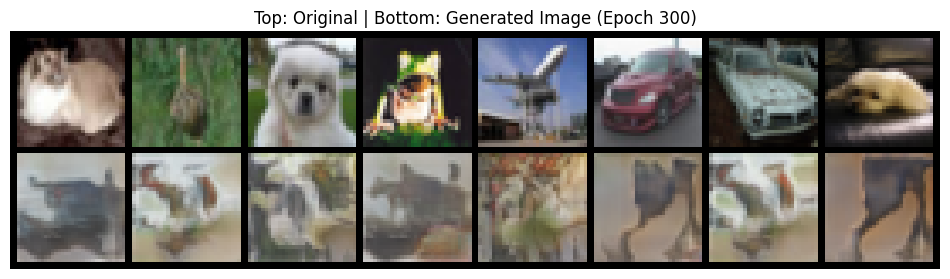

Epoch-301/1000: 100%|██████████| 782/782 [00:21<00:00, 37.14it/s, GenLoss=3.34, DisLoss=0.306, DisSteps=1] 


Generator Loss: 1.5127831701275027
Discriminator Loss: 0.557886095703258


Epoch-302/1000: 100%|██████████| 782/782 [00:24<00:00, 32.40it/s, GenLoss=4.12, DisLoss=0.687, DisSteps=1] 


Generator Loss: 1.5911072385128198
Discriminator Loss: 0.5439111526169436


Epoch-303/1000: 100%|██████████| 782/782 [00:14<00:00, 53.82it/s, GenLoss=2.31, DisLoss=1.01, DisSteps=1]  


Generator Loss: 1.5636324753694217
Discriminator Loss: 0.5445910322925319


Epoch-304/1000: 100%|██████████| 782/782 [00:14<00:00, 55.23it/s, GenLoss=4.39, DisLoss=1.11, DisSteps=1]  


Generator Loss: 1.4931884566917444
Discriminator Loss: 0.5742993799164472


Epoch-305/1000: 100%|██████████| 782/782 [00:14<00:00, 54.63it/s, GenLoss=2.94, DisLoss=0.992, DisSteps=1] 


Generator Loss: 1.5880029145104195
Discriminator Loss: 0.5483225847754027


Epoch-306/1000: 100%|██████████| 782/782 [00:14<00:00, 55.67it/s, GenLoss=2.15, DisLoss=0.275, DisSteps=1] 


Generator Loss: 1.5677000829935683
Discriminator Loss: 0.5465556440870171


Epoch-307/1000: 100%|██████████| 782/782 [00:31<00:00, 24.60it/s, GenLoss=1.71, DisLoss=1.9, DisSteps=1]   


Generator Loss: 1.717502088726634
Discriminator Loss: 0.504775505579646


Epoch-308/1000: 100%|██████████| 782/782 [00:22<00:00, 35.01it/s, GenLoss=4.01, DisLoss=1.07, DisSteps=1]  


Generator Loss: 1.5717518251112965
Discriminator Loss: 0.5365838758704607


Epoch-309/1000: 100%|██████████| 782/782 [00:25<00:00, 31.22it/s, GenLoss=1.96, DisLoss=0.887, DisSteps=1] 


Generator Loss: 1.5362047063725075
Discriminator Loss: 0.5433921489836006


Epoch-310/1000: 100%|██████████| 782/782 [00:20<00:00, 38.73it/s, GenLoss=0.729, DisLoss=0.493, DisSteps=1]


Generator Loss: 1.602696012505485
Discriminator Loss: 0.5182105791385826


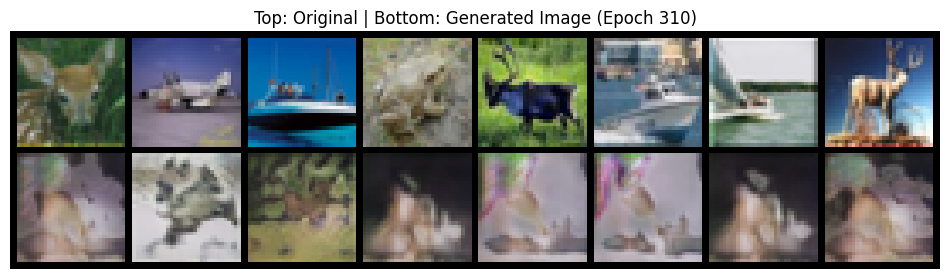

Epoch-311/1000: 100%|██████████| 782/782 [00:29<00:00, 26.55it/s, GenLoss=4.52, DisLoss=0.569, DisSteps=1] 


Generator Loss: 1.506508821531025
Discriminator Loss: 0.5526718292242426


Epoch-312/1000: 100%|██████████| 782/782 [00:14<00:00, 52.27it/s, GenLoss=2.24, DisLoss=1.82, DisSteps=1]  


Generator Loss: 1.5045412455297187
Discriminator Loss: 0.5664708408362725


Epoch-313/1000: 100%|██████████| 782/782 [00:13<00:00, 56.16it/s, GenLoss=1.46, DisLoss=1.41, DisSteps=1]  


Generator Loss: 1.5516988564177852
Discriminator Loss: 0.5240262539490409


Epoch-314/1000: 100%|██████████| 782/782 [00:21<00:00, 36.67it/s, GenLoss=3.8, DisLoss=1.7, DisSteps=1]    


Generator Loss: 1.5818486684347357
Discriminator Loss: 0.5272002264361857


Epoch-315/1000: 100%|██████████| 782/782 [00:17<00:00, 45.96it/s, GenLoss=3.41, DisLoss=0.283, DisSteps=1] 


Generator Loss: 1.5093194506204952
Discriminator Loss: 0.5567283704686348


Epoch-316/1000: 100%|██████████| 782/782 [00:19<00:00, 39.55it/s, GenLoss=4.37, DisLoss=1.01, DisSteps=1]  


Generator Loss: 1.5847275182033134
Discriminator Loss: 0.5402754564076433


Epoch-317/1000: 100%|██████████| 782/782 [00:15<00:00, 49.54it/s, GenLoss=2.05, DisLoss=1.16, DisSteps=1]  


Generator Loss: 1.4683862820915554
Discriminator Loss: 0.5670934511953608


Epoch-318/1000: 100%|██████████| 782/782 [00:19<00:00, 39.11it/s, GenLoss=4.85, DisLoss=0.293, DisSteps=1] 


Generator Loss: 1.5993936526043642
Discriminator Loss: 0.533419510287702


Epoch-319/1000: 100%|██████████| 782/782 [00:22<00:00, 35.36it/s, GenLoss=2.22, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.5487187660639854
Discriminator Loss: 0.5300366183947725


Epoch-320/1000: 100%|██████████| 782/782 [00:25<00:00, 31.05it/s, GenLoss=2.84, DisLoss=0.464, DisSteps=1] 


Generator Loss: 1.5982241520034077
Discriminator Loss: 0.5093713338341554


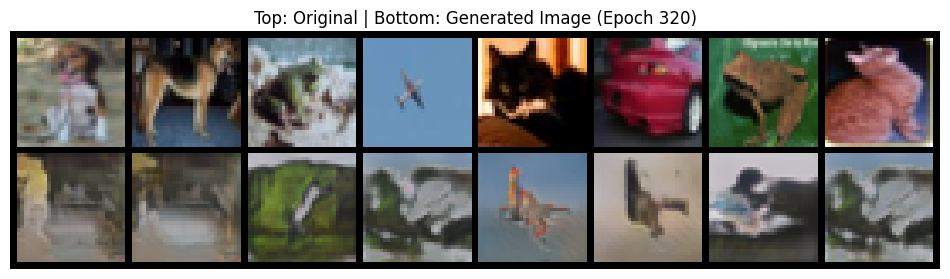

Epoch-321/1000: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s, GenLoss=3.7, DisLoss=0.479, DisSteps=1]  


Generator Loss: 1.6743223209820135
Discriminator Loss: 0.5246241204916974


Epoch-322/1000: 100%|██████████| 782/782 [00:25<00:00, 30.76it/s, GenLoss=2.99, DisLoss=0.554, DisSteps=1] 


Generator Loss: 1.564791739672956
Discriminator Loss: 0.5469992556192381


Epoch-323/1000: 100%|██████████| 782/782 [00:18<00:00, 41.16it/s, GenLoss=2.33, DisLoss=1.24, DisSteps=1]  


Generator Loss: 1.5168661645153905
Discriminator Loss: 0.5348445623160323


Epoch-324/1000: 100%|██████████| 782/782 [00:14<00:00, 53.22it/s, GenLoss=2.01, DisLoss=0.55, DisSteps=1]  


Generator Loss: 1.5272975741597392
Discriminator Loss: 0.5327982777524787


Epoch-325/1000: 100%|██████████| 782/782 [00:14<00:00, 53.42it/s, GenLoss=3.37, DisLoss=0.356, DisSteps=1] 


Generator Loss: 1.6857078271296324
Discriminator Loss: 0.5063234776296579


Epoch-326/1000: 100%|██████████| 782/782 [00:14<00:00, 53.87it/s, GenLoss=1.85, DisLoss=1.45, DisSteps=1]  


Generator Loss: 1.6146721764065115
Discriminator Loss: 0.5201505308261003


Epoch-327/1000: 100%|██████████| 782/782 [00:14<00:00, 53.42it/s, GenLoss=4.3, DisLoss=0.58, DisSteps=1]   


Generator Loss: 1.5842882985882747
Discriminator Loss: 0.5259023376590456


Epoch-328/1000: 100%|██████████| 782/782 [00:13<00:00, 56.12it/s, GenLoss=5.33, DisLoss=0.854, DisSteps=1] 


Generator Loss: 1.5337515224123854
Discriminator Loss: 0.5457337736473669


Epoch-329/1000: 100%|██████████| 782/782 [00:14<00:00, 54.98it/s, GenLoss=2.48, DisLoss=0.797, DisSteps=1] 


Generator Loss: 1.4966670859347828
Discriminator Loss: 0.555845716915777


Epoch-330/1000: 100%|██████████| 782/782 [00:14<00:00, 55.30it/s, GenLoss=3.21, DisLoss=0.621, DisSteps=1] 


Generator Loss: 1.4793769999233353
Discriminator Loss: 0.5635954482704782


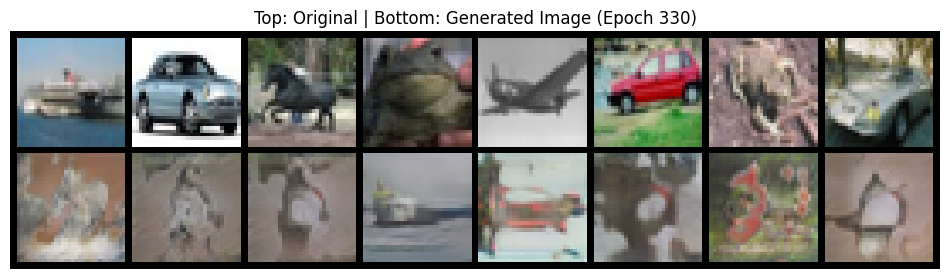

Epoch-331/1000: 100%|██████████| 782/782 [00:21<00:00, 36.82it/s, GenLoss=2.58, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.5368389043280535
Discriminator Loss: 0.5491853496607613


Epoch-332/1000: 100%|██████████| 782/782 [00:14<00:00, 52.39it/s, GenLoss=1.69, DisLoss=0.752, DisSteps=1] 


Generator Loss: 1.4389481718659096
Discriminator Loss: 0.562131678280623


Epoch-333/1000: 100%|██████████| 782/782 [00:24<00:00, 31.44it/s, GenLoss=2.55, DisLoss=0.465, DisSteps=1] 


Generator Loss: 1.5360326600425385
Discriminator Loss: 0.549146475732479


Epoch-334/1000: 100%|██████████| 782/782 [00:29<00:00, 26.62it/s, GenLoss=2.53, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.470418150467641
Discriminator Loss: 0.5675207116376714


Epoch-335/1000: 100%|██████████| 782/782 [00:27<00:00, 28.95it/s, GenLoss=2.28, DisLoss=1.15, DisSteps=1]  


Generator Loss: 1.4433172452251624
Discriminator Loss: 0.583470827173394


Epoch-336/1000: 100%|██████████| 782/782 [00:27<00:00, 28.58it/s, GenLoss=4.16, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.4702470055626482
Discriminator Loss: 0.5605300979693527


Epoch-337/1000: 100%|██████████| 782/782 [00:17<00:00, 43.81it/s, GenLoss=4.9, DisLoss=1.57, DisSteps=1]   


Generator Loss: 1.5157642472354347
Discriminator Loss: 0.5528870702475843


Epoch-338/1000: 100%|██████████| 782/782 [00:26<00:00, 29.31it/s, GenLoss=2.01, DisLoss=2.24, DisSteps=1]  


Generator Loss: 1.5200486140482872
Discriminator Loss: 0.5289856080547013


Epoch-339/1000: 100%|██████████| 782/782 [00:21<00:00, 37.07it/s, GenLoss=3.59, DisLoss=0.762, DisSteps=1] 


Generator Loss: 1.6103210404248494
Discriminator Loss: 0.518991979567901


Epoch-340/1000: 100%|██████████| 782/782 [00:23<00:00, 32.62it/s, GenLoss=2.85, DisLoss=1.2, DisSteps=1]   


Generator Loss: 1.7371637982785548
Discriminator Loss: 0.4779417917437261


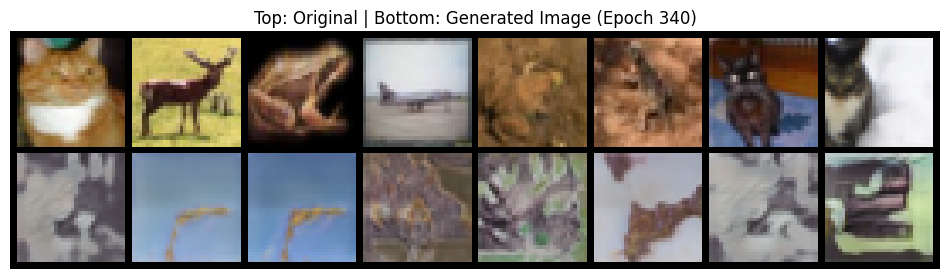

Epoch-341/1000: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s, GenLoss=4.56, DisLoss=0.589, DisSteps=1] 


Generator Loss: 1.6939248262006608
Discriminator Loss: 0.5048788061837102


Epoch-342/1000: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s, GenLoss=3.29, DisLoss=0.309, DisSteps=1] 


Generator Loss: 1.867015693651136
Discriminator Loss: 0.4805858383131454


Epoch-343/1000: 100%|██████████| 782/782 [00:30<00:00, 25.27it/s, GenLoss=3.26, DisLoss=0.803, DisSteps=1] 


Generator Loss: 1.6604614058114073
Discriminator Loss: 0.5177458756415131


Epoch-344/1000: 100%|██████████| 782/782 [00:18<00:00, 41.84it/s, GenLoss=4.04, DisLoss=0.27, DisSteps=1]  


Generator Loss: 1.5970265633614777
Discriminator Loss: 0.524909017602806


Epoch-345/1000: 100%|██████████| 782/782 [00:16<00:00, 46.03it/s, GenLoss=2.21, DisLoss=0.389, DisSteps=1] 


Generator Loss: 1.630658088590178
Discriminator Loss: 0.5361207820417936


Epoch-346/1000: 100%|██████████| 782/782 [00:17<00:00, 45.45it/s, GenLoss=1.6, DisLoss=1.83, DisSteps=1]   


Generator Loss: 1.655543391585655
Discriminator Loss: 0.5238316533205759


Epoch-347/1000: 100%|██████████| 782/782 [00:17<00:00, 44.58it/s, GenLoss=3.11, DisLoss=2.04, DisSteps=1]  


Generator Loss: 1.7449097447002027
Discriminator Loss: 0.5008360948556524


Epoch-348/1000: 100%|██████████| 782/782 [00:16<00:00, 47.89it/s, GenLoss=2.8, DisLoss=0.294, DisSteps=1]  


Generator Loss: 1.6413447790591003
Discriminator Loss: 0.4937125949946511


Epoch-349/1000: 100%|██████████| 782/782 [00:15<00:00, 50.46it/s, GenLoss=3.85, DisLoss=1.14, DisSteps=1]  


Generator Loss: 1.525386132395176
Discriminator Loss: 0.555593159154553


Epoch-350/1000: 100%|██████████| 782/782 [00:14<00:00, 53.73it/s, GenLoss=4.5, DisLoss=1.42, DisSteps=1]   


Generator Loss: 1.5284686727673196
Discriminator Loss: 0.5510313683153724


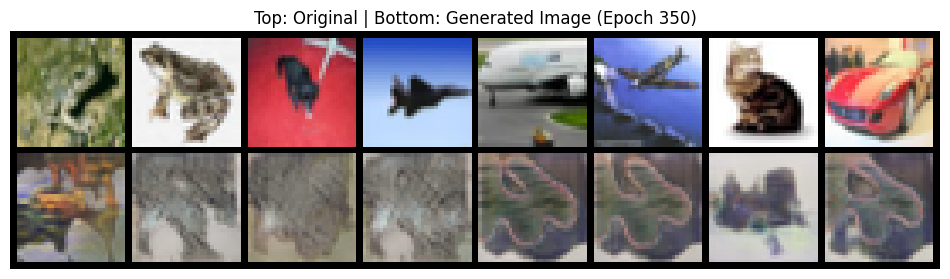

Epoch-351/1000: 100%|██████████| 782/782 [00:26<00:00, 29.61it/s, GenLoss=3.42, DisLoss=1.24, DisSteps=1]  


Generator Loss: 1.4721980404747113
Discriminator Loss: 0.5763320055078057


Epoch-352/1000: 100%|██████████| 782/782 [00:14<00:00, 53.25it/s, GenLoss=3.14, DisLoss=1.4, DisSteps=1]   


Generator Loss: 1.49156357618549
Discriminator Loss: 0.581766543752702


Epoch-353/1000: 100%|██████████| 782/782 [00:14<00:00, 53.86it/s, GenLoss=2.39, DisLoss=0.589, DisSteps=1] 


Generator Loss: 1.4995043898939782
Discriminator Loss: 0.5585652118753595


Epoch-354/1000: 100%|██████████| 782/782 [00:15<00:00, 51.10it/s, GenLoss=4.69, DisLoss=0.637, DisSteps=1] 


Generator Loss: 1.5146572070048594
Discriminator Loss: 0.5556493983854114


Epoch-355/1000: 100%|██████████| 782/782 [00:15<00:00, 49.53it/s, GenLoss=3.98, DisLoss=1.18, DisSteps=1]  


Generator Loss: 1.5634869665593443
Discriminator Loss: 0.558188995132056


Epoch-356/1000: 100%|██████████| 782/782 [00:17<00:00, 45.02it/s, GenLoss=1.48, DisLoss=1.09, DisSteps=1]  


Generator Loss: 1.6345554398148872
Discriminator Loss: 0.5264634348433036


Epoch-357/1000: 100%|██████████| 782/782 [00:14<00:00, 52.31it/s, GenLoss=4.64, DisLoss=0.661, DisSteps=1] 


Generator Loss: 1.545398818791065
Discriminator Loss: 0.5344078442477205


Epoch-358/1000: 100%|██████████| 782/782 [00:14<00:00, 53.26it/s, GenLoss=4.41, DisLoss=1.39, DisSteps=1]  


Generator Loss: 1.6056332084376488
Discriminator Loss: 0.5409004538489119


Epoch-359/1000: 100%|██████████| 782/782 [00:14<00:00, 55.03it/s, GenLoss=3.51, DisLoss=1.23, DisSteps=1]  


Generator Loss: 1.4807981665024672
Discriminator Loss: 0.5464748192931075


Epoch-360/1000: 100%|██████████| 782/782 [00:22<00:00, 34.39it/s, GenLoss=1.87, DisLoss=1.08, DisSteps=1]  


Generator Loss: 1.5480697861946453
Discriminator Loss: 0.5352405801682216


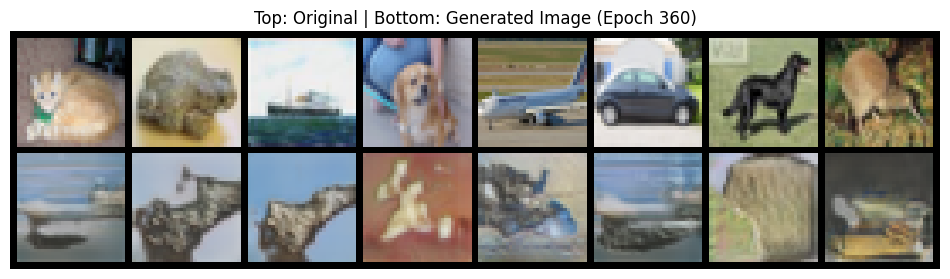

Epoch-361/1000: 100%|██████████| 782/782 [00:14<00:00, 55.01it/s, GenLoss=1.89, DisLoss=0.958, DisSteps=1] 


Generator Loss: 1.4603500419565478
Discriminator Loss: 0.5682647801421182


Epoch-362/1000: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s, GenLoss=1.65, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.598997333775396
Discriminator Loss: 0.51757111859596


Epoch-363/1000: 100%|██████████| 782/782 [00:13<00:00, 55.96it/s, GenLoss=2.99, DisLoss=0.255, DisSteps=1] 


Generator Loss: 1.6581804557605777
Discriminator Loss: 0.5184736800048967


Epoch-364/1000: 100%|██████████| 782/782 [00:23<00:00, 32.89it/s, GenLoss=1.29, DisLoss=1.69, DisSteps=1]  


Generator Loss: 1.5973860967875746
Discriminator Loss: 0.5233738166101448


Epoch-365/1000: 100%|██████████| 782/782 [00:20<00:00, 38.80it/s, GenLoss=2.37, DisLoss=0.495, DisSteps=1] 


Generator Loss: 1.6393142088752268
Discriminator Loss: 0.5184343752577482


Epoch-366/1000: 100%|██████████| 782/782 [00:28<00:00, 27.41it/s, GenLoss=5.02, DisLoss=1.75, DisSteps=1]  


Generator Loss: 1.6437543943867354
Discriminator Loss: 0.5094475309219202


Epoch-367/1000: 100%|██████████| 782/782 [00:13<00:00, 56.33it/s, GenLoss=3.7, DisLoss=0.608, DisSteps=1]  


Generator Loss: 1.826265815769315
Discriminator Loss: 0.47323622066727683


Epoch-368/1000: 100%|██████████| 782/782 [00:13<00:00, 56.00it/s, GenLoss=5.18, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.6006928835531025
Discriminator Loss: 0.5176004276365576


Epoch-369/1000: 100%|██████████| 782/782 [00:14<00:00, 54.98it/s, GenLoss=3.43, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.6162220961450007
Discriminator Loss: 0.5273067412702629


Epoch-370/1000: 100%|██████████| 782/782 [00:27<00:00, 28.13it/s, GenLoss=3.65, DisLoss=0.855, DisSteps=1] 


Generator Loss: 1.6324370809833106
Discriminator Loss: 0.5087605723944466


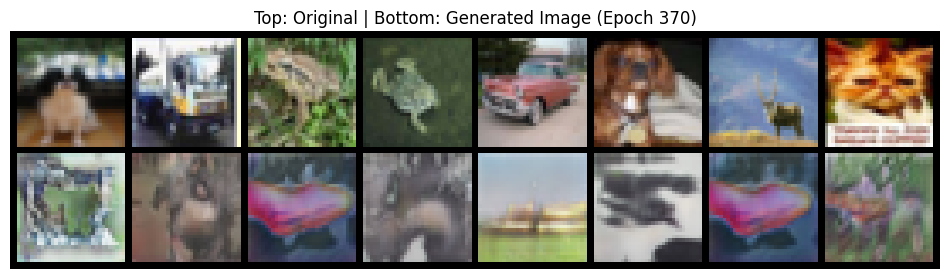

Epoch-371/1000: 100%|██████████| 782/782 [00:14<00:00, 54.05it/s, GenLoss=6.51, DisLoss=1.48, DisSteps=1]  


Generator Loss: 1.588195913626105
Discriminator Loss: 0.5314058007105537


Epoch-372/1000: 100%|██████████| 782/782 [00:15<00:00, 50.35it/s, GenLoss=3.4, DisLoss=1.08, DisSteps=1]   


Generator Loss: 1.5347103870585752
Discriminator Loss: 0.5263846078339744


Epoch-373/1000: 100%|██████████| 782/782 [00:14<00:00, 54.66it/s, GenLoss=3.65, DisLoss=0.37, DisSteps=1]  


Generator Loss: 1.5600049597451755
Discriminator Loss: 0.5491844397562239


Epoch-374/1000: 100%|██████████| 782/782 [00:18<00:00, 41.68it/s, GenLoss=2.32, DisLoss=0.803, DisSteps=1] 


Generator Loss: 1.5256210575475717
Discriminator Loss: 0.5367715275653487


Epoch-375/1000: 100%|██████████| 782/782 [00:14<00:00, 52.66it/s, GenLoss=2.54, DisLoss=0.494, DisSteps=1] 


Generator Loss: 1.6434411443484105
Discriminator Loss: 0.5105831856122407


Epoch-376/1000: 100%|██████████| 782/782 [00:15<00:00, 51.44it/s, GenLoss=1.85, DisLoss=0.416, DisSteps=1] 


Generator Loss: 1.5543900466788456
Discriminator Loss: 0.527677950118204


Epoch-377/1000: 100%|██████████| 782/782 [00:23<00:00, 32.94it/s, GenLoss=3.58, DisLoss=1.46, DisSteps=1]  


Generator Loss: 1.6235698211528455
Discriminator Loss: 0.5343089862285978


Epoch-378/1000: 100%|██████████| 782/782 [00:31<00:00, 24.45it/s, GenLoss=2.75, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.5852919754088688
Discriminator Loss: 0.5351201054995017


Epoch-379/1000: 100%|██████████| 782/782 [00:25<00:00, 30.24it/s, GenLoss=3.74, DisLoss=0.348, DisSteps=1] 


Generator Loss: 1.4339946391599259
Discriminator Loss: 0.5543834046101022


Epoch-380/1000: 100%|██████████| 782/782 [00:15<00:00, 50.00it/s, GenLoss=3.14, DisLoss=0.475, DisSteps=1] 


Generator Loss: 1.5555740753784204
Discriminator Loss: 0.5234202434644675


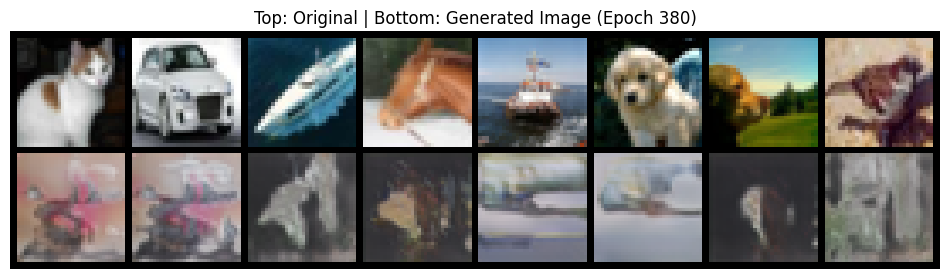

Epoch-381/1000: 100%|██████████| 782/782 [00:20<00:00, 38.98it/s, GenLoss=2.87, DisLoss=1.23, DisSteps=1]  


Generator Loss: 1.602621027042189
Discriminator Loss: 0.5160969107237923


Epoch-382/1000: 100%|██████████| 782/782 [00:14<00:00, 54.89it/s, GenLoss=2.32, DisLoss=0.777, DisSteps=1] 


Generator Loss: 1.5924869765101186
Discriminator Loss: 0.5355719169006323


Epoch-383/1000: 100%|██████████| 782/782 [00:14<00:00, 53.79it/s, GenLoss=3.29, DisLoss=0.826, DisSteps=1] 


Generator Loss: 1.536326664106925
Discriminator Loss: 0.5314760086176645


Epoch-384/1000: 100%|██████████| 782/782 [00:14<00:00, 54.35it/s, GenLoss=3.93, DisLoss=0.568, DisSteps=1] 


Generator Loss: 1.6792038240472373
Discriminator Loss: 0.4930429476339494


Epoch-385/1000: 100%|██████████| 782/782 [00:16<00:00, 47.99it/s, GenLoss=3.87, DisLoss=0.475, DisSteps=1] 


Generator Loss: 1.5776779336087845
Discriminator Loss: 0.5086864286562061


Epoch-386/1000: 100%|██████████| 782/782 [00:26<00:00, 30.03it/s, GenLoss=3.69, DisLoss=0.662, DisSteps=1] 


Generator Loss: 1.5673970428421675
Discriminator Loss: 0.5484754826749683


Epoch-387/1000: 100%|██████████| 782/782 [00:14<00:00, 52.46it/s, GenLoss=3.52, DisLoss=0.596, DisSteps=1] 


Generator Loss: 1.4980211739649858
Discriminator Loss: 0.5474231536011867


Epoch-388/1000: 100%|██████████| 782/782 [00:14<00:00, 54.01it/s, GenLoss=7.48, DisLoss=1.44, DisSteps=1]  


Generator Loss: 1.579242289980964
Discriminator Loss: 0.5463753535467035


Epoch-389/1000: 100%|██████████| 782/782 [00:14<00:00, 55.71it/s, GenLoss=2.71, DisLoss=0.452, DisSteps=1] 


Generator Loss: 1.4817545472660942
Discriminator Loss: 0.5509463448811065


Epoch-390/1000: 100%|██████████| 782/782 [00:21<00:00, 37.07it/s, GenLoss=7.72, DisLoss=1.08, DisSteps=1]  


Generator Loss: 1.6844157960713673
Discriminator Loss: 0.49853738810857545


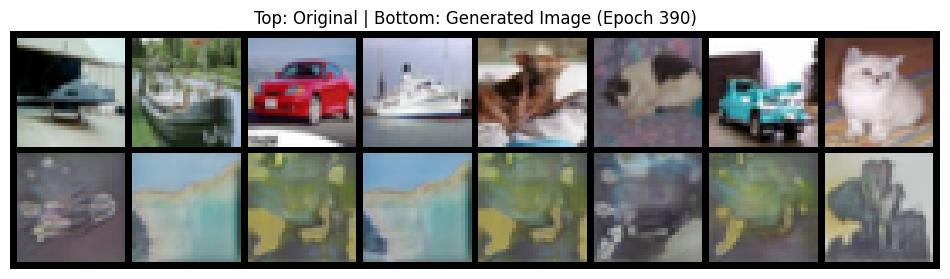

Epoch-391/1000: 100%|██████████| 782/782 [00:14<00:00, 53.56it/s, GenLoss=3.72, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.6894361404201867
Discriminator Loss: 0.5025818928733201


Epoch-392/1000: 100%|██████████| 782/782 [00:14<00:00, 55.06it/s, GenLoss=2.87, DisLoss=1.26, DisSteps=1]  


Generator Loss: 1.6853592993353335
Discriminator Loss: 0.5174340212055485


Epoch-393/1000: 100%|██████████| 782/782 [00:14<00:00, 53.97it/s, GenLoss=3.86, DisLoss=0.852, DisSteps=1] 


Generator Loss: 1.590446781967302
Discriminator Loss: 0.5121180552541448


Epoch-394/1000: 100%|██████████| 782/782 [00:14<00:00, 53.50it/s, GenLoss=1.36, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.602333412679565
Discriminator Loss: 0.5097004501220516


Epoch-395/1000: 100%|██████████| 782/782 [00:19<00:00, 40.13it/s, GenLoss=2.17, DisLoss=1.06, DisSteps=1]  


Generator Loss: 1.5467374796986275
Discriminator Loss: 0.5339631496183098


Epoch-396/1000: 100%|██████████| 782/782 [00:19<00:00, 39.76it/s, GenLoss=2.2, DisLoss=0.625, DisSteps=1]  


Generator Loss: 1.5966697059324026
Discriminator Loss: 0.5264114279423833


Epoch-397/1000: 100%|██████████| 782/782 [00:19<00:00, 39.37it/s, GenLoss=2.37, DisLoss=0.468, DisSteps=1] 


Generator Loss: 1.5716204474039395
Discriminator Loss: 0.5298345665949995


Epoch-398/1000: 100%|██████████| 782/782 [00:22<00:00, 35.46it/s, GenLoss=4.31, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.5582460645214675
Discriminator Loss: 0.5331407789226688


Epoch-399/1000: 100%|██████████| 782/782 [00:14<00:00, 53.22it/s, GenLoss=7, DisLoss=0.951, DisSteps=1]    


Generator Loss: 1.6516694641860246
Discriminator Loss: 0.49126826819327785


Epoch-400/1000: 100%|██████████| 782/782 [00:22<00:00, 34.97it/s, GenLoss=3.8, DisLoss=1.41, DisSteps=1]   


Generator Loss: 1.57256534764224
Discriminator Loss: 0.5339691028799243


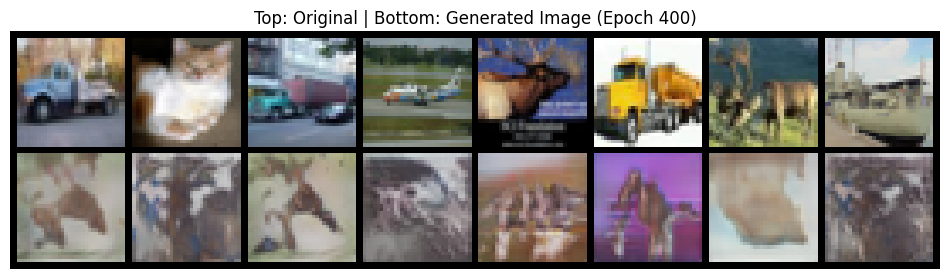

Epoch-401/1000: 100%|██████████| 782/782 [00:33<00:00, 23.58it/s, GenLoss=4.07, DisLoss=0.958, DisSteps=1] 


Generator Loss: 1.5498995601444903
Discriminator Loss: 0.5319229420226859


Epoch-402/1000: 100%|██████████| 782/782 [00:29<00:00, 26.18it/s, GenLoss=4.42, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.6089713299061026
Discriminator Loss: 0.5315523630632158


Epoch-403/1000: 100%|██████████| 782/782 [00:24<00:00, 32.23it/s, GenLoss=3.46, DisLoss=2.03, DisSteps=1]  


Generator Loss: 1.689209150155182
Discriminator Loss: 0.5046526628077183


Epoch-404/1000: 100%|██████████| 782/782 [00:15<00:00, 52.00it/s, GenLoss=2.61, DisLoss=1.52, DisSteps=1]  


Generator Loss: 1.6674459226372298
Discriminator Loss: 0.5147738863173348


Epoch-405/1000: 100%|██████████| 782/782 [00:15<00:00, 51.08it/s, GenLoss=2.53, DisLoss=0.674, DisSteps=1] 


Generator Loss: 1.6113850338684628
Discriminator Loss: 0.5151331946253777


Epoch-406/1000: 100%|██████████| 782/782 [00:14<00:00, 52.38it/s, GenLoss=3.57, DisLoss=0.562, DisSteps=1] 


Generator Loss: 1.4975612491293027
Discriminator Loss: 0.5587339042626378


Epoch-407/1000: 100%|██████████| 782/782 [00:15<00:00, 52.11it/s, GenLoss=4.22, DisLoss=0.455, DisSteps=1] 


Generator Loss: 1.7041250926530576
Discriminator Loss: 0.4932721465673593


Epoch-408/1000: 100%|██████████| 782/782 [00:14<00:00, 53.10it/s, GenLoss=6.6, DisLoss=1.46, DisSteps=1]   


Generator Loss: 1.7388028634707335
Discriminator Loss: 0.5001826005823472


Epoch-409/1000: 100%|██████████| 782/782 [00:18<00:00, 41.51it/s, GenLoss=3.09, DisLoss=1.26, DisSteps=1]  


Generator Loss: 1.583915756410345
Discriminator Loss: 0.5271757670185145


Epoch-410/1000: 100%|██████████| 782/782 [00:14<00:00, 54.47it/s, GenLoss=4.48, DisLoss=0.618, DisSteps=1] 


Generator Loss: 1.665691671126029
Discriminator Loss: 0.5112016679495192


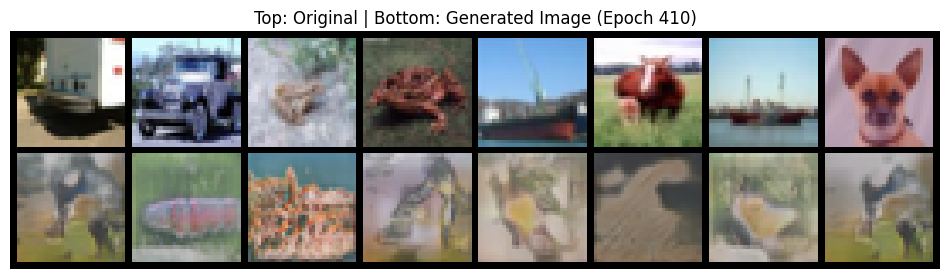

Epoch-411/1000: 100%|██████████| 782/782 [00:14<00:00, 54.84it/s, GenLoss=1.61, DisLoss=1.65, DisSteps=1]  


Generator Loss: 1.521159799431291
Discriminator Loss: 0.5448479906982168


Epoch-412/1000: 100%|██████████| 782/782 [00:24<00:00, 31.63it/s, GenLoss=4.76, DisLoss=0.637, DisSteps=1] 


Generator Loss: 1.6614235766860834
Discriminator Loss: 0.5019821027660614


Epoch-413/1000: 100%|██████████| 782/782 [00:29<00:00, 26.09it/s, GenLoss=3.45, DisLoss=1.06, DisSteps=1]  


Generator Loss: 1.638268943714059
Discriminator Loss: 0.4978207580916717


Epoch-414/1000: 100%|██████████| 782/782 [00:28<00:00, 26.97it/s, GenLoss=3.31, DisLoss=1.41, DisSteps=1]  


Generator Loss: 1.7138753886265523
Discriminator Loss: 0.5279276916742934


Epoch-415/1000: 100%|██████████| 782/782 [00:19<00:00, 40.60it/s, GenLoss=4.19, DisLoss=1.4, DisSteps=1]   


Generator Loss: 1.6059805761517771
Discriminator Loss: 0.5201752626949259


Epoch-416/1000: 100%|██████████| 782/782 [00:20<00:00, 38.17it/s, GenLoss=2.24, DisLoss=0.44, DisSteps=1]  


Generator Loss: 1.5680937691570243
Discriminator Loss: 0.5252710702397939


Epoch-417/1000: 100%|██████████| 782/782 [00:22<00:00, 34.48it/s, GenLoss=6.24, DisLoss=2.06, DisSteps=1]  


Generator Loss: 1.618395853759078
Discriminator Loss: 0.5177416719134201


Epoch-418/1000: 100%|██████████| 782/782 [00:20<00:00, 37.93it/s, GenLoss=2.78, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.5998197300431063
Discriminator Loss: 0.5224325173841718


Epoch-419/1000: 100%|██████████| 782/782 [00:15<00:00, 51.07it/s, GenLoss=0.841, DisLoss=1.69, DisSteps=1] 


Generator Loss: 1.507028307489422
Discriminator Loss: 0.5444951911868952


Epoch-420/1000: 100%|██████████| 782/782 [00:14<00:00, 55.78it/s, GenLoss=1.4, DisLoss=0.519, DisSteps=1]  


Generator Loss: 1.5930250557639716
Discriminator Loss: 0.5177350576843143


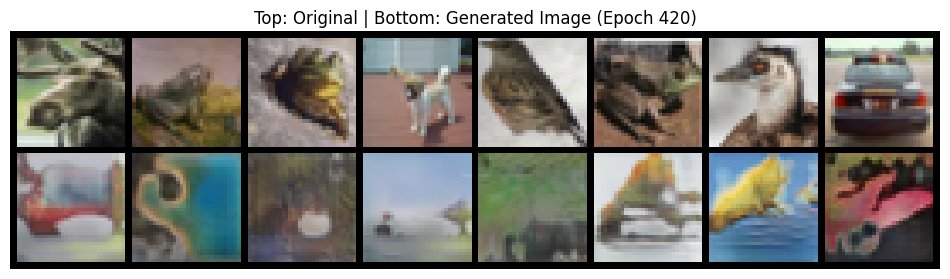

Epoch-421/1000: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s, GenLoss=2.74, DisLoss=0.506, DisSteps=1] 


Generator Loss: 1.6525585042393727
Discriminator Loss: 0.5069780014360042


Epoch-422/1000: 100%|██████████| 782/782 [00:14<00:00, 53.42it/s, GenLoss=2.96, DisLoss=0.925, DisSteps=1] 


Generator Loss: 1.7237183616289398
Discriminator Loss: 0.49581120755818797


Epoch-423/1000: 100%|██████████| 782/782 [00:14<00:00, 54.15it/s, GenLoss=4.32, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.760525425719788
Discriminator Loss: 0.4752517252817483


Epoch-424/1000: 100%|██████████| 782/782 [00:14<00:00, 55.31it/s, GenLoss=1.32, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.6790600678576229
Discriminator Loss: 0.5022292191453297


Epoch-425/1000: 100%|██████████| 782/782 [00:19<00:00, 41.14it/s, GenLoss=6.37, DisLoss=1.72, DisSteps=1]  


Generator Loss: 1.6495958642124215
Discriminator Loss: 0.5117684316147318


Epoch-426/1000: 100%|██████████| 782/782 [00:14<00:00, 54.78it/s, GenLoss=3.65, DisLoss=2.55, DisSteps=1]  


Generator Loss: 1.5999582369461693
Discriminator Loss: 0.5123080103026937


Epoch-427/1000: 100%|██████████| 782/782 [00:28<00:00, 27.02it/s, GenLoss=2.51, DisLoss=0.47, DisSteps=1]  


Generator Loss: 1.6911948575540576
Discriminator Loss: 0.49604075127626623


Epoch-428/1000: 100%|██████████| 782/782 [00:23<00:00, 32.63it/s, GenLoss=6.05, DisLoss=0.452, DisSteps=1] 


Generator Loss: 1.8460394504963589
Discriminator Loss: 0.4417294111398175


Epoch-429/1000: 100%|██████████| 782/782 [00:24<00:00, 32.00it/s, GenLoss=2.5, DisLoss=1.65, DisSteps=1]   


Generator Loss: 1.6830490878628344
Discriminator Loss: 0.5197711173835617


Epoch-430/1000: 100%|██████████| 782/782 [00:27<00:00, 28.38it/s, GenLoss=1.57, DisLoss=0.846, DisSteps=1] 


Generator Loss: 1.6583511841190441
Discriminator Loss: 0.49106291290896625


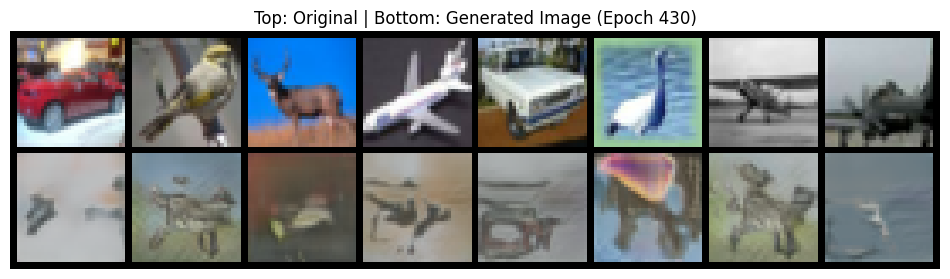

Epoch-431/1000: 100%|██████████| 782/782 [00:21<00:00, 36.52it/s, GenLoss=4.17, DisLoss=0.894, DisSteps=1] 


Generator Loss: 1.7102460433607516
Discriminator Loss: 0.4884090707887469


Epoch-432/1000: 100%|██████████| 782/782 [00:14<00:00, 55.66it/s, GenLoss=3.59, DisLoss=0.663, DisSteps=1] 


Generator Loss: 1.6853690505637537
Discriminator Loss: 0.4946488787794052


Epoch-433/1000: 100%|██████████| 782/782 [00:14<00:00, 54.89it/s, GenLoss=2.67, DisLoss=0.427, DisSteps=1] 


Generator Loss: 1.7817402446209012
Discriminator Loss: 0.46866457690210905


Epoch-434/1000: 100%|██████████| 782/782 [00:23<00:00, 33.27it/s, GenLoss=4.12, DisLoss=2.03, DisSteps=1]  


Generator Loss: 1.6011052279521132
Discriminator Loss: 0.5420149573889534


Epoch-435/1000: 100%|██████████| 782/782 [00:15<00:00, 50.33it/s, GenLoss=4.27, DisLoss=0.371, DisSteps=1] 


Generator Loss: 1.688296473773239
Discriminator Loss: 0.49499951139130555


Epoch-436/1000: 100%|██████████| 782/782 [00:17<00:00, 43.57it/s, GenLoss=6.11, DisLoss=1.22, DisSteps=1]  


Generator Loss: 1.8529641754791866
Discriminator Loss: 0.47035243857623366


Epoch-437/1000: 100%|██████████| 782/782 [00:14<00:00, 54.17it/s, GenLoss=4.59, DisLoss=0.674, DisSteps=1] 


Generator Loss: 1.7726901058117142
Discriminator Loss: 0.4827224395006819


Epoch-438/1000: 100%|██████████| 782/782 [00:14<00:00, 53.71it/s, GenLoss=1.73, DisLoss=0.69, DisSteps=1]  


Generator Loss: 1.6113291969689567
Discriminator Loss: 0.5057127247457309


Epoch-439/1000: 100%|██████████| 782/782 [00:14<00:00, 53.53it/s, GenLoss=4.15, DisLoss=1.39, DisSteps=1]  


Generator Loss: 1.6281563324086807
Discriminator Loss: 0.5244576869451482


Epoch-440/1000: 100%|██████████| 782/782 [00:17<00:00, 44.92it/s, GenLoss=4.69, DisLoss=2.53, DisSteps=1]  


Generator Loss: 1.6292402918076576
Discriminator Loss: 0.5220654452472087


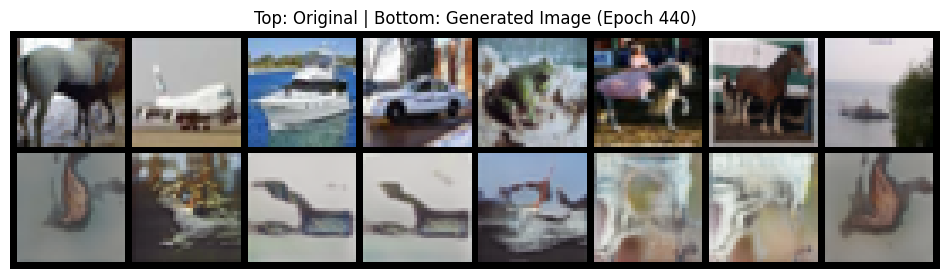

Epoch-441/1000: 100%|██████████| 782/782 [00:18<00:00, 42.61it/s, GenLoss=2.52, DisLoss=0.352, DisSteps=1] 


Generator Loss: 1.6450660269507362
Discriminator Loss: 0.5111997574377243


Epoch-442/1000: 100%|██████████| 782/782 [00:23<00:00, 33.23it/s, GenLoss=2.03, DisLoss=1.03, DisSteps=1]  


Generator Loss: 1.5788092172283041
Discriminator Loss: 0.5433240972859475


Epoch-443/1000: 100%|██████████| 782/782 [00:23<00:00, 33.01it/s, GenLoss=3.25, DisLoss=0.908, DisSteps=1] 


Generator Loss: 1.7151406644402867
Discriminator Loss: 0.4896476382146711


Epoch-444/1000: 100%|██████████| 782/782 [00:18<00:00, 41.79it/s, GenLoss=2.29, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.7151869659686028
Discriminator Loss: 0.5171599725590033


Epoch-445/1000: 100%|██████████| 782/782 [00:13<00:00, 56.11it/s, GenLoss=2.35, DisLoss=1.81, DisSteps=1]  


Generator Loss: 1.6126797127220638
Discriminator Loss: 0.5302132401053253


Epoch-446/1000: 100%|██████████| 782/782 [00:15<00:00, 50.37it/s, GenLoss=2.64, DisLoss=0.927, DisSteps=1] 


Generator Loss: 1.5435166651635523
Discriminator Loss: 0.5409888624763854


Epoch-447/1000: 100%|██████████| 782/782 [00:23<00:00, 33.81it/s, GenLoss=3.53, DisLoss=0.374, DisSteps=1] 


Generator Loss: 1.568251821886548
Discriminator Loss: 0.5490019982085204


Epoch-448/1000: 100%|██████████| 782/782 [00:22<00:00, 35.24it/s, GenLoss=2.96, DisLoss=0.684, DisSteps=1] 


Generator Loss: 1.5193644959069883
Discriminator Loss: 0.5491168317968583


Epoch-449/1000: 100%|██████████| 782/782 [00:27<00:00, 28.20it/s, GenLoss=3.57, DisLoss=1.32, DisSteps=1]  


Generator Loss: 1.6220584163809066
Discriminator Loss: 0.5096968758251051


Epoch-450/1000: 100%|██████████| 782/782 [00:14<00:00, 52.94it/s, GenLoss=3.6, DisLoss=0.251, DisSteps=1]  


Generator Loss: 1.5574015827511278
Discriminator Loss: 0.5290345686399723


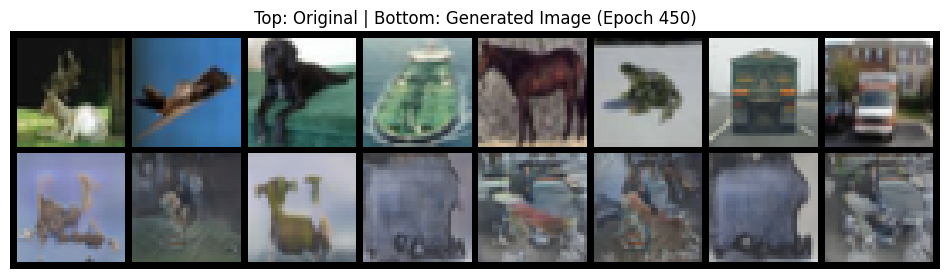

Epoch-451/1000: 100%|██████████| 782/782 [00:22<00:00, 34.91it/s, GenLoss=4.61, DisLoss=0.442, DisSteps=1] 


Generator Loss: 1.5192762574423915
Discriminator Loss: 0.5363628915737352


Epoch-452/1000: 100%|██████████| 782/782 [00:14<00:00, 53.47it/s, GenLoss=5.67, DisLoss=1.29, DisSteps=1]  


Generator Loss: 1.6371926932841006
Discriminator Loss: 0.5076025418194053


Epoch-453/1000: 100%|██████████| 782/782 [00:14<00:00, 54.75it/s, GenLoss=3.97, DisLoss=1.55, DisSteps=1]  


Generator Loss: 1.5661175085226897
Discriminator Loss: 0.5252280060173301


Epoch-454/1000: 100%|██████████| 782/782 [00:14<00:00, 54.63it/s, GenLoss=4.2, DisLoss=0.489, DisSteps=1]  


Generator Loss: 1.5932964405897634
Discriminator Loss: 0.5336420453151168


Epoch-455/1000: 100%|██████████| 782/782 [00:13<00:00, 55.95it/s, GenLoss=2.49, DisLoss=0.791, DisSteps=1] 


Generator Loss: 1.6856457773224471
Discriminator Loss: 0.49821182532840985


Epoch-456/1000: 100%|██████████| 782/782 [00:14<00:00, 52.83it/s, GenLoss=2.31, DisLoss=0.847, DisSteps=1] 


Generator Loss: 1.6093959924205186
Discriminator Loss: 0.5414295519137626


Epoch-457/1000: 100%|██████████| 782/782 [00:24<00:00, 32.34it/s, GenLoss=3.78, DisLoss=1.83, DisSteps=1]  


Generator Loss: 1.566326470554942
Discriminator Loss: 0.5243942636396269


Epoch-458/1000: 100%|██████████| 782/782 [00:18<00:00, 42.86it/s, GenLoss=2.55, DisLoss=0.99, DisSteps=1]  


Generator Loss: 1.5635932268541488
Discriminator Loss: 0.5388993126009126


Epoch-459/1000: 100%|██████████| 782/782 [00:27<00:00, 28.83it/s, GenLoss=2.61, DisLoss=0.779, DisSteps=1] 


Generator Loss: 1.6027892469750036
Discriminator Loss: 0.530844360875809


Epoch-460/1000: 100%|██████████| 782/782 [00:17<00:00, 45.49it/s, GenLoss=3.18, DisLoss=1.22, DisSteps=1]  


Generator Loss: 1.5094289995367876
Discriminator Loss: 0.5505683713251978


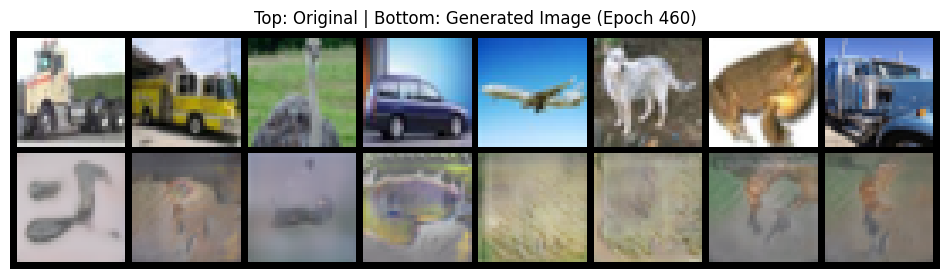

Epoch-461/1000: 100%|██████████| 782/782 [00:13<00:00, 56.29it/s, GenLoss=2.98, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.62796737752912
Discriminator Loss: 0.5278174684709295


Epoch-462/1000: 100%|██████████| 782/782 [00:23<00:00, 33.90it/s, GenLoss=4.73, DisLoss=0.741, DisSteps=1] 


Generator Loss: 1.7010597305377122
Discriminator Loss: 0.49061131475450437


Epoch-463/1000: 100%|██████████| 782/782 [00:28<00:00, 27.37it/s, GenLoss=1.69, DisLoss=0.58, DisSteps=1]  


Generator Loss: 1.5709248821982338
Discriminator Loss: 0.5417040232426066


Epoch-464/1000: 100%|██████████| 782/782 [00:26<00:00, 29.68it/s, GenLoss=4.01, DisLoss=0.719, DisSteps=1] 


Generator Loss: 1.6028376929366681
Discriminator Loss: 0.510596724365221


Epoch-465/1000: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s, GenLoss=5.62, DisLoss=0.949, DisSteps=1] 


Generator Loss: 1.6484944434345836
Discriminator Loss: 0.5043736203094883


Epoch-466/1000: 100%|██████████| 782/782 [00:14<00:00, 53.95it/s, GenLoss=2.36, DisLoss=0.383, DisSteps=1] 


Generator Loss: 1.5544249972190394
Discriminator Loss: 0.5165474218556948


Epoch-467/1000: 100%|██████████| 782/782 [00:14<00:00, 53.59it/s, GenLoss=3.18, DisLoss=0.453, DisSteps=1] 


Generator Loss: 1.5915109327687023
Discriminator Loss: 0.5231207263896532


Epoch-468/1000: 100%|██████████| 782/782 [00:13<00:00, 55.86it/s, GenLoss=3.42, DisLoss=0.557, DisSteps=1] 


Generator Loss: 1.595891876674979
Discriminator Loss: 0.5270286847258467


Epoch-469/1000: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s, GenLoss=2.58, DisLoss=0.76, DisSteps=1]  


Generator Loss: 1.6273571094664772
Discriminator Loss: 0.5150060507914295


Epoch-470/1000: 100%|██████████| 782/782 [00:26<00:00, 29.23it/s, GenLoss=2.74, DisLoss=0.651, DisSteps=1] 


Generator Loss: 1.6705257492449583
Discriminator Loss: 0.5021652716314396


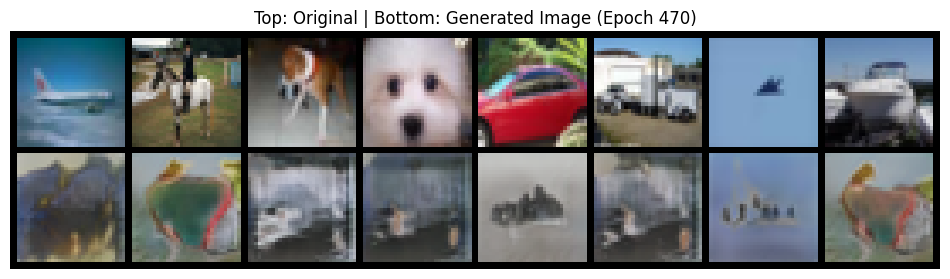

Epoch-471/1000: 100%|██████████| 782/782 [00:22<00:00, 34.55it/s, GenLoss=2.52, DisLoss=0.974, DisSteps=1] 


Generator Loss: 1.6476831463977808
Discriminator Loss: 0.5011595564768138


Epoch-472/1000: 100%|██████████| 782/782 [00:20<00:00, 38.11it/s, GenLoss=8.14, DisLoss=1.63, DisSteps=1]  


Generator Loss: 1.8003835888469921
Discriminator Loss: 0.47984086400102777


Epoch-473/1000: 100%|██████████| 782/782 [00:30<00:00, 25.55it/s, GenLoss=1.3, DisLoss=0.991, DisSteps=1]  


Generator Loss: 1.6300244950272542
Discriminator Loss: 0.5102735577375078


Epoch-474/1000: 100%|██████████| 782/782 [00:31<00:00, 25.10it/s, GenLoss=3.84, DisLoss=1.98, DisSteps=1]  


Generator Loss: 1.4585279255648098
Discriminator Loss: 0.5666924772969902


Epoch-475/1000: 100%|██████████| 782/782 [00:14<00:00, 54.80it/s, GenLoss=4.51, DisLoss=0.471, DisSteps=1] 


Generator Loss: 1.6122498572482478
Discriminator Loss: 0.514381330908107


Epoch-476/1000: 100%|██████████| 782/782 [00:14<00:00, 55.06it/s, GenLoss=4.06, DisLoss=1.37, DisSteps=1]  


Generator Loss: 1.591200200645515
Discriminator Loss: 0.5239065782264676


Epoch-477/1000: 100%|██████████| 782/782 [00:14<00:00, 53.30it/s, GenLoss=3.86, DisLoss=0.501, DisSteps=1] 


Generator Loss: 1.4579460204714705
Discriminator Loss: 0.5696483733861343


Epoch-478/1000: 100%|██████████| 782/782 [00:14<00:00, 54.50it/s, GenLoss=2.42, DisLoss=0.797, DisSteps=1] 


Generator Loss: 1.5573478678760626
Discriminator Loss: 0.5397391098806316


Epoch-479/1000: 100%|██████████| 782/782 [00:14<00:00, 54.67it/s, GenLoss=3.8, DisLoss=2.2, DisSteps=1]    


Generator Loss: 1.6004585406511946
Discriminator Loss: 0.5167433575672262


Epoch-480/1000: 100%|██████████| 782/782 [00:16<00:00, 46.67it/s, GenLoss=4.76, DisLoss=0.88, DisSteps=1]  


Generator Loss: 1.5352865047085926
Discriminator Loss: 0.538949564213643


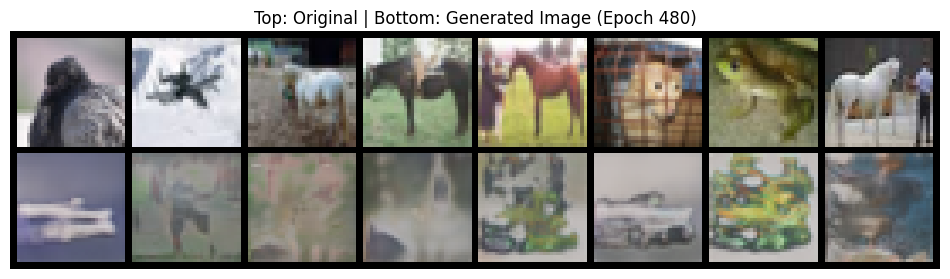

Epoch-481/1000: 100%|██████████| 782/782 [00:15<00:00, 51.58it/s, GenLoss=4.5, DisLoss=0.576, DisSteps=1]  


Generator Loss: 1.7117901615550757
Discriminator Loss: 0.48583542145883946


Epoch-482/1000: 100%|██████████| 782/782 [00:19<00:00, 40.53it/s, GenLoss=2.59, DisLoss=1.56, DisSteps=1]  


Generator Loss: 1.602575091373585
Discriminator Loss: 0.5287415070263931


Epoch-483/1000: 100%|██████████| 782/782 [00:22<00:00, 34.00it/s, GenLoss=3.37, DisLoss=0.796, DisSteps=1] 


Generator Loss: 1.6294507692994364
Discriminator Loss: 0.5094662865866786


Epoch-484/1000: 100%|██████████| 782/782 [00:16<00:00, 46.26it/s, GenLoss=3.78, DisLoss=1.87, DisSteps=1]  


Generator Loss: 1.665191599551369
Discriminator Loss: 0.48998483403793075


Epoch-485/1000: 100%|██████████| 782/782 [00:26<00:00, 29.55it/s, GenLoss=1.82, DisLoss=1.93, DisSteps=1]  


Generator Loss: 1.5051704672977442
Discriminator Loss: 0.5668044298544259


Epoch-486/1000: 100%|██████████| 782/782 [00:17<00:00, 44.85it/s, GenLoss=1.55, DisLoss=1.27, DisSteps=1]  


Generator Loss: 1.6496219422353808
Discriminator Loss: 0.5156646763996395


Epoch-487/1000: 100%|██████████| 782/782 [00:21<00:00, 35.79it/s, GenLoss=4.46, DisLoss=0.453, DisSteps=1] 


Generator Loss: 1.6370075488334421
Discriminator Loss: 0.5385366939484616


Epoch-488/1000: 100%|██████████| 782/782 [00:16<00:00, 46.59it/s, GenLoss=4.01, DisLoss=0.424, DisSteps=1] 


Generator Loss: 1.57241247541002
Discriminator Loss: 0.5249174116631908


Epoch-489/1000: 100%|██████████| 782/782 [00:14<00:00, 53.47it/s, GenLoss=2.69, DisLoss=1.11, DisSteps=1]  


Generator Loss: 1.5277458985748193
Discriminator Loss: 0.5711931224216891


Epoch-490/1000: 100%|██████████| 782/782 [00:18<00:00, 42.78it/s, GenLoss=2.67, DisLoss=0.788, DisSteps=1] 


Generator Loss: 1.5461609510662
Discriminator Loss: 0.5482191170763482


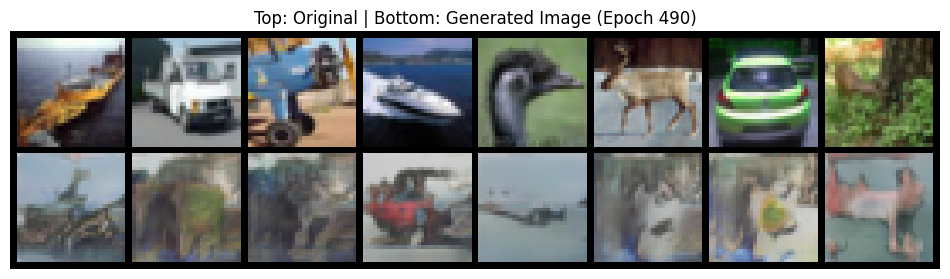

Epoch-491/1000: 100%|██████████| 782/782 [00:24<00:00, 31.60it/s, GenLoss=1.18, DisLoss=0.978, DisSteps=1] 


Generator Loss: 1.5940536852840268
Discriminator Loss: 0.5087949137782197


Epoch-492/1000: 100%|██████████| 782/782 [00:14<00:00, 54.14it/s, GenLoss=1.81, DisLoss=0.81, DisSteps=1]  


Generator Loss: 1.5945395063180143
Discriminator Loss: 0.5248702616642809


Epoch-493/1000: 100%|██████████| 782/782 [00:17<00:00, 43.57it/s, GenLoss=2.54, DisLoss=0.881, DisSteps=1] 


Generator Loss: 1.6916900381560216
Discriminator Loss: 0.5027423621634083


Epoch-494/1000: 100%|██████████| 782/782 [00:14<00:00, 54.76it/s, GenLoss=1.92, DisLoss=0.409, DisSteps=1] 


Generator Loss: 1.6350877318540802
Discriminator Loss: 0.496427185128412


Epoch-495/1000: 100%|██████████| 782/782 [00:15<00:00, 50.51it/s, GenLoss=2.48, DisLoss=1.35, DisSteps=1]  


Generator Loss: 1.6529657434472038
Discriminator Loss: 0.5040977895831513


Epoch-496/1000: 100%|██████████| 782/782 [00:14<00:00, 52.29it/s, GenLoss=2.76, DisLoss=0.366, DisSteps=1] 


Generator Loss: 1.5854454302726804
Discriminator Loss: 0.5009523661011626


Epoch-497/1000: 100%|██████████| 782/782 [00:13<00:00, 55.94it/s, GenLoss=4.52, DisLoss=0.742, DisSteps=1] 


Generator Loss: 1.6411866752997688
Discriminator Loss: 0.49883667082356675


Epoch-498/1000: 100%|██████████| 782/782 [00:21<00:00, 36.57it/s, GenLoss=4.16, DisLoss=0.846, DisSteps=1] 


Generator Loss: 1.6457169161885596
Discriminator Loss: 0.5261435098469714


Epoch-499/1000: 100%|██████████| 782/782 [00:16<00:00, 46.65it/s, GenLoss=2.91, DisLoss=0.753, DisSteps=1] 


Generator Loss: 1.5738660359702756
Discriminator Loss: 0.5315765460090869


Epoch-500/1000: 100%|██████████| 782/782 [00:15<00:00, 51.51it/s, GenLoss=7.07, DisLoss=0.937, DisSteps=1] 


Generator Loss: 1.6279088560577548
Discriminator Loss: 0.5248385269928466


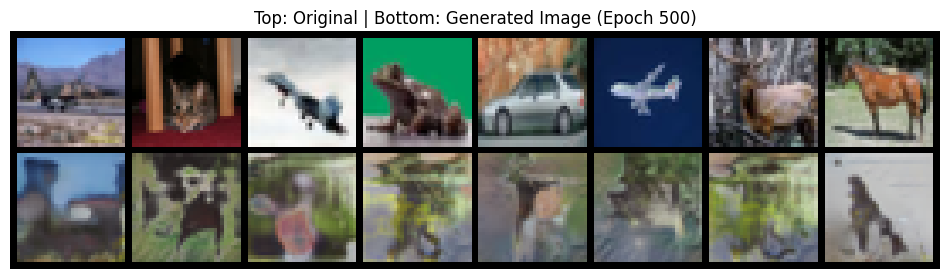

Epoch-501/1000: 100%|██████████| 782/782 [00:19<00:00, 39.76it/s, GenLoss=3.37, DisLoss=0.739, DisSteps=1] 


Generator Loss: 1.5403841226302144
Discriminator Loss: 0.5435940337264934


Epoch-502/1000: 100%|██████████| 782/782 [00:15<00:00, 50.36it/s, GenLoss=3.83, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.6012218096448332
Discriminator Loss: 0.5117999551927342


Epoch-503/1000: 100%|██████████| 782/782 [00:19<00:00, 40.32it/s, GenLoss=3.71, DisLoss=0.715, DisSteps=1] 


Generator Loss: 1.542571116743795
Discriminator Loss: 0.5304595727826018


Epoch-504/1000: 100%|██████████| 782/782 [00:21<00:00, 35.92it/s, GenLoss=1.87, DisLoss=0.588, DisSteps=1] 


Generator Loss: 1.6027365852804745
Discriminator Loss: 0.5155687626746609


Epoch-505/1000: 100%|██████████| 782/782 [00:14<00:00, 55.84it/s, GenLoss=0.873, DisLoss=1.65, DisSteps=1] 


Generator Loss: 1.5353732787434706
Discriminator Loss: 0.5379918061025307


Epoch-506/1000: 100%|██████████| 782/782 [00:14<00:00, 54.03it/s, GenLoss=2.99, DisLoss=0.598, DisSteps=1] 


Generator Loss: 1.5105891257067166
Discriminator Loss: 0.5401998060324308


Epoch-507/1000: 100%|██████████| 782/782 [00:14<00:00, 55.05it/s, GenLoss=4.35, DisLoss=1.01, DisSteps=1]  


Generator Loss: 1.6282373256314442
Discriminator Loss: 0.5362271401659607


Epoch-508/1000: 100%|██████████| 782/782 [00:14<00:00, 54.10it/s, GenLoss=3.43, DisLoss=0.481, DisSteps=1] 


Generator Loss: 1.7031853700537816
Discriminator Loss: 0.5046037584543228


Epoch-509/1000: 100%|██████████| 782/782 [00:13<00:00, 56.17it/s, GenLoss=4.16, DisLoss=1.3, DisSteps=1]   


Generator Loss: 1.5653138863079994
Discriminator Loss: 0.5197064758795301


Epoch-510/1000: 100%|██████████| 782/782 [00:15<00:00, 49.92it/s, GenLoss=3.44, DisLoss=1.49, DisSteps=1]  


Generator Loss: 1.5711336130528804
Discriminator Loss: 0.5356734496210237


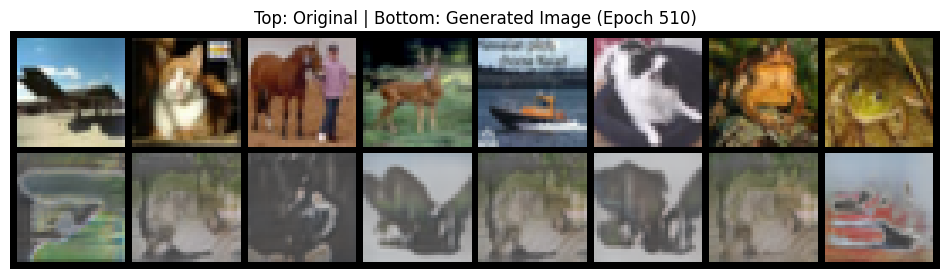

Epoch-511/1000: 100%|██████████| 782/782 [00:15<00:00, 51.27it/s, GenLoss=3.33, DisLoss=0.943, DisSteps=1] 


Generator Loss: 1.4787973829776124
Discriminator Loss: 0.5518349426634171


Epoch-512/1000: 100%|██████████| 782/782 [00:20<00:00, 37.82it/s, GenLoss=5.59, DisLoss=1.6, DisSteps=1]   


Generator Loss: 1.7616637708890774
Discriminator Loss: 0.4927627092889508


Epoch-513/1000: 100%|██████████| 782/782 [00:14<00:00, 54.77it/s, GenLoss=3.09, DisLoss=0.923, DisSteps=1] 


Generator Loss: 1.6060117248379056
Discriminator Loss: 0.5131822045501846


Epoch-514/1000: 100%|██████████| 782/782 [00:15<00:00, 51.99it/s, GenLoss=3, DisLoss=1.01, DisSteps=1]     


Generator Loss: 1.783960415198065
Discriminator Loss: 0.4639158362851423


Epoch-515/1000: 100%|██████████| 782/782 [00:14<00:00, 53.27it/s, GenLoss=2.68, DisLoss=2.72, DisSteps=1]  


Generator Loss: 1.6711400206893912
Discriminator Loss: 0.5172730565566541


Epoch-516/1000: 100%|██████████| 782/782 [00:14<00:00, 54.24it/s, GenLoss=1.52, DisLoss=0.853, DisSteps=1] 


Generator Loss: 1.615807382156477
Discriminator Loss: 0.49762177189140366


Epoch-517/1000: 100%|██████████| 782/782 [00:14<00:00, 52.76it/s, GenLoss=1.69, DisLoss=0.536, DisSteps=1] 


Generator Loss: 1.6817432827580616
Discriminator Loss: 0.48186892326301933


Epoch-518/1000: 100%|██████████| 782/782 [00:14<00:00, 55.04it/s, GenLoss=3.84, DisLoss=0.631, DisSteps=1] 


Generator Loss: 1.7150116739675516
Discriminator Loss: 0.4849527680012576


Epoch-519/1000: 100%|██████████| 782/782 [00:14<00:00, 54.78it/s, GenLoss=3.6, DisLoss=0.443, DisSteps=1]  


Generator Loss: 1.675373565815294
Discriminator Loss: 0.4935026361661799


Epoch-520/1000: 100%|██████████| 782/782 [00:21<00:00, 35.76it/s, GenLoss=5.31, DisLoss=0.739, DisSteps=1] 


Generator Loss: 1.6374491538538043
Discriminator Loss: 0.5078601638221985


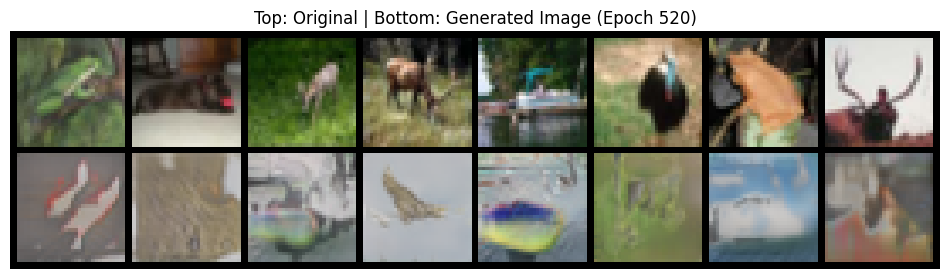

Epoch-521/1000: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s, GenLoss=2.55, DisLoss=1.28, DisSteps=1]  


Generator Loss: 1.4770460304473063
Discriminator Loss: 0.5527241746216174


Epoch-522/1000: 100%|██████████| 782/782 [00:24<00:00, 31.53it/s, GenLoss=5.43, DisLoss=1.16, DisSteps=1]  


Generator Loss: 1.6162135377716835
Discriminator Loss: 0.530866322157633


Epoch-523/1000: 100%|██████████| 782/782 [00:18<00:00, 42.49it/s, GenLoss=3.64, DisLoss=0.782, DisSteps=1] 


Generator Loss: 1.6178778368798667
Discriminator Loss: 0.5365749000740783


Epoch-524/1000: 100%|██████████| 782/782 [00:13<00:00, 55.90it/s, GenLoss=4.08, DisLoss=2.23, DisSteps=1]  


Generator Loss: 1.6298640726319968
Discriminator Loss: 0.5302571763506021


Epoch-525/1000: 100%|██████████| 782/782 [00:14<00:00, 55.13it/s, GenLoss=3.13, DisLoss=1.78, DisSteps=1]  


Generator Loss: 1.6403077235993218
Discriminator Loss: 0.5149346467326669


Epoch-526/1000: 100%|██████████| 782/782 [00:15<00:00, 51.72it/s, GenLoss=4.27, DisLoss=1.16, DisSteps=1]  


Generator Loss: 1.484860539703113
Discriminator Loss: 0.5601580729493705


Epoch-527/1000: 100%|██████████| 782/782 [00:18<00:00, 43.35it/s, GenLoss=4.57, DisLoss=1.03, DisSteps=1]  


Generator Loss: 1.5854970082602537
Discriminator Loss: 0.5397144525557223


Epoch-528/1000: 100%|██████████| 782/782 [00:15<00:00, 51.56it/s, GenLoss=4.9, DisLoss=0.684, DisSteps=1]  


Generator Loss: 1.6536995528832725
Discriminator Loss: 0.4999429407670065


Epoch-529/1000: 100%|██████████| 782/782 [00:14<00:00, 53.88it/s, GenLoss=2.74, DisLoss=1.44, DisSteps=1]  


Generator Loss: 1.7348589764150513
Discriminator Loss: 0.4683665349850874


Epoch-530/1000: 100%|██████████| 782/782 [00:14<00:00, 55.18it/s, GenLoss=1.4, DisLoss=1.4, DisSteps=1]    


Generator Loss: 1.6610047188408845
Discriminator Loss: 0.5310320975187489


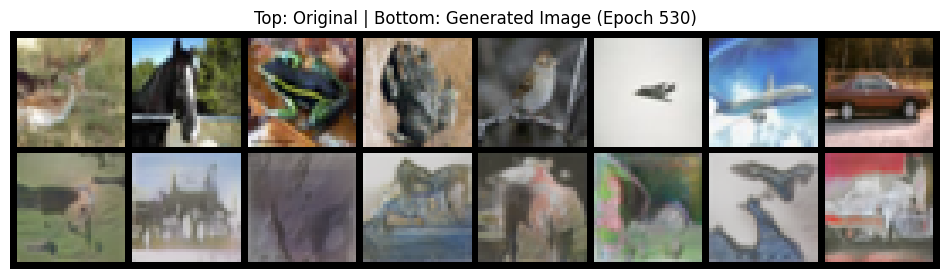

Epoch-531/1000: 100%|██████████| 782/782 [00:16<00:00, 47.60it/s, GenLoss=2.73, DisLoss=0.764, DisSteps=1] 


Generator Loss: 1.750849756819513
Discriminator Loss: 0.47451589597613003


Epoch-532/1000: 100%|██████████| 782/782 [00:14<00:00, 55.12it/s, GenLoss=3.75, DisLoss=0.222, DisSteps=1] 


Generator Loss: 1.8713966540210998
Discriminator Loss: 0.44841165375679043


Epoch-533/1000: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s, GenLoss=2.53, DisLoss=1.55, DisSteps=1]  


Generator Loss: 1.7427432920469348
Discriminator Loss: 0.4695215226172486


Epoch-534/1000: 100%|██████████| 782/782 [00:14<00:00, 54.08it/s, GenLoss=2.89, DisLoss=2.82, DisSteps=1]  


Generator Loss: 1.7152374737784075
Discriminator Loss: 0.49539666849633923


Epoch-535/1000: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s, GenLoss=3.84, DisLoss=0.665, DisSteps=1] 


Generator Loss: 1.685147513056655
Discriminator Loss: 0.509956562858256


Epoch-536/1000: 100%|██████████| 782/782 [00:13<00:00, 56.10it/s, GenLoss=2.34, DisLoss=0.926, DisSteps=1] 


Generator Loss: 1.5931638154913397
Discriminator Loss: 0.5228054594543888


Epoch-537/1000: 100%|██████████| 782/782 [00:15<00:00, 51.76it/s, GenLoss=6.79, DisLoss=0.975, DisSteps=1] 


Generator Loss: 1.636714735375646
Discriminator Loss: 0.5072580685891459


Epoch-538/1000: 100%|██████████| 782/782 [00:14<00:00, 53.66it/s, GenLoss=2.84, DisLoss=3.06, DisSteps=1]  


Generator Loss: 1.6142385458702322
Discriminator Loss: 0.5296713206774134


Epoch-539/1000: 100%|██████████| 782/782 [00:14<00:00, 55.19it/s, GenLoss=4.09, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.634722850130647
Discriminator Loss: 0.5101668448246959


Epoch-540/1000: 100%|██████████| 782/782 [00:14<00:00, 54.43it/s, GenLoss=3.11, DisLoss=0.454, DisSteps=1] 


Generator Loss: 1.5417426138201638
Discriminator Loss: 0.5513229830490659


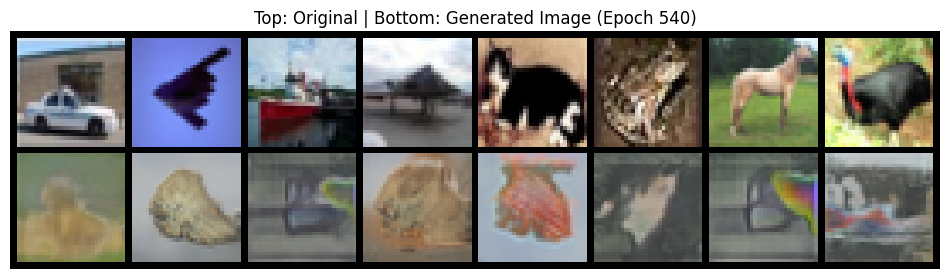

Epoch-541/1000: 100%|██████████| 782/782 [00:14<00:00, 52.44it/s, GenLoss=3.83, DisLoss=0.674, DisSteps=1] 


Generator Loss: 1.6779005720715998
Discriminator Loss: 0.5144425607703226


Epoch-542/1000: 100%|██████████| 782/782 [00:17<00:00, 44.73it/s, GenLoss=4.25, DisLoss=0.746, DisSteps=1] 


Generator Loss: 1.65505941776211
Discriminator Loss: 0.5257922399722402


Epoch-543/1000: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s, GenLoss=4.46, DisLoss=1.64, DisSteps=1]  


Generator Loss: 1.6414888508789374
Discriminator Loss: 0.5028389796347874


Epoch-544/1000: 100%|██████████| 782/782 [00:16<00:00, 48.19it/s, GenLoss=5.04, DisLoss=2.32, DisSteps=1]  


Generator Loss: 1.739717181457583
Discriminator Loss: 0.49015588408617106


Epoch-545/1000: 100%|██████████| 782/782 [00:25<00:00, 31.05it/s, GenLoss=1.92, DisLoss=1.18, DisSteps=1]  


Generator Loss: 1.788901074234482
Discriminator Loss: 0.46738646642478837


Epoch-546/1000: 100%|██████████| 782/782 [00:22<00:00, 34.53it/s, GenLoss=3.28, DisLoss=1.54, DisSteps=1]  


Generator Loss: 1.777896672792142
Discriminator Loss: 0.45318113034948365


Epoch-547/1000: 100%|██████████| 782/782 [00:15<00:00, 51.50it/s, GenLoss=4.03, DisLoss=1.55, DisSteps=1]  


Generator Loss: 1.7795200410401424
Discriminator Loss: 0.467776065611321


Epoch-548/1000: 100%|██████████| 782/782 [00:13<00:00, 56.05it/s, GenLoss=2.92, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.8401347378940534
Discriminator Loss: 0.4624478891110786


Epoch-549/1000: 100%|██████████| 782/782 [00:17<00:00, 44.13it/s, GenLoss=3.02, DisLoss=1.15, DisSteps=1]  


Generator Loss: 1.741142532976387
Discriminator Loss: 0.49027567250115794


Epoch-550/1000: 100%|██████████| 782/782 [00:14<00:00, 55.20it/s, GenLoss=6.04, DisLoss=0.842, DisSteps=1] 


Generator Loss: 1.9192072782675018
Discriminator Loss: 0.45173263669852404


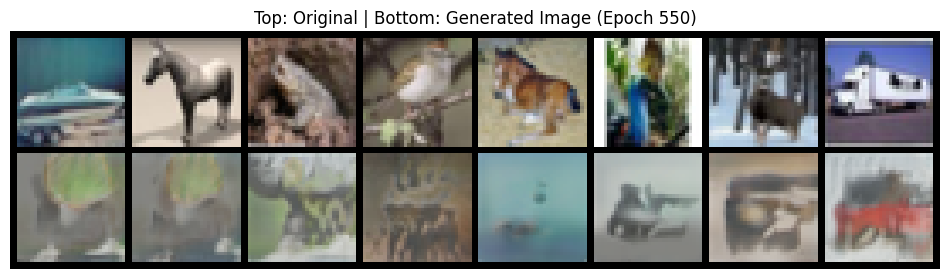

Epoch-551/1000: 100%|██████████| 782/782 [00:13<00:00, 57.15it/s, GenLoss=2.04, DisLoss=1.25, DisSteps=1]  


Generator Loss: 1.8139078078215078
Discriminator Loss: 0.466191134013026


Epoch-552/1000: 100%|██████████| 782/782 [00:18<00:00, 41.82it/s, GenLoss=7.65, DisLoss=0.461, DisSteps=1] 


Generator Loss: 1.892802848687867
Discriminator Loss: 0.4440405605470433


Epoch-553/1000: 100%|██████████| 782/782 [00:19<00:00, 39.46it/s, GenLoss=3.13, DisLoss=0.829, DisSteps=1] 


Generator Loss: 1.7712205809248074
Discriminator Loss: 0.481645792817978


Epoch-554/1000: 100%|██████████| 782/782 [00:17<00:00, 44.06it/s, GenLoss=8.85, DisLoss=1.85, DisSteps=1]  


Generator Loss: 1.810921116824955
Discriminator Loss: 0.4570216352829848


Epoch-555/1000: 100%|██████████| 782/782 [00:15<00:00, 51.90it/s, GenLoss=2.86, DisLoss=1, DisSteps=1]     


Generator Loss: 1.9042567589779948
Discriminator Loss: 0.44646090993186094


Epoch-556/1000: 100%|██████████| 782/782 [00:14<00:00, 54.35it/s, GenLoss=3.32, DisLoss=0.868, DisSteps=1] 


Generator Loss: 1.8556937319238473
Discriminator Loss: 0.47026092096058


Epoch-557/1000: 100%|██████████| 782/782 [00:14<00:00, 52.88it/s, GenLoss=3.17, DisLoss=1.94, DisSteps=1]  


Generator Loss: 1.7201317092951607
Discriminator Loss: 0.49375119273696105


Epoch-558/1000: 100%|██████████| 782/782 [00:14<00:00, 54.88it/s, GenLoss=4.18, DisLoss=0.586, DisSteps=1] 


Generator Loss: 1.8770425760989908
Discriminator Loss: 0.4484956278215589


Epoch-559/1000: 100%|██████████| 782/782 [00:14<00:00, 54.12it/s, GenLoss=3.76, DisLoss=1.38, DisSteps=1]  


Generator Loss: 1.7754489910572082
Discriminator Loss: 0.4721376159230766


Epoch-560/1000: 100%|██████████| 782/782 [00:14<00:00, 55.47it/s, GenLoss=3.01, DisLoss=1.58, DisSteps=1]  


Generator Loss: 1.767955937730077
Discriminator Loss: 0.47876310156053287


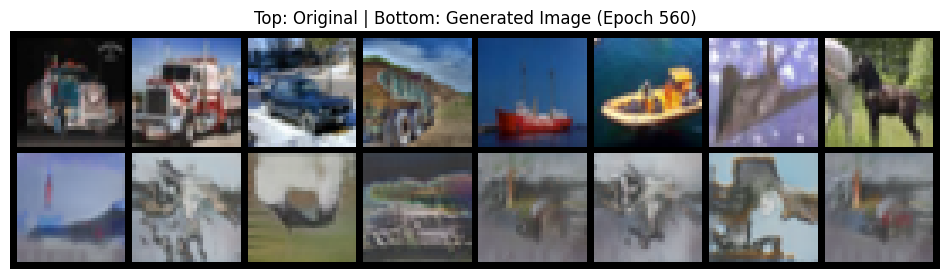

Epoch-561/1000: 100%|██████████| 782/782 [00:13<00:00, 56.77it/s, GenLoss=5.88, DisLoss=0.784, DisSteps=1] 


Generator Loss: 1.7548496880570945
Discriminator Loss: 0.4812196799175209


Epoch-562/1000: 100%|██████████| 782/782 [00:14<00:00, 53.00it/s, GenLoss=2.48, DisLoss=0.631, DisSteps=1] 


Generator Loss: 1.7911324534574737
Discriminator Loss: 0.4868660543275916


Epoch-563/1000: 100%|██████████| 782/782 [00:14<00:00, 54.87it/s, GenLoss=6.77, DisLoss=0.377, DisSteps=1] 


Generator Loss: 1.7401472917755547
Discriminator Loss: 0.4999929631457609


Epoch-564/1000: 100%|██████████| 782/782 [00:14<00:00, 55.47it/s, GenLoss=2.16, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.7751085488006586
Discriminator Loss: 0.48094828022867825


Epoch-565/1000: 100%|██████████| 782/782 [00:23<00:00, 33.37it/s, GenLoss=4.77, DisLoss=0.846, DisSteps=1] 


Generator Loss: 1.657668498166077
Discriminator Loss: 0.5217393114210089


Epoch-566/1000: 100%|██████████| 782/782 [00:25<00:00, 31.19it/s, GenLoss=4.47, DisLoss=0.351, DisSteps=1] 


Generator Loss: 1.5852206655018164
Discriminator Loss: 0.5293147035914919


Epoch-567/1000: 100%|██████████| 782/782 [00:19<00:00, 39.68it/s, GenLoss=4.78, DisLoss=1.6, DisSteps=1]   


Generator Loss: 1.673010356143079
Discriminator Loss: 0.5014786113558523


Epoch-568/1000: 100%|██████████| 782/782 [00:14<00:00, 54.42it/s, GenLoss=1.29, DisLoss=1.06, DisSteps=1]  


Generator Loss: 1.6386509868876098
Discriminator Loss: 0.5386493979093364


Epoch-569/1000: 100%|██████████| 782/782 [00:13<00:00, 56.37it/s, GenLoss=5.21, DisLoss=1.65, DisSteps=1]  


Generator Loss: 1.5711761473313621
Discriminator Loss: 0.5337268013859648


Epoch-570/1000: 100%|██████████| 782/782 [00:16<00:00, 46.80it/s, GenLoss=4.18, DisLoss=1.52, DisSteps=1]  


Generator Loss: 1.6446469585456507
Discriminator Loss: 0.5306405536544597


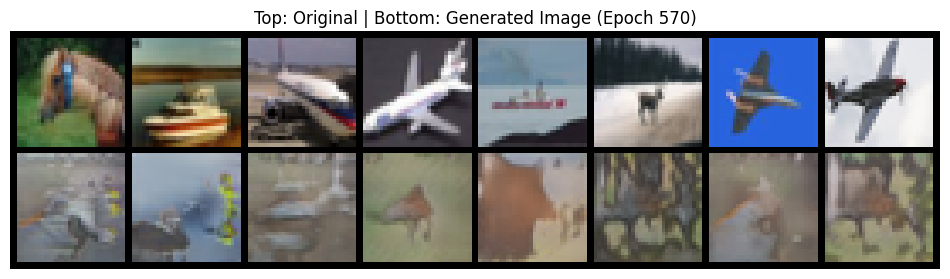

Epoch-571/1000: 100%|██████████| 782/782 [00:15<00:00, 52.10it/s, GenLoss=3.45, DisLoss=1.13, DisSteps=1]  


Generator Loss: 1.677316681122231
Discriminator Loss: 0.5075721335418694


Epoch-572/1000: 100%|██████████| 782/782 [00:15<00:00, 51.37it/s, GenLoss=6.07, DisLoss=1.37, DisSteps=1]  


Generator Loss: 1.7744690011758024
Discriminator Loss: 0.4954579950446058


Epoch-573/1000: 100%|██████████| 782/782 [00:14<00:00, 53.15it/s, GenLoss=2.28, DisLoss=2.1, DisSteps=1]   


Generator Loss: 1.5326911239596583
Discriminator Loss: 0.5630344003248398


Epoch-574/1000: 100%|██████████| 782/782 [00:16<00:00, 47.00it/s, GenLoss=3.41, DisLoss=1.85, DisSteps=1]  


Generator Loss: 1.5381074561868482
Discriminator Loss: 0.554790202156662


Epoch-575/1000: 100%|██████████| 782/782 [00:14<00:00, 54.85it/s, GenLoss=3.91, DisLoss=1.37, DisSteps=1]  


Generator Loss: 1.6450563926068718
Discriminator Loss: 0.506324607983727


Epoch-576/1000: 100%|██████████| 782/782 [00:14<00:00, 54.36it/s, GenLoss=4.11, DisLoss=0.681, DisSteps=1] 


Generator Loss: 1.7439275806212364
Discriminator Loss: 0.47862555639213306


Epoch-577/1000: 100%|██████████| 782/782 [00:19<00:00, 39.50it/s, GenLoss=6.25, DisLoss=0.986, DisSteps=1] 


Generator Loss: 1.6784425735321191
Discriminator Loss: 0.49356482313264666


Epoch-578/1000: 100%|██████████| 782/782 [00:15<00:00, 51.21it/s, GenLoss=3.64, DisLoss=0.845, DisSteps=1] 


Generator Loss: 1.6225889096479587
Discriminator Loss: 0.4976699436488359


Epoch-579/1000: 100%|██████████| 782/782 [00:14<00:00, 54.92it/s, GenLoss=7.14, DisLoss=1.13, DisSteps=1]  


Generator Loss: 1.590324979037275
Discriminator Loss: 0.543984767001913


Epoch-580/1000: 100%|██████████| 782/782 [00:15<00:00, 52.08it/s, GenLoss=3.23, DisLoss=2.57, DisSteps=1]  


Generator Loss: 1.6243705103540664
Discriminator Loss: 0.5256495212045167


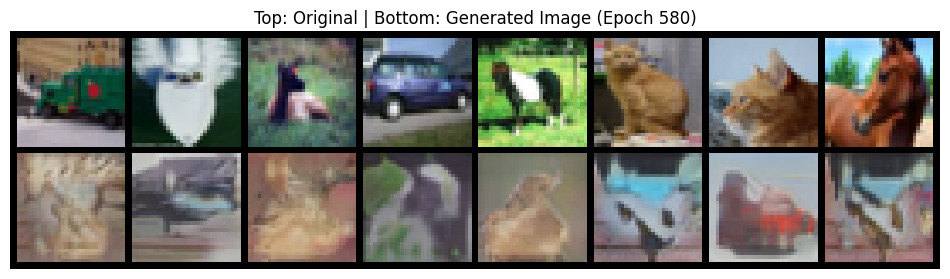

Epoch-581/1000: 100%|██████████| 782/782 [00:14<00:00, 54.44it/s, GenLoss=6.28, DisLoss=1.89, DisSteps=1]  


Generator Loss: 1.7355076664549005
Discriminator Loss: 0.4732672915510509


Epoch-582/1000: 100%|██████████| 782/782 [00:14<00:00, 55.77it/s, GenLoss=6.33, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.7836594671544517
Discriminator Loss: 0.47177158812503983


Epoch-583/1000: 100%|██████████| 782/782 [00:14<00:00, 54.87it/s, GenLoss=6.97, DisLoss=0.914, DisSteps=1] 


Generator Loss: 1.7034117473513268
Discriminator Loss: 0.5034350994640909


Epoch-584/1000: 100%|██████████| 782/782 [00:15<00:00, 51.87it/s, GenLoss=2.52, DisLoss=1.23, DisSteps=1]  


Generator Loss: 1.6279269432472756
Discriminator Loss: 0.5256730139712849


Epoch-585/1000: 100%|██████████| 782/782 [00:16<00:00, 47.33it/s, GenLoss=4.33, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.6172295907116911
Discriminator Loss: 0.5219178437195775


Epoch-586/1000: 100%|██████████| 782/782 [00:19<00:00, 40.03it/s, GenLoss=2.05, DisLoss=0.41, DisSteps=1]  


Generator Loss: 1.627644025646817
Discriminator Loss: 0.5200289382463525


Epoch-587/1000: 100%|██████████| 782/782 [00:18<00:00, 43.22it/s, GenLoss=2.69, DisLoss=2.25, DisSteps=1]  


Generator Loss: 1.5398947920488275
Discriminator Loss: 0.5252259629766655


Epoch-588/1000: 100%|██████████| 782/782 [00:18<00:00, 41.81it/s, GenLoss=4.47, DisLoss=1.87, DisSteps=1]  


Generator Loss: 1.7252063161653022
Discriminator Loss: 0.4938657086180604


Epoch-589/1000: 100%|██████████| 782/782 [00:21<00:00, 35.80it/s, GenLoss=3.95, DisLoss=1.66, DisSteps=1]  


Generator Loss: 1.7035753442655743
Discriminator Loss: 0.4987872171661128


Epoch-590/1000: 100%|██████████| 782/782 [00:14<00:00, 53.36it/s, GenLoss=3.69, DisLoss=0.33, DisSteps=1]  


Generator Loss: 1.7371608585957676
Discriminator Loss: 0.5022041492373742


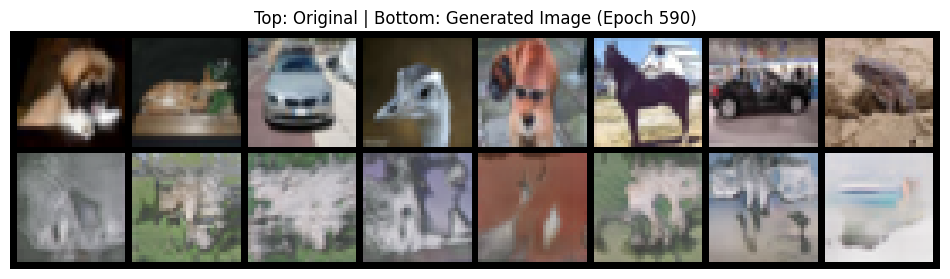

Epoch-591/1000: 100%|██████████| 782/782 [00:15<00:00, 49.00it/s, GenLoss=4.58, DisLoss=1.05, DisSteps=1]  


Generator Loss: 1.7863531830670583
Discriminator Loss: 0.47863307842970504


Epoch-592/1000: 100%|██████████| 782/782 [00:13<00:00, 56.53it/s, GenLoss=2.8, DisLoss=1.68, DisSteps=1]   


Generator Loss: 1.689958403215689
Discriminator Loss: 0.4913557133711208


Epoch-593/1000: 100%|██████████| 782/782 [00:14<00:00, 54.25it/s, GenLoss=4.92, DisLoss=2.16, DisSteps=1]  


Generator Loss: 1.7384327698089277
Discriminator Loss: 0.4894137761324568


Epoch-594/1000: 100%|██████████| 782/782 [00:17<00:00, 45.62it/s, GenLoss=4.01, DisLoss=0.954, DisSteps=1] 


Generator Loss: 1.8528992071023682
Discriminator Loss: 0.4561645060663333


Epoch-595/1000: 100%|██████████| 782/782 [00:21<00:00, 35.97it/s, GenLoss=2.31, DisLoss=1.69, DisSteps=1]  


Generator Loss: 1.854566487509881
Discriminator Loss: 0.44933946779393175


Epoch-596/1000: 100%|██████████| 782/782 [00:18<00:00, 41.42it/s, GenLoss=4.67, DisLoss=0.635, DisSteps=1] 


Generator Loss: 1.6996862213782338
Discriminator Loss: 0.4860486646976008


Epoch-597/1000: 100%|██████████| 782/782 [00:14<00:00, 53.23it/s, GenLoss=2.74, DisLoss=0.759, DisSteps=1] 


Generator Loss: 1.7389429844248936
Discriminator Loss: 0.5039511056202451


Epoch-598/1000: 100%|██████████| 782/782 [00:17<00:00, 44.41it/s, GenLoss=3.79, DisLoss=0.358, DisSteps=1] 


Generator Loss: 1.815551388618129
Discriminator Loss: 0.46430478090672844


Epoch-599/1000: 100%|██████████| 782/782 [00:15<00:00, 49.55it/s, GenLoss=3.7, DisLoss=1.08, DisSteps=1]   


Generator Loss: 1.768920421219238
Discriminator Loss: 0.4745870312995008


Epoch-600/1000: 100%|██████████| 782/782 [00:13<00:00, 56.59it/s, GenLoss=3.03, DisLoss=0.876, DisSteps=1] 


Generator Loss: 1.7460598643783414
Discriminator Loss: 0.48342917802388713


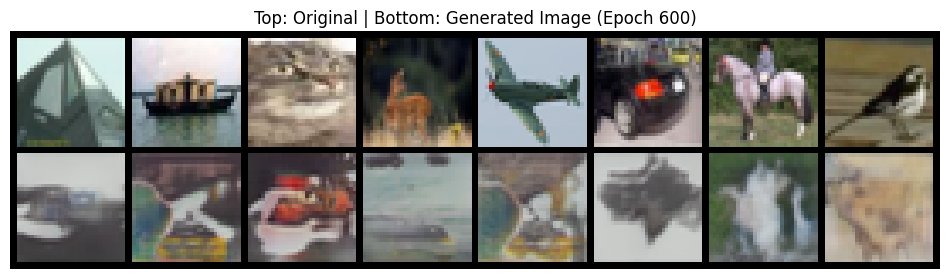

Epoch-601/1000: 100%|██████████| 782/782 [00:14<00:00, 54.81it/s, GenLoss=3.88, DisLoss=1, DisSteps=1]     


Generator Loss: 1.7034753835795786
Discriminator Loss: 0.49428113168843874


Epoch-602/1000: 100%|██████████| 782/782 [00:14<00:00, 53.65it/s, GenLoss=2.23, DisLoss=1.04, DisSteps=1]  


Generator Loss: 1.6113457427076672
Discriminator Loss: 0.5134559823081012


Epoch-603/1000: 100%|██████████| 782/782 [00:20<00:00, 38.31it/s, GenLoss=4.32, DisLoss=1.88, DisSteps=1]  


Generator Loss: 1.674476301540499
Discriminator Loss: 0.4880694979825593


Epoch-604/1000: 100%|██████████| 782/782 [00:21<00:00, 36.09it/s, GenLoss=4.84, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.562316711029738
Discriminator Loss: 0.553345280744688


Epoch-605/1000: 100%|██████████| 782/782 [00:15<00:00, 50.18it/s, GenLoss=4.39, DisLoss=1.74, DisSteps=1]  


Generator Loss: 1.8537676412507396
Discriminator Loss: 0.48097647282549794


Epoch-606/1000: 100%|██████████| 782/782 [00:19<00:00, 40.60it/s, GenLoss=3.27, DisLoss=0.255, DisSteps=1] 


Generator Loss: 1.8099832999355652
Discriminator Loss: 0.4769916235638397


Epoch-607/1000: 100%|██████████| 782/782 [00:25<00:00, 30.84it/s, GenLoss=5.4, DisLoss=2.98, DisSteps=1]   


Generator Loss: 1.6977161996428618
Discriminator Loss: 0.4888251106566785


Epoch-608/1000: 100%|██████████| 782/782 [00:14<00:00, 53.17it/s, GenLoss=2.12, DisLoss=0.893, DisSteps=1] 


Generator Loss: 1.639544145530447
Discriminator Loss: 0.5163336358106959


Epoch-609/1000: 100%|██████████| 782/782 [00:16<00:00, 47.32it/s, GenLoss=2.26, DisLoss=0.963, DisSteps=1] 


Generator Loss: 1.6534214088374086
Discriminator Loss: 0.4983777744538339


Epoch-610/1000: 100%|██████████| 782/782 [00:14<00:00, 53.11it/s, GenLoss=3.98, DisLoss=1.47, DisSteps=1]  


Generator Loss: 1.6885911834133251
Discriminator Loss: 0.5166938934865815


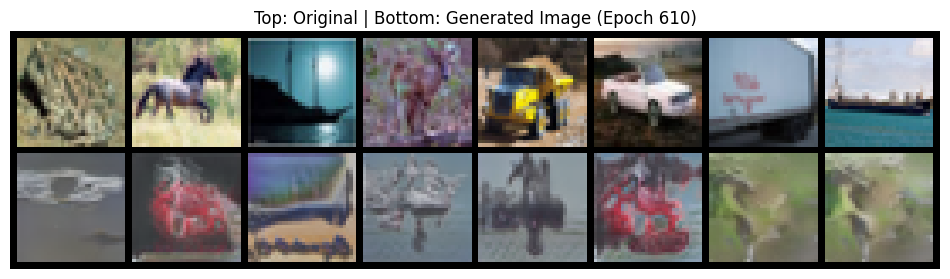

Epoch-611/1000: 100%|██████████| 782/782 [00:14<00:00, 52.65it/s, GenLoss=3.76, DisLoss=2.6, DisSteps=1]   


Generator Loss: 1.711647788810608
Discriminator Loss: 0.5009287712557237


Epoch-612/1000: 100%|██████████| 782/782 [00:13<00:00, 57.05it/s, GenLoss=2.24, DisLoss=0.792, DisSteps=1] 


Generator Loss: 1.6352909782810894
Discriminator Loss: 0.5278907559259468


Epoch-613/1000: 100%|██████████| 782/782 [00:16<00:00, 47.78it/s, GenLoss=3.41, DisLoss=2.07, DisSteps=1]  


Generator Loss: 1.6504537462425963
Discriminator Loss: 0.5117402002024833


Epoch-614/1000: 100%|██████████| 782/782 [00:21<00:00, 35.98it/s, GenLoss=3.27, DisLoss=1.11, DisSteps=1]  


Generator Loss: 1.6395956730598684
Discriminator Loss: 0.5006686693719585


Epoch-615/1000: 100%|██████████| 782/782 [00:14<00:00, 52.98it/s, GenLoss=2.41, DisLoss=0.462, DisSteps=1] 


Generator Loss: 1.6973923156252297
Discriminator Loss: 0.5103149307353417


Epoch-616/1000: 100%|██████████| 782/782 [00:17<00:00, 45.56it/s, GenLoss=3.35, DisLoss=1.59, DisSteps=1]  


Generator Loss: 1.8435715514680613
Discriminator Loss: 0.4597251240897666


Epoch-617/1000: 100%|██████████| 782/782 [00:14<00:00, 53.04it/s, GenLoss=6.58, DisLoss=0.971, DisSteps=1] 


Generator Loss: 1.7563406631083744
Discriminator Loss: 0.47935898266637417


Epoch-618/1000: 100%|██████████| 782/782 [00:14<00:00, 52.26it/s, GenLoss=3.15, DisLoss=2.43, DisSteps=1]  


Generator Loss: 1.7506739694215452
Discriminator Loss: 0.5075216993613316


Epoch-619/1000: 100%|██████████| 782/782 [00:14<00:00, 54.33it/s, GenLoss=2.16, DisLoss=2.19, DisSteps=1]  


Generator Loss: 1.611162605569186
Discriminator Loss: 0.53619813635145


Epoch-620/1000: 100%|██████████| 782/782 [00:14<00:00, 54.58it/s, GenLoss=6.59, DisLoss=1.95, DisSteps=1]  


Generator Loss: 1.556855043601197
Discriminator Loss: 0.5316484294965139


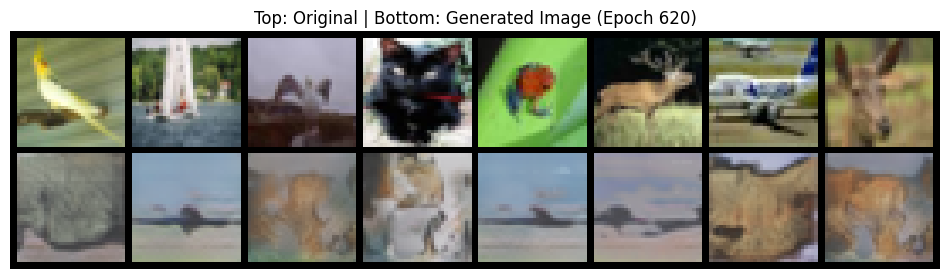

Epoch-621/1000: 100%|██████████| 782/782 [00:19<00:00, 39.74it/s, GenLoss=2.53, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.7093419039721989
Discriminator Loss: 0.5009131955787959


Epoch-622/1000: 100%|██████████| 782/782 [00:17<00:00, 44.13it/s, GenLoss=2, DisLoss=1.2, DisSteps=1]      


Generator Loss: 1.6542214644153406
Discriminator Loss: 0.5309147015785622


Epoch-623/1000: 100%|██████████| 782/782 [00:20<00:00, 37.88it/s, GenLoss=5.27, DisLoss=0.977, DisSteps=1] 


Generator Loss: 1.750638642045848
Discriminator Loss: 0.4928800273505623


Epoch-624/1000: 100%|██████████| 782/782 [00:23<00:00, 33.20it/s, GenLoss=3.08, DisLoss=0.403, DisSteps=1] 


Generator Loss: 1.6381016801995085
Discriminator Loss: 0.5049316610978998


Epoch-625/1000: 100%|██████████| 782/782 [00:17<00:00, 45.02it/s, GenLoss=2.33, DisLoss=1.78, DisSteps=1]  


Generator Loss: 1.7099420294699157
Discriminator Loss: 0.4804763518216665


Epoch-626/1000: 100%|██████████| 782/782 [00:19<00:00, 41.04it/s, GenLoss=3.11, DisLoss=0.408, DisSteps=1] 


Generator Loss: 1.545804059833212
Discriminator Loss: 0.5256070332873203


Epoch-627/1000: 100%|██████████| 782/782 [00:13<00:00, 56.86it/s, GenLoss=2.75, DisLoss=1.03, DisSteps=1]  


Generator Loss: 1.5831667707704218
Discriminator Loss: 0.5256320449054394


Epoch-628/1000: 100%|██████████| 782/782 [00:14<00:00, 52.47it/s, GenLoss=1.92, DisLoss=0.552, DisSteps=1] 


Generator Loss: 1.650903064157347
Discriminator Loss: 0.5113695140003853


Epoch-629/1000: 100%|██████████| 782/782 [00:21<00:00, 36.76it/s, GenLoss=5.31, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.656519333572339
Discriminator Loss: 0.5186925320254873


Epoch-630/1000: 100%|██████████| 782/782 [00:17<00:00, 45.42it/s, GenLoss=3.95, DisLoss=0.96, DisSteps=1]  


Generator Loss: 1.6288691890209228
Discriminator Loss: 0.5049357225027535


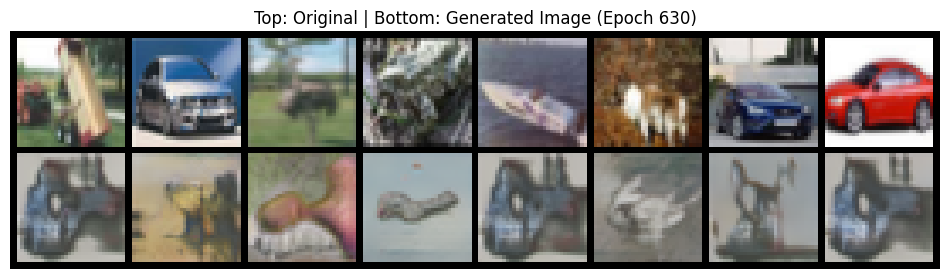

Epoch-631/1000: 100%|██████████| 782/782 [00:14<00:00, 54.92it/s, GenLoss=3.91, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.6158685067578045
Discriminator Loss: 0.4914954924941673


Epoch-632/1000: 100%|██████████| 782/782 [00:14<00:00, 55.10it/s, GenLoss=4.05, DisLoss=2.25, DisSteps=1]  


Generator Loss: 1.6693077530245037
Discriminator Loss: 0.5254767293591633


Epoch-633/1000: 100%|██████████| 782/782 [00:14<00:00, 53.61it/s, GenLoss=3.84, DisLoss=1.22, DisSteps=1]  


Generator Loss: 1.7081812698289256
Discriminator Loss: 0.5235813409661698


Epoch-634/1000: 100%|██████████| 782/782 [00:26<00:00, 29.68it/s, GenLoss=2.72, DisLoss=0.426, DisSteps=1] 


Generator Loss: 1.7472620080117984
Discriminator Loss: 0.4621112592842268


Epoch-635/1000: 100%|██████████| 782/782 [00:16<00:00, 48.64it/s, GenLoss=4.21, DisLoss=2.42, DisSteps=1]  


Generator Loss: 1.7666197766733291
Discriminator Loss: 0.4859088210155592


Epoch-636/1000: 100%|██████████| 782/782 [00:15<00:00, 49.12it/s, GenLoss=7.21, DisLoss=0.69, DisSteps=1]  


Generator Loss: 1.5995187154587578
Discriminator Loss: 0.5076300694852534


Epoch-637/1000: 100%|██████████| 782/782 [00:18<00:00, 43.41it/s, GenLoss=3.83, DisLoss=0.638, DisSteps=1] 


Generator Loss: 1.6308549796528828
Discriminator Loss: 0.5336485308073365


Epoch-638/1000: 100%|██████████| 782/782 [00:13<00:00, 56.01it/s, GenLoss=3.67, DisLoss=2.42, DisSteps=1]  


Generator Loss: 1.649291034511593
Discriminator Loss: 0.5144874588645938


Epoch-639/1000: 100%|██████████| 782/782 [00:14<00:00, 53.54it/s, GenLoss=3.24, DisLoss=1.42, DisSteps=1]  


Generator Loss: 1.6208089585118282
Discriminator Loss: 0.5200590874113695


Epoch-640/1000: 100%|██████████| 782/782 [00:15<00:00, 51.72it/s, GenLoss=3.74, DisLoss=0.635, DisSteps=1] 


Generator Loss: 1.6412426186796953
Discriminator Loss: 0.5139982035512205


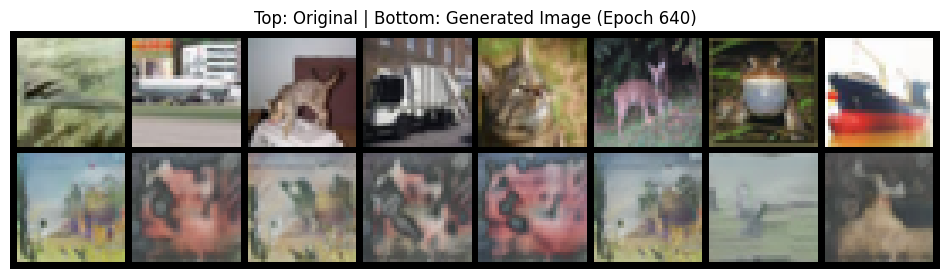

Epoch-641/1000: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s, GenLoss=5.94, DisLoss=1.15, DisSteps=1]  


Generator Loss: 1.539827524929705
Discriminator Loss: 0.5521870740996603


Epoch-642/1000: 100%|██████████| 782/782 [00:14<00:00, 55.33it/s, GenLoss=2.66, DisLoss=2, DisSteps=1]     


Generator Loss: 1.754030358074876
Discriminator Loss: 0.4955397005695516


Epoch-643/1000: 100%|██████████| 782/782 [00:15<00:00, 49.60it/s, GenLoss=4.35, DisLoss=0.907, DisSteps=1] 


Generator Loss: 1.6837498222851692
Discriminator Loss: 0.4869630392783743


Epoch-644/1000: 100%|██████████| 782/782 [00:19<00:00, 39.19it/s, GenLoss=2.48, DisLoss=1.92, DisSteps=1]  


Generator Loss: 1.6938680771671597
Discriminator Loss: 0.4907912963720234


Epoch-645/1000: 100%|██████████| 782/782 [00:14<00:00, 54.35it/s, GenLoss=4.16, DisLoss=0.782, DisSteps=1] 


Generator Loss: 1.679881664798083
Discriminator Loss: 0.4949230781144193


Epoch-646/1000: 100%|██████████| 782/782 [00:14<00:00, 53.73it/s, GenLoss=6.64, DisLoss=0.644, DisSteps=1] 


Generator Loss: 1.6065090365726928
Discriminator Loss: 0.505440794788968


Epoch-647/1000: 100%|██████████| 782/782 [00:14<00:00, 52.44it/s, GenLoss=3.57, DisLoss=0.403, DisSteps=1] 


Generator Loss: 1.8056452427526264
Discriminator Loss: 0.4688888030398227


Epoch-648/1000: 100%|██████████| 782/782 [00:15<00:00, 52.05it/s, GenLoss=2.33, DisLoss=1.15, DisSteps=1]  


Generator Loss: 1.6828999217132778
Discriminator Loss: 0.49164448472697414


Epoch-649/1000: 100%|██████████| 782/782 [00:14<00:00, 54.12it/s, GenLoss=2.62, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.685170205924517
Discriminator Loss: 0.4860700590683676


Epoch-650/1000: 100%|██████████| 782/782 [00:14<00:00, 53.90it/s, GenLoss=4.65, DisLoss=2.11, DisSteps=1]  


Generator Loss: 1.6847127731651297
Discriminator Loss: 0.5057599113687224


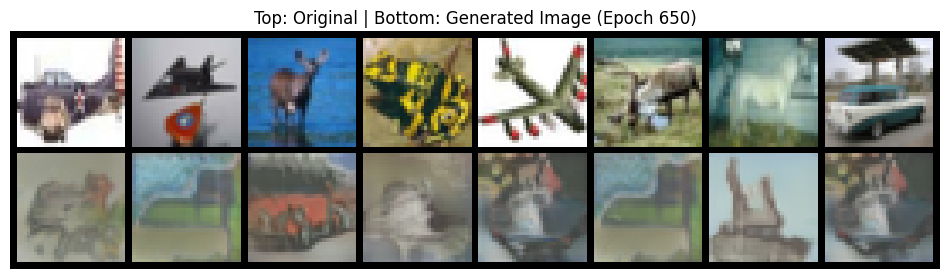

Epoch-651/1000: 100%|██████████| 782/782 [00:14<00:00, 53.54it/s, GenLoss=3.87, DisLoss=0.726, DisSteps=1] 


Generator Loss: 1.7162826329545902
Discriminator Loss: 0.5196450675844841


Epoch-652/1000: 100%|██████████| 782/782 [00:14<00:00, 52.38it/s, GenLoss=2.21, DisLoss=1.84, DisSteps=1]  


Generator Loss: 1.7026395489797568
Discriminator Loss: 0.5211503554488082


Epoch-653/1000: 100%|██████████| 782/782 [00:14<00:00, 54.38it/s, GenLoss=2.74, DisLoss=1.2, DisSteps=1]   


Generator Loss: 1.5902600837180683
Discriminator Loss: 0.5328950775630029


Epoch-654/1000: 100%|██████████| 782/782 [00:14<00:00, 54.13it/s, GenLoss=3.49, DisLoss=0.864, DisSteps=1] 


Generator Loss: 1.6540361066227374
Discriminator Loss: 0.5290168705574997


Epoch-655/1000: 100%|██████████| 782/782 [00:19<00:00, 39.66it/s, GenLoss=6.99, DisLoss=0.914, DisSteps=1] 


Generator Loss: 1.6567302804316402
Discriminator Loss: 0.5222998616449973


Epoch-656/1000: 100%|██████████| 782/782 [00:15<00:00, 49.55it/s, GenLoss=2.35, DisLoss=0.361, DisSteps=1] 


Generator Loss: 1.5059509365569295
Discriminator Loss: 0.5699326701252662


Epoch-657/1000: 100%|██████████| 782/782 [00:14<00:00, 52.97it/s, GenLoss=4.78, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.5722807355396582
Discriminator Loss: 0.5410668526768989


Epoch-658/1000: 100%|██████████| 782/782 [00:15<00:00, 51.18it/s, GenLoss=3.16, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.4426802915075552
Discriminator Loss: 0.5650497529169788


Epoch-659/1000: 100%|██████████| 782/782 [00:15<00:00, 51.26it/s, GenLoss=4.29, DisLoss=1.3, DisSteps=1]   


Generator Loss: 1.7305110157145869
Discriminator Loss: 0.5111540858359898


Epoch-660/1000: 100%|██████████| 782/782 [00:14<00:00, 54.82it/s, GenLoss=2.5, DisLoss=0.847, DisSteps=1]  


Generator Loss: 1.679200012932348
Discriminator Loss: 0.5160645062051465


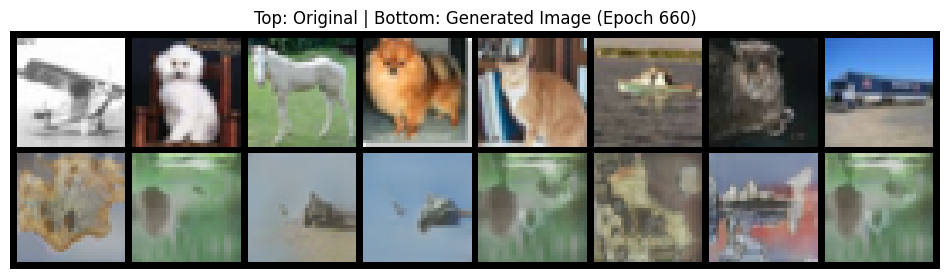

Epoch-661/1000: 100%|██████████| 782/782 [00:14<00:00, 54.20it/s, GenLoss=2.41, DisLoss=1.1, DisSteps=1]   


Generator Loss: 1.542223341400971
Discriminator Loss: 0.5307824859952988


Epoch-662/1000: 100%|██████████| 782/782 [00:13<00:00, 55.94it/s, GenLoss=2.99, DisLoss=0.72, DisSteps=1]  


Generator Loss: 1.575897731058433
Discriminator Loss: 0.528617612121965


Epoch-663/1000: 100%|██████████| 782/782 [00:14<00:00, 55.37it/s, GenLoss=4.08, DisLoss=1.55, DisSteps=1]  


Generator Loss: 1.677056581410758
Discriminator Loss: 0.5013979183857703


Epoch-664/1000: 100%|██████████| 782/782 [00:14<00:00, 52.31it/s, GenLoss=6.91, DisLoss=0.505, DisSteps=1] 


Generator Loss: 1.7547598773866053
Discriminator Loss: 0.4769174363225927


Epoch-665/1000: 100%|██████████| 782/782 [00:14<00:00, 55.73it/s, GenLoss=6.86, DisLoss=2.03, DisSteps=1]  


Generator Loss: 1.706783211749533
Discriminator Loss: 0.5213639950165359


Epoch-666/1000: 100%|██████████| 782/782 [00:16<00:00, 46.56it/s, GenLoss=4.02, DisLoss=0.695, DisSteps=1] 


Generator Loss: 1.770634956219617
Discriminator Loss: 0.4704054035913304


Epoch-667/1000: 100%|██████████| 782/782 [00:17<00:00, 44.30it/s, GenLoss=5.97, DisLoss=1.01, DisSteps=1]  


Generator Loss: 1.720439905667549
Discriminator Loss: 0.4750714178775887


Epoch-668/1000: 100%|██████████| 782/782 [00:14<00:00, 53.97it/s, GenLoss=2.2, DisLoss=0.573, DisSteps=1]  


Generator Loss: 1.7520083930638746
Discriminator Loss: 0.47981414193158867


Epoch-669/1000: 100%|██████████| 782/782 [00:14<00:00, 53.74it/s, GenLoss=3.56, DisLoss=0.73, DisSteps=1]  


Generator Loss: 1.6302622344792652
Discriminator Loss: 0.5070901277577481


Epoch-670/1000: 100%|██████████| 782/782 [00:14<00:00, 54.74it/s, GenLoss=6.67, DisLoss=1.09, DisSteps=1]  


Generator Loss: 1.7096555688039725
Discriminator Loss: 0.46897145292109543


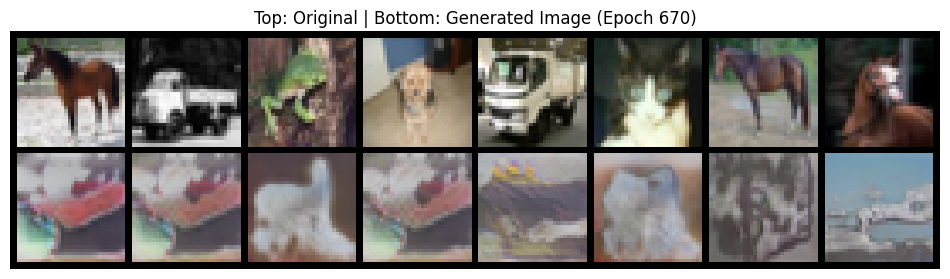

Epoch-671/1000: 100%|██████████| 782/782 [00:14<00:00, 53.01it/s, GenLoss=7.2, DisLoss=1.7, DisSteps=1]    


Generator Loss: 1.900405418842345
Discriminator Loss: 0.45738004954041117


Epoch-672/1000: 100%|██████████| 782/782 [00:14<00:00, 55.60it/s, GenLoss=2.45, DisLoss=0.579, DisSteps=1] 


Generator Loss: 1.8399107594929083
Discriminator Loss: 0.4558369296857768


Epoch-673/1000: 100%|██████████| 782/782 [00:14<00:00, 55.64it/s, GenLoss=3.93, DisLoss=1.3, DisSteps=1]   


Generator Loss: 1.7135778845042524
Discriminator Loss: 0.5010349567970047


Epoch-674/1000: 100%|██████████| 782/782 [00:14<00:00, 54.45it/s, GenLoss=4.22, DisLoss=2.13, DisSteps=1]  


Generator Loss: 1.691551890252801
Discriminator Loss: 0.49599224178458723


Epoch-675/1000: 100%|██████████| 782/782 [00:14<00:00, 53.95it/s, GenLoss=2.15, DisLoss=1.05, DisSteps=1]  


Generator Loss: 1.6173281546139047
Discriminator Loss: 0.5384249921764255


Epoch-676/1000: 100%|██████████| 782/782 [00:14<00:00, 53.95it/s, GenLoss=4.42, DisLoss=2.65, DisSteps=1]  


Generator Loss: 1.6928501389825437
Discriminator Loss: 0.5055421039919414


Epoch-677/1000: 100%|██████████| 782/782 [00:18<00:00, 42.76it/s, GenLoss=6.37, DisLoss=0.659, DisSteps=1] 


Generator Loss: 1.6807252708679574
Discriminator Loss: 0.5013787565214555


Epoch-678/1000: 100%|██████████| 782/782 [00:16<00:00, 46.58it/s, GenLoss=5.17, DisLoss=1.3, DisSteps=1]   


Generator Loss: 1.7596931638829696
Discriminator Loss: 0.49082756423584334


Epoch-679/1000: 100%|██████████| 782/782 [00:14<00:00, 54.48it/s, GenLoss=4.88, DisLoss=0.671, DisSteps=1] 


Generator Loss: 1.794738584733985
Discriminator Loss: 0.4801695045188565


Epoch-680/1000: 100%|██████████| 782/782 [00:14<00:00, 54.17it/s, GenLoss=3.94, DisLoss=1.25, DisSteps=1]  


Generator Loss: 1.852319867943254
Discriminator Loss: 0.4546361376943491


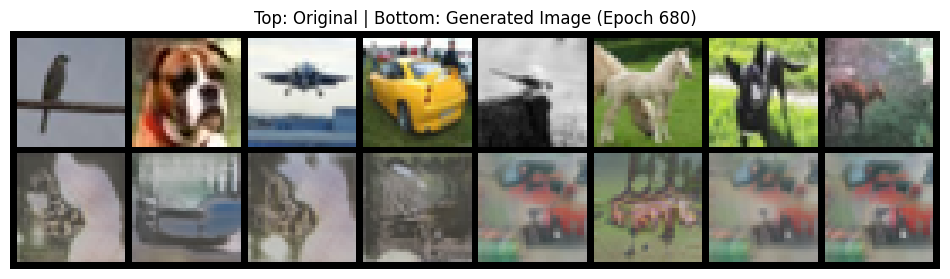

Epoch-681/1000: 100%|██████████| 782/782 [00:15<00:00, 49.81it/s, GenLoss=3.28, DisLoss=0.455, DisSteps=1] 


Generator Loss: 1.8640826650516455
Discriminator Loss: 0.4615490006287689


Epoch-682/1000: 100%|██████████| 782/782 [00:17<00:00, 44.78it/s, GenLoss=2.98, DisLoss=1.86, DisSteps=1]  


Generator Loss: 1.8768683273697753
Discriminator Loss: 0.4472064671423429


Epoch-683/1000: 100%|██████████| 782/782 [00:17<00:00, 45.08it/s, GenLoss=6.13, DisLoss=1.49, DisSteps=1]  


Generator Loss: 1.8202239946102547
Discriminator Loss: 0.4847192653381001


Epoch-684/1000: 100%|██████████| 782/782 [00:19<00:00, 39.32it/s, GenLoss=5.84, DisLoss=1.27, DisSteps=1]  


Generator Loss: 1.8123224094853072
Discriminator Loss: 0.4752919189727215


Epoch-685/1000: 100%|██████████| 782/782 [00:26<00:00, 29.34it/s, GenLoss=3.64, DisLoss=2.22, DisSteps=1]  


Generator Loss: 1.898699615083997
Discriminator Loss: 0.45353757395692496


Epoch-686/1000: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s, GenLoss=3.82, DisLoss=1.22, DisSteps=1]  


Generator Loss: 1.8510986647718704
Discriminator Loss: 0.46091205352331366


Epoch-687/1000: 100%|██████████| 782/782 [00:18<00:00, 43.11it/s, GenLoss=2.84, DisLoss=0.225, DisSteps=1] 


Generator Loss: 1.6545341786216288
Discriminator Loss: 0.5087601655089032


Epoch-688/1000: 100%|██████████| 782/782 [00:18<00:00, 42.94it/s, GenLoss=2.5, DisLoss=0.553, DisSteps=1]  


Generator Loss: 1.7745528785926301
Discriminator Loss: 0.4820224697060902


Epoch-689/1000: 100%|██████████| 782/782 [00:17<00:00, 43.93it/s, GenLoss=1.47, DisLoss=2, DisSteps=1]     


Generator Loss: 1.7565340248253338
Discriminator Loss: 0.5070690953975443


Epoch-690/1000: 100%|██████████| 782/782 [00:17<00:00, 44.52it/s, GenLoss=2.86, DisLoss=0.524, DisSteps=1] 


Generator Loss: 1.7893343171881289
Discriminator Loss: 0.48564469396991805


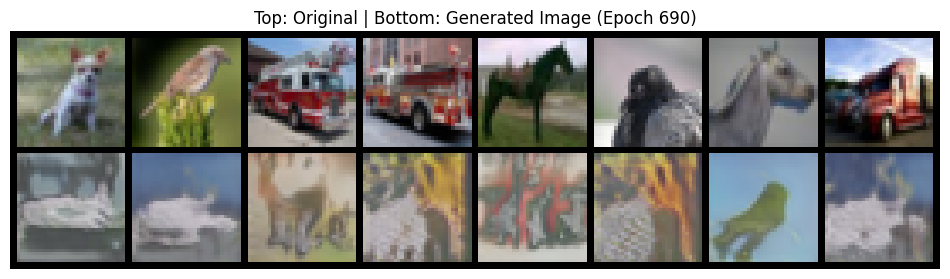

Epoch-691/1000: 100%|██████████| 782/782 [00:17<00:00, 44.58it/s, GenLoss=4.64, DisLoss=2.04, DisSteps=1]  


Generator Loss: 1.7774298116374199
Discriminator Loss: 0.4869609335651788


Epoch-692/1000: 100%|██████████| 782/782 [00:16<00:00, 48.39it/s, GenLoss=4.62, DisLoss=2.53, DisSteps=1]  


Generator Loss: 1.6926700089060132
Discriminator Loss: 0.5110825266679535


Epoch-693/1000: 100%|██████████| 782/782 [00:17<00:00, 44.98it/s, GenLoss=2.66, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.735209037542648
Discriminator Loss: 0.472903927821485


Epoch-694/1000: 100%|██████████| 782/782 [00:22<00:00, 34.67it/s, GenLoss=3.72, DisLoss=2.14, DisSteps=1]  


Generator Loss: 1.7964556859734724
Discriminator Loss: 0.4655278110900498


Epoch-695/1000: 100%|██████████| 782/782 [00:16<00:00, 47.31it/s, GenLoss=3.05, DisLoss=1.5, DisSteps=1]   


Generator Loss: 1.8524226656426555
Discriminator Loss: 0.4592609726788138


Epoch-696/1000: 100%|██████████| 782/782 [00:16<00:00, 46.17it/s, GenLoss=4.95, DisLoss=0.471, DisSteps=1] 


Generator Loss: 1.8478074000619562
Discriminator Loss: 0.43794929556300877


Epoch-697/1000: 100%|██████████| 782/782 [00:17<00:00, 44.71it/s, GenLoss=4.37, DisLoss=1.06, DisSteps=1]  


Generator Loss: 1.8185642650136558
Discriminator Loss: 0.47493537702142735


Epoch-698/1000: 100%|██████████| 782/782 [00:19<00:00, 40.31it/s, GenLoss=4.62, DisLoss=2.19, DisSteps=1]  


Generator Loss: 1.7766524179436056
Discriminator Loss: 0.5030484738595346


Epoch-699/1000: 100%|██████████| 782/782 [00:16<00:00, 46.06it/s, GenLoss=4.94, DisLoss=2.24, DisSteps=1]  


Generator Loss: 1.692590689110329
Discriminator Loss: 0.5099047021297238


Epoch-700/1000: 100%|██████████| 782/782 [00:21<00:00, 36.52it/s, GenLoss=6.74, DisLoss=1.04, DisSteps=1]  


Generator Loss: 1.7399426680010603
Discriminator Loss: 0.4918635723078647


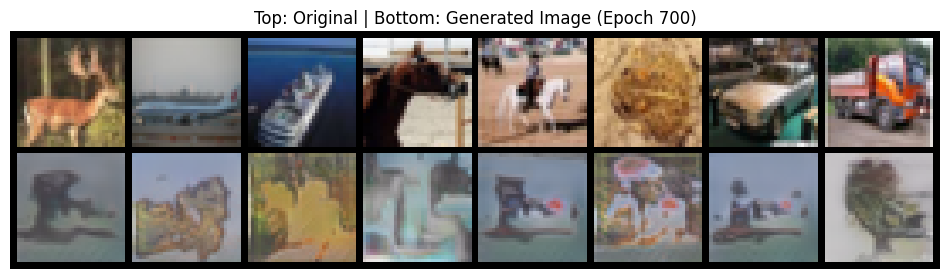

Epoch-701/1000: 100%|██████████| 782/782 [00:23<00:00, 33.09it/s, GenLoss=7.11, DisLoss=2.6, DisSteps=1]   


Generator Loss: 1.589888060184391
Discriminator Loss: 0.5589013945911546


Epoch-702/1000: 100%|██████████| 782/782 [00:14<00:00, 55.32it/s, GenLoss=3.07, DisLoss=0.483, DisSteps=1] 


Generator Loss: 1.5830326046785126
Discriminator Loss: 0.5452765725229097


Epoch-703/1000: 100%|██████████| 782/782 [00:21<00:00, 35.81it/s, GenLoss=2.02, DisLoss=1.73, DisSteps=1]  


Generator Loss: 1.761857854054712
Discriminator Loss: 0.46657156223988594


Epoch-704/1000: 100%|██████████| 782/782 [00:14<00:00, 53.25it/s, GenLoss=6.17, DisLoss=0.367, DisSteps=1] 


Generator Loss: 1.6196149133545967
Discriminator Loss: 0.5300210277023523


Epoch-705/1000: 100%|██████████| 782/782 [00:14<00:00, 55.65it/s, GenLoss=4.74, DisLoss=0.632, DisSteps=1] 


Generator Loss: 1.7336316027147385
Discriminator Loss: 0.4930500594894295


Epoch-706/1000: 100%|██████████| 782/782 [00:14<00:00, 55.39it/s, GenLoss=2.73, DisLoss=0.725, DisSteps=1] 


Generator Loss: 1.6114184881186546
Discriminator Loss: 0.5606390547074015


Epoch-707/1000: 100%|██████████| 782/782 [00:15<00:00, 51.00it/s, GenLoss=4.82, DisLoss=0.902, DisSteps=1] 


Generator Loss: 1.5234683328272436
Discriminator Loss: 0.5457815709511947


Epoch-708/1000: 100%|██████████| 782/782 [00:14<00:00, 53.59it/s, GenLoss=2.08, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.63031228694617
Discriminator Loss: 0.5178554270159254


Epoch-709/1000: 100%|██████████| 782/782 [00:13<00:00, 56.13it/s, GenLoss=2.71, DisLoss=0.777, DisSteps=1] 


Generator Loss: 1.6286048912026387
Discriminator Loss: 0.49591712701274915


Epoch-710/1000: 100%|██████████| 782/782 [00:14<00:00, 53.83it/s, GenLoss=6.79, DisLoss=2.6, DisSteps=1]   


Generator Loss: 1.5949777012590862
Discriminator Loss: 0.5314567100132823


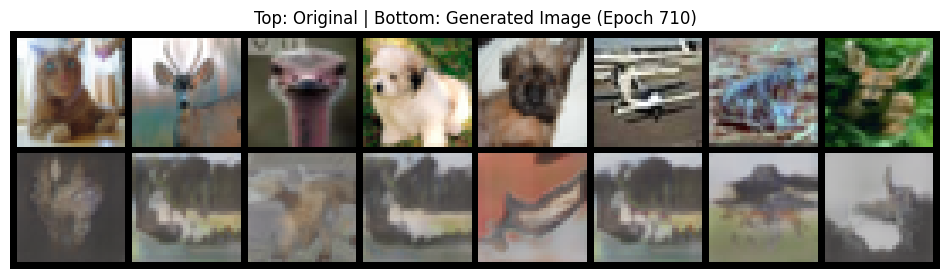

Epoch-711/1000: 100%|██████████| 782/782 [00:14<00:00, 52.36it/s, GenLoss=4.82, DisLoss=2.54, DisSteps=1]  


Generator Loss: 1.6274646177621144
Discriminator Loss: 0.5151675988722335


Epoch-712/1000: 100%|██████████| 782/782 [00:15<00:00, 52.09it/s, GenLoss=3.03, DisLoss=1.37, DisSteps=1]  


Generator Loss: 1.7180480939881575
Discriminator Loss: 0.4896953280090981


Epoch-713/1000: 100%|██████████| 782/782 [00:14<00:00, 55.36it/s, GenLoss=3.21, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.5557421958050155
Discriminator Loss: 0.5365269877721587


Epoch-714/1000: 100%|██████████| 782/782 [00:14<00:00, 54.28it/s, GenLoss=4.25, DisLoss=2.22, DisSteps=1]  


Generator Loss: 1.7275484820156146
Discriminator Loss: 0.48370696061178853


Epoch-715/1000: 100%|██████████| 782/782 [00:14<00:00, 53.97it/s, GenLoss=2.94, DisLoss=0.773, DisSteps=1] 


Generator Loss: 1.7676852946086308
Discriminator Loss: 0.48097905566167953


Epoch-716/1000: 100%|██████████| 782/782 [00:20<00:00, 38.68it/s, GenLoss=2.73, DisLoss=2.03, DisSteps=1]  


Generator Loss: 1.7185372082931
Discriminator Loss: 0.4950372047741395


Epoch-717/1000: 100%|██████████| 782/782 [00:17<00:00, 44.79it/s, GenLoss=4.64, DisLoss=0.671, DisSteps=1] 


Generator Loss: 1.7508084998868616
Discriminator Loss: 0.4755635673127821


Epoch-718/1000: 100%|██████████| 782/782 [00:14<00:00, 53.30it/s, GenLoss=3.7, DisLoss=1.55, DisSteps=1]   


Generator Loss: 1.7843482416227956
Discriminator Loss: 0.4705245518661521


Epoch-719/1000: 100%|██████████| 782/782 [00:14<00:00, 52.87it/s, GenLoss=4.98, DisLoss=1.44, DisSteps=1]  


Generator Loss: 1.7815338270667265
Discriminator Loss: 0.47050172086719355


Epoch-720/1000: 100%|██████████| 782/782 [00:14<00:00, 52.53it/s, GenLoss=1.57, DisLoss=1.61, DisSteps=1]  


Generator Loss: 1.7124372213088033
Discriminator Loss: 0.49141898053838773


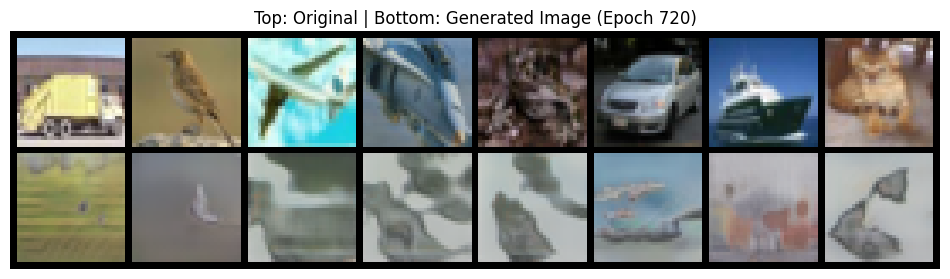

Epoch-721/1000: 100%|██████████| 782/782 [00:29<00:00, 26.61it/s, GenLoss=4.38, DisLoss=2.62, DisSteps=1]  


Generator Loss: 1.680075657927929
Discriminator Loss: 0.5175994867482758


Epoch-722/1000: 100%|██████████| 782/782 [00:26<00:00, 29.76it/s, GenLoss=4.73, DisLoss=1.39, DisSteps=1]  


Generator Loss: 1.5703986825235665
Discriminator Loss: 0.5438896029272957


Epoch-723/1000: 100%|██████████| 782/782 [00:15<00:00, 49.71it/s, GenLoss=3.46, DisLoss=0.87, DisSteps=1]  


Generator Loss: 1.7420714716700947
Discriminator Loss: 0.4905615474676232


Epoch-724/1000: 100%|██████████| 782/782 [00:17<00:00, 44.92it/s, GenLoss=7, DisLoss=2.57, DisSteps=1]     


Generator Loss: 1.740075053728145
Discriminator Loss: 0.5031006764191801


Epoch-725/1000: 100%|██████████| 782/782 [00:13<00:00, 56.03it/s, GenLoss=3.12, DisLoss=1.96, DisSteps=1]  


Generator Loss: 1.6236425802073515
Discriminator Loss: 0.5140601436195471


Epoch-726/1000: 100%|██████████| 782/782 [00:18<00:00, 43.15it/s, GenLoss=4.79, DisLoss=1.39, DisSteps=1]  


Generator Loss: 1.643342665889684
Discriminator Loss: 0.4942877717182764


Epoch-727/1000: 100%|██████████| 782/782 [00:15<00:00, 49.42it/s, GenLoss=3.63, DisLoss=1.09, DisSteps=1]  


Generator Loss: 1.701941955577382
Discriminator Loss: 0.4876263556844743


Epoch-728/1000: 100%|██████████| 782/782 [00:14<00:00, 55.26it/s, GenLoss=3.79, DisLoss=1.85, DisSteps=1]  


Generator Loss: 1.736959434226346
Discriminator Loss: 0.49508784364556413


Epoch-729/1000: 100%|██████████| 782/782 [00:14<00:00, 52.85it/s, GenLoss=4.27, DisLoss=1.13, DisSteps=1]  


Generator Loss: 1.790546759010276
Discriminator Loss: 0.45929962573835004


Epoch-730/1000: 100%|██████████| 782/782 [00:14<00:00, 53.74it/s, GenLoss=2.64, DisLoss=1.14, DisSteps=1]  


Generator Loss: 1.6847118266936763
Discriminator Loss: 0.4983113451534525


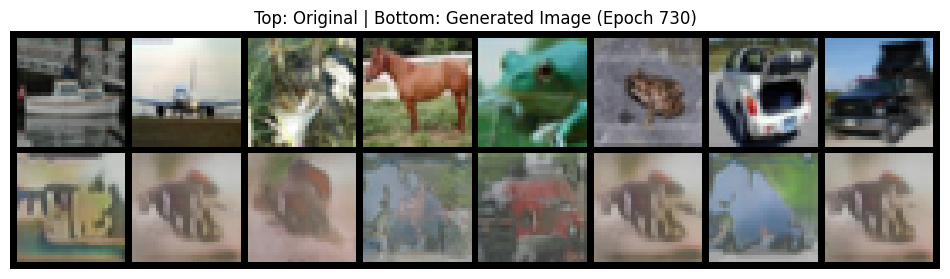

Epoch-731/1000: 100%|██████████| 782/782 [00:23<00:00, 33.30it/s, GenLoss=6.53, DisLoss=2.33, DisSteps=1]  


Generator Loss: 1.6920306868565358
Discriminator Loss: 0.49812307688967344


Epoch-732/1000: 100%|██████████| 782/782 [00:25<00:00, 30.98it/s, GenLoss=3.12, DisLoss=2.07, DisSteps=1]  


Generator Loss: 1.7805493766694422
Discriminator Loss: 0.4830694089993796


Epoch-733/1000: 100%|██████████| 782/782 [00:15<00:00, 49.44it/s, GenLoss=4.02, DisLoss=1.92, DisSteps=1]  


Generator Loss: 1.7034906036103779
Discriminator Loss: 0.5045897719424094


Epoch-734/1000: 100%|██████████| 782/782 [00:30<00:00, 26.01it/s, GenLoss=2.76, DisLoss=0.696, DisSteps=1] 


Generator Loss: 1.615031538983745
Discriminator Loss: 0.5016377446672801


Epoch-735/1000: 100%|██████████| 782/782 [00:19<00:00, 41.13it/s, GenLoss=5.83, DisLoss=1.45, DisSteps=1]  


Generator Loss: 1.6771593723455658
Discriminator Loss: 0.5136546916554651


Epoch-736/1000: 100%|██████████| 782/782 [00:14<00:00, 53.45it/s, GenLoss=2.48, DisLoss=1.51, DisSteps=1]  


Generator Loss: 1.7557549973964082
Discriminator Loss: 0.4871029146492024


Epoch-737/1000: 100%|██████████| 782/782 [00:15<00:00, 51.97it/s, GenLoss=6.6, DisLoss=0.575, DisSteps=1]  


Generator Loss: 1.7904126630414783
Discriminator Loss: 0.4615408458825572


Epoch-738/1000: 100%|██████████| 782/782 [00:21<00:00, 36.33it/s, GenLoss=3.7, DisLoss=0.734, DisSteps=1]  


Generator Loss: 1.672935189302925
Discriminator Loss: 0.5142139638285808


Epoch-739/1000: 100%|██████████| 782/782 [00:14<00:00, 54.85it/s, GenLoss=8.69, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.849246052067603
Discriminator Loss: 0.4650680381242576


Epoch-740/1000: 100%|██████████| 782/782 [00:14<00:00, 55.03it/s, GenLoss=4.77, DisLoss=1.74, DisSteps=1]  


Generator Loss: 1.7746907165059653
Discriminator Loss: 0.48245665764488527


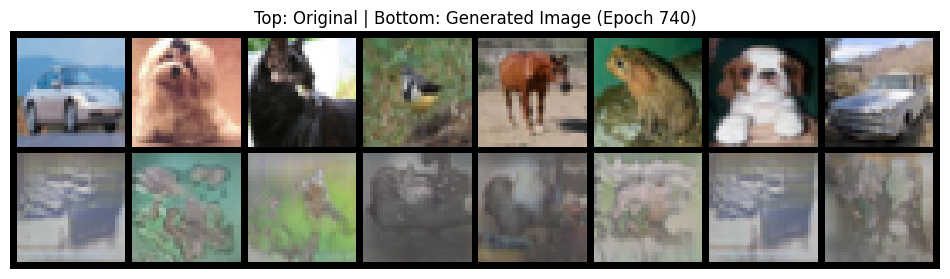

Epoch-741/1000: 100%|██████████| 782/782 [00:14<00:00, 52.41it/s, GenLoss=6.25, DisLoss=1.23, DisSteps=1]  


Generator Loss: 1.7078990567751857
Discriminator Loss: 0.5072515280274175


Epoch-742/1000: 100%|██████████| 782/782 [00:16<00:00, 48.44it/s, GenLoss=3.85, DisLoss=0.483, DisSteps=1] 


Generator Loss: 1.646460110269239
Discriminator Loss: 0.5157233658615891


Epoch-743/1000: 100%|██████████| 782/782 [00:20<00:00, 37.30it/s, GenLoss=5.39, DisLoss=1.89, DisSteps=1]  


Generator Loss: 1.8920448419383116
Discriminator Loss: 0.45186464156945955


Epoch-744/1000: 100%|██████████| 782/782 [00:14<00:00, 53.58it/s, GenLoss=6.45, DisLoss=0.87, DisSteps=1]  


Generator Loss: 1.9086632191220207
Discriminator Loss: 0.44766690326697384


Epoch-745/1000: 100%|██████████| 782/782 [00:16<00:00, 46.59it/s, GenLoss=4.63, DisLoss=2.04, DisSteps=1]  


Generator Loss: 1.6659199855745297
Discriminator Loss: 0.5045406060183749


Epoch-746/1000: 100%|██████████| 782/782 [00:29<00:00, 26.90it/s, GenLoss=5.28, DisLoss=2.62, DisSteps=1]  


Generator Loss: 1.7642170826111303
Discriminator Loss: 0.47724230631309394


Epoch-747/1000: 100%|██████████| 782/782 [00:19<00:00, 40.97it/s, GenLoss=4.99, DisLoss=0.708, DisSteps=1] 


Generator Loss: 1.7384084742849746
Discriminator Loss: 0.4937729032714958


Epoch-748/1000: 100%|██████████| 782/782 [00:15<00:00, 51.70it/s, GenLoss=7.07, DisLoss=0.534, DisSteps=1] 


Generator Loss: 1.7950619924480042
Discriminator Loss: 0.49091423198085304


Epoch-749/1000: 100%|██████████| 782/782 [00:15<00:00, 51.74it/s, GenLoss=2.53, DisLoss=0.936, DisSteps=1] 


Generator Loss: 1.8704395507607618
Discriminator Loss: 0.4791190908731097


Epoch-750/1000: 100%|██████████| 782/782 [00:14<00:00, 55.12it/s, GenLoss=4.85, DisLoss=0.276, DisSteps=1] 


Generator Loss: 1.8401056526948119
Discriminator Loss: 0.4631937671538509


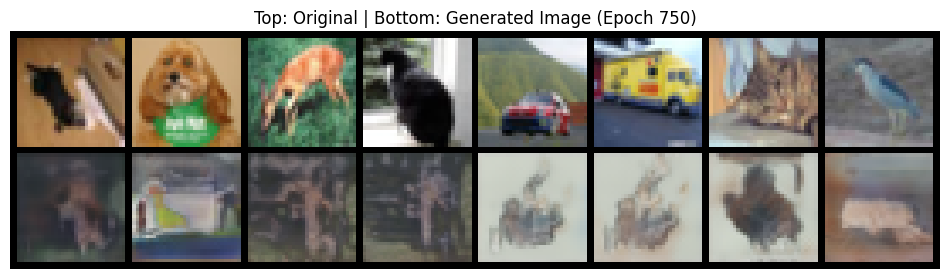

Epoch-751/1000: 100%|██████████| 782/782 [00:14<00:00, 52.47it/s, GenLoss=6.34, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.8647612181999493
Discriminator Loss: 0.4833140380470954


Epoch-752/1000: 100%|██████████| 782/782 [00:24<00:00, 31.45it/s, GenLoss=3.61, DisLoss=1.5, DisSteps=1]   


Generator Loss: 1.7227454265898756
Discriminator Loss: 0.49669116184763284


Epoch-753/1000: 100%|██████████| 782/782 [00:14<00:00, 54.12it/s, GenLoss=4.55, DisLoss=1.41, DisSteps=1]  


Generator Loss: 1.836007323944965
Discriminator Loss: 0.4586164293158085


Epoch-754/1000: 100%|██████████| 782/782 [00:14<00:00, 52.44it/s, GenLoss=3.1, DisLoss=1.64, DisSteps=1]   


Generator Loss: 1.8677445018230496
Discriminator Loss: 0.44925416293351544


Epoch-755/1000: 100%|██████████| 782/782 [00:14<00:00, 53.26it/s, GenLoss=1.9, DisLoss=1.16, DisSteps=1]   


Generator Loss: 1.6412618911784629
Discriminator Loss: 0.5134763325495488


Epoch-756/1000: 100%|██████████| 782/782 [00:22<00:00, 34.75it/s, GenLoss=7.48, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.610108244525807
Discriminator Loss: 0.5396395636832013


Epoch-757/1000: 100%|██████████| 782/782 [00:19<00:00, 40.95it/s, GenLoss=3.62, DisLoss=0.288, DisSteps=1] 


Generator Loss: 1.6975406524546617
Discriminator Loss: 0.5171529552363374


Epoch-758/1000: 100%|██████████| 782/782 [00:27<00:00, 28.70it/s, GenLoss=4.76, DisLoss=2.65, DisSteps=1]  


Generator Loss: 1.7500345676451388
Discriminator Loss: 0.4713854125279295


Epoch-759/1000: 100%|██████████| 782/782 [00:15<00:00, 50.29it/s, GenLoss=5.76, DisLoss=0.389, DisSteps=1] 


Generator Loss: 1.7480961130860517
Discriminator Loss: 0.46525691215263304


Epoch-760/1000: 100%|██████████| 782/782 [00:21<00:00, 36.75it/s, GenLoss=6.5, DisLoss=0.844, DisSteps=1]  


Generator Loss: 1.8507365039013841
Discriminator Loss: 0.4686811472029637


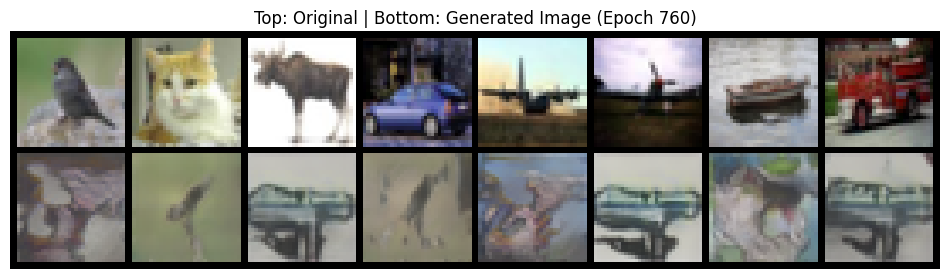

Epoch-761/1000: 100%|██████████| 782/782 [00:16<00:00, 46.65it/s, GenLoss=4.54, DisLoss=2.23, DisSteps=1]  


Generator Loss: 1.706662550111256
Discriminator Loss: 0.5014061369478245


Epoch-762/1000: 100%|██████████| 782/782 [00:15<00:00, 50.38it/s, GenLoss=1.28, DisLoss=1.01, DisSteps=1]  


Generator Loss: 1.5682210760843722
Discriminator Loss: 0.5677822422417228


Epoch-763/1000: 100%|██████████| 782/782 [00:20<00:00, 39.03it/s, GenLoss=6.77, DisLoss=0.849, DisSteps=1] 


Generator Loss: 1.534204934868971
Discriminator Loss: 0.5398461189683136


Epoch-764/1000: 100%|██████████| 782/782 [00:14<00:00, 53.38it/s, GenLoss=2.74, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.6065277544510028
Discriminator Loss: 0.5375606014829157


Epoch-765/1000: 100%|██████████| 782/782 [00:14<00:00, 54.58it/s, GenLoss=2.26, DisLoss=1.83, DisSteps=1]  


Generator Loss: 1.8062248422819025
Discriminator Loss: 0.489093510067219


Epoch-766/1000: 100%|██████████| 782/782 [00:16<00:00, 48.24it/s, GenLoss=3.65, DisLoss=0.838, DisSteps=1] 


Generator Loss: 1.795633551981443
Discriminator Loss: 0.4871611793327819


Epoch-767/1000: 100%|██████████| 782/782 [00:15<00:00, 51.38it/s, GenLoss=1.9, DisLoss=1.09, DisSteps=1]   


Generator Loss: 1.6697037178460898
Discriminator Loss: 0.4996549893370675


Epoch-768/1000: 100%|██████████| 782/782 [00:16<00:00, 46.69it/s, GenLoss=6.15, DisLoss=2.57, DisSteps=1]  


Generator Loss: 1.7895965762150563
Discriminator Loss: 0.47087571076343737


Epoch-769/1000: 100%|██████████| 782/782 [00:16<00:00, 46.39it/s, GenLoss=5.05, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.7714223359018335
Discriminator Loss: 0.4763164187750548


Epoch-770/1000: 100%|██████████| 782/782 [00:22<00:00, 34.59it/s, GenLoss=2.37, DisLoss=0.444, DisSteps=1] 


Generator Loss: 1.8345009031350656
Discriminator Loss: 0.46001284285579497


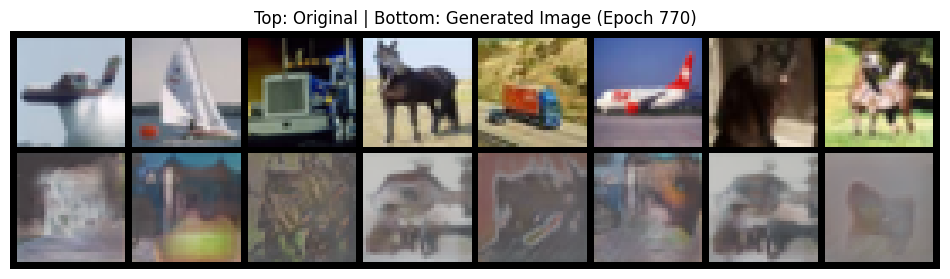

Epoch-771/1000: 100%|██████████| 782/782 [00:22<00:00, 34.47it/s, GenLoss=5.72, DisLoss=2.26, DisSteps=1]  


Generator Loss: 1.7061118461820475
Discriminator Loss: 0.5163728187570487


Epoch-772/1000: 100%|██████████| 782/782 [00:15<00:00, 51.90it/s, GenLoss=4.66, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.8207525749645574
Discriminator Loss: 0.46526563617274586


Epoch-773/1000: 100%|██████████| 782/782 [00:14<00:00, 53.99it/s, GenLoss=4.81, DisLoss=2.11, DisSteps=1]  


Generator Loss: 1.7032868722477532
Discriminator Loss: 0.5024951762707947


Epoch-774/1000: 100%|██████████| 782/782 [00:16<00:00, 46.01it/s, GenLoss=5.76, DisLoss=1.78, DisSteps=1]  


Generator Loss: 1.5918760235657168
Discriminator Loss: 0.5185111639330454


Epoch-775/1000: 100%|██████████| 782/782 [00:14<00:00, 53.67it/s, GenLoss=3.65, DisLoss=1.11, DisSteps=1]  


Generator Loss: 1.666970583102892
Discriminator Loss: 0.4869351609779136


Epoch-776/1000: 100%|██████████| 782/782 [00:14<00:00, 53.85it/s, GenLoss=3.68, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.6478280989867646
Discriminator Loss: 0.5045071056927256


Epoch-777/1000: 100%|██████████| 782/782 [00:14<00:00, 52.90it/s, GenLoss=3.52, DisLoss=0.649, DisSteps=1] 


Generator Loss: 1.650523872441038
Discriminator Loss: 0.49384757203747853


Epoch-778/1000: 100%|██████████| 782/782 [00:26<00:00, 29.11it/s, GenLoss=7.59, DisLoss=2.21, DisSteps=1]  


Generator Loss: 1.6701768382507212
Discriminator Loss: 0.5033089296935159


Epoch-779/1000: 100%|██████████| 782/782 [00:15<00:00, 51.56it/s, GenLoss=3.37, DisLoss=2.79, DisSteps=1]  


Generator Loss: 1.824632025969303
Discriminator Loss: 0.4755209543172966


Epoch-780/1000: 100%|██████████| 782/782 [00:21<00:00, 35.92it/s, GenLoss=3.21, DisLoss=1.74, DisSteps=1]  


Generator Loss: 1.6163827416765721
Discriminator Loss: 0.5230551115654009


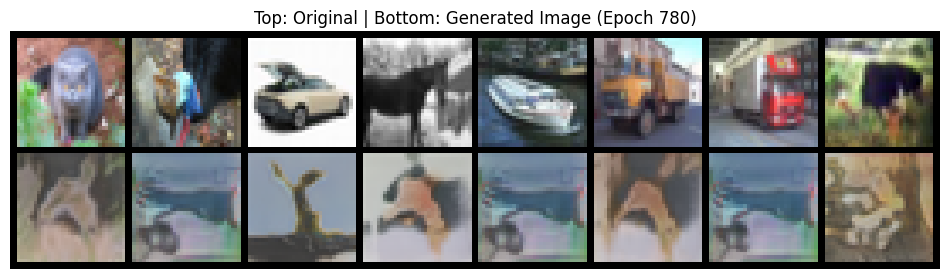

Epoch-781/1000: 100%|██████████| 782/782 [00:17<00:00, 44.98it/s, GenLoss=5.38, DisLoss=0.686, DisSteps=1] 


Generator Loss: 1.7147242760338137
Discriminator Loss: 0.4742374407208484


Epoch-782/1000: 100%|██████████| 782/782 [00:20<00:00, 38.97it/s, GenLoss=1.75, DisLoss=1.4, DisSteps=1]   


Generator Loss: 1.6139356425732299
Discriminator Loss: 0.5095610138972092


Epoch-783/1000: 100%|██████████| 782/782 [00:23<00:00, 33.79it/s, GenLoss=3.86, DisLoss=1.17, DisSteps=1]  


Generator Loss: 1.6793980771851966
Discriminator Loss: 0.5053596262393705


Epoch-784/1000: 100%|██████████| 782/782 [00:14<00:00, 52.92it/s, GenLoss=2.94, DisLoss=0.844, DisSteps=1] 


Generator Loss: 1.7754639023557648
Discriminator Loss: 0.4587448291537707


Epoch-785/1000: 100%|██████████| 782/782 [00:16<00:00, 48.76it/s, GenLoss=5.25, DisLoss=2.08, DisSteps=1]  


Generator Loss: 1.8748805045395556
Discriminator Loss: 0.4587532836191185


Epoch-786/1000: 100%|██████████| 782/782 [00:27<00:00, 28.20it/s, GenLoss=3.1, DisLoss=1.79, DisSteps=1]   


Generator Loss: 1.8905878876481215
Discriminator Loss: 0.45845753834832964


Epoch-787/1000: 100%|██████████| 782/782 [00:15<00:00, 49.95it/s, GenLoss=5.38, DisLoss=2.86, DisSteps=1]  


Generator Loss: 1.8673687077239347
Discriminator Loss: 0.4501166550056709


Epoch-788/1000: 100%|██████████| 782/782 [00:17<00:00, 45.26it/s, GenLoss=3.82, DisLoss=1.05, DisSteps=1]  


Generator Loss: 1.8605988891914373
Discriminator Loss: 0.45487415868684156


Epoch-789/1000: 100%|██████████| 782/782 [00:14<00:00, 55.26it/s, GenLoss=6.14, DisLoss=2.96, DisSteps=1]  


Generator Loss: 1.844961107158295
Discriminator Loss: 0.4671692371254077


Epoch-790/1000: 100%|██████████| 782/782 [00:16<00:00, 48.28it/s, GenLoss=6.11, DisLoss=0.335, DisSteps=1] 


Generator Loss: 1.8061100948039832
Discriminator Loss: 0.4808872154987682


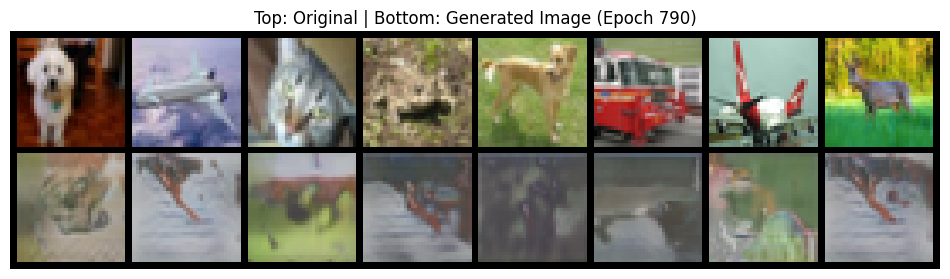

Epoch-791/1000: 100%|██████████| 782/782 [00:14<00:00, 52.14it/s, GenLoss=7.18, DisLoss=0.553, DisSteps=1] 


Generator Loss: 1.6913605078559397
Discriminator Loss: 0.5066796832186792


Epoch-792/1000: 100%|██████████| 782/782 [00:15<00:00, 51.28it/s, GenLoss=4.43, DisLoss=0.274, DisSteps=1] 


Generator Loss: 1.7624626198540563
Discriminator Loss: 0.4945554061961906


Epoch-793/1000: 100%|██████████| 782/782 [00:22<00:00, 34.42it/s, GenLoss=3.58, DisLoss=1.25, DisSteps=1]  


Generator Loss: 1.744545272853978
Discriminator Loss: 0.4972965333925184


Epoch-794/1000: 100%|██████████| 782/782 [00:18<00:00, 41.26it/s, GenLoss=3.74, DisLoss=0.252, DisSteps=1] 


Generator Loss: 1.751372609906794
Discriminator Loss: 0.49485886662893586


Epoch-795/1000: 100%|██████████| 782/782 [00:26<00:00, 30.01it/s, GenLoss=3.68, DisLoss=0.833, DisSteps=1] 


Generator Loss: 1.6008146942576484
Discriminator Loss: 0.5404322708354277


Epoch-796/1000: 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, GenLoss=5.7, DisLoss=0.717, DisSteps=1]  


Generator Loss: 1.6515381336212158
Discriminator Loss: 0.501734682037245


Epoch-797/1000: 100%|██████████| 782/782 [00:18<00:00, 42.07it/s, GenLoss=5.31, DisLoss=2.59, DisSteps=1]  


Generator Loss: 1.7221573025674162
Discriminator Loss: 0.48683532645635286


Epoch-798/1000: 100%|██████████| 782/782 [00:15<00:00, 49.88it/s, GenLoss=2.56, DisLoss=1.63, DisSteps=1]  


Generator Loss: 1.6689245628807552
Discriminator Loss: 0.5157200144913495


Epoch-799/1000: 100%|██████████| 782/782 [00:14<00:00, 55.81it/s, GenLoss=5.93, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.6100407696288566
Discriminator Loss: 0.5158630399524099


Epoch-800/1000: 100%|██████████| 782/782 [00:15<00:00, 51.92it/s, GenLoss=5.07, DisLoss=1.52, DisSteps=1]  


Generator Loss: 1.7386946933501213
Discriminator Loss: 0.48725280392429104


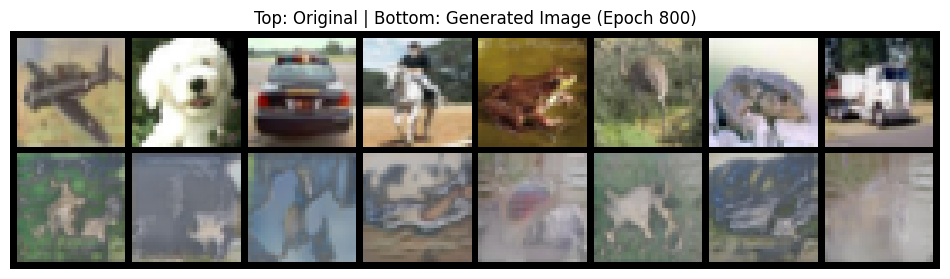

Epoch-801/1000: 100%|██████████| 782/782 [00:14<00:00, 53.94it/s, GenLoss=1.89, DisLoss=1.39, DisSteps=1]  


Generator Loss: 1.7926721042760498
Discriminator Loss: 0.47904143815912553


Epoch-802/1000: 100%|██████████| 782/782 [00:14<00:00, 54.09it/s, GenLoss=3.81, DisLoss=1.92, DisSteps=1]  


Generator Loss: 1.7775319670815297
Discriminator Loss: 0.47087558917224864


Epoch-803/1000: 100%|██████████| 782/782 [00:23<00:00, 33.81it/s, GenLoss=2.06, DisLoss=1.23, DisSteps=1]  


Generator Loss: 1.7786593338870027
Discriminator Loss: 0.4605636443857037


Epoch-804/1000: 100%|██████████| 782/782 [00:15<00:00, 49.80it/s, GenLoss=3.97, DisLoss=0.517, DisSteps=1] 


Generator Loss: 2.020647868723668
Discriminator Loss: 0.43744926899671555


Epoch-805/1000: 100%|██████████| 782/782 [00:14<00:00, 53.17it/s, GenLoss=6.44, DisLoss=0.661, DisSteps=1] 


Generator Loss: 1.8883211525047527
Discriminator Loss: 0.4672592877388915


Epoch-806/1000: 100%|██████████| 782/782 [00:16<00:00, 47.40it/s, GenLoss=2.37, DisLoss=1.4, DisSteps=1]   


Generator Loss: 1.8939367182876752
Discriminator Loss: 0.48421419002211


Epoch-807/1000: 100%|██████████| 782/782 [00:15<00:00, 49.86it/s, GenLoss=6.88, DisLoss=3.29, DisSteps=1]  


Generator Loss: 1.8919035083497577
Discriminator Loss: 0.46689998953010114


Epoch-808/1000: 100%|██████████| 782/782 [00:14<00:00, 54.00it/s, GenLoss=3.56, DisLoss=2.33, DisSteps=1]  


Generator Loss: 1.9570962064863775
Discriminator Loss: 0.42091454193948785


Epoch-809/1000: 100%|██████████| 782/782 [00:13<00:00, 55.88it/s, GenLoss=3.62, DisLoss=2.19, DisSteps=1]  


Generator Loss: 1.9625751648641303
Discriminator Loss: 0.425967235985162


Epoch-810/1000: 100%|██████████| 782/782 [00:15<00:00, 51.96it/s, GenLoss=2.09, DisLoss=1.38, DisSteps=1]  


Generator Loss: 1.9241653051217804
Discriminator Loss: 0.42317495245457915


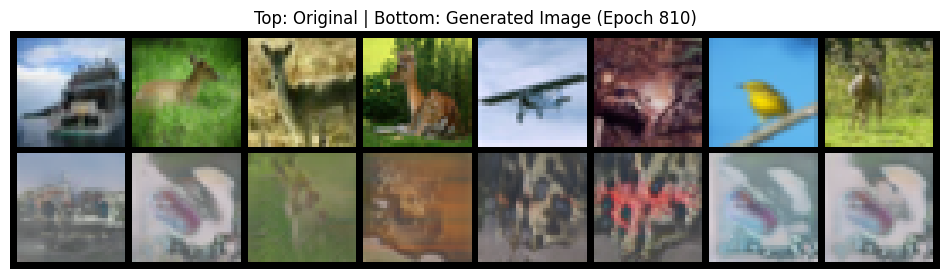

Epoch-811/1000: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s, GenLoss=2.97, DisLoss=1.79, DisSteps=1]  


Generator Loss: 1.8577149168533438
Discriminator Loss: 0.4674465337296581


Epoch-812/1000: 100%|██████████| 782/782 [00:14<00:00, 52.38it/s, GenLoss=4.08, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.8755477586823046
Discriminator Loss: 0.47892626607433303


Epoch-813/1000: 100%|██████████| 782/782 [00:18<00:00, 41.40it/s, GenLoss=5.76, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.8732502885029445
Discriminator Loss: 0.45268773622906117


Epoch-814/1000: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s, GenLoss=3.62, DisLoss=1.45, DisSteps=1]  


Generator Loss: 1.7171452837755612
Discriminator Loss: 0.5075427290347531


Epoch-815/1000: 100%|██████████| 782/782 [00:26<00:00, 29.46it/s, GenLoss=6.66, DisLoss=1.09, DisSteps=1]  


Generator Loss: 1.7375961220858958
Discriminator Loss: 0.4773257723664079


Epoch-816/1000: 100%|██████████| 782/782 [00:15<00:00, 52.01it/s, GenLoss=3.63, DisLoss=1.01, DisSteps=1]  


Generator Loss: 1.6639495132981663
Discriminator Loss: 0.5037379308849039


Epoch-817/1000: 100%|██████████| 782/782 [00:14<00:00, 53.60it/s, GenLoss=4.24, DisLoss=1.05, DisSteps=1]  


Generator Loss: 1.5887227687994232
Discriminator Loss: 0.5335175474090954


Epoch-818/1000: 100%|██████████| 782/782 [00:15<00:00, 50.62it/s, GenLoss=4.93, DisLoss=1.52, DisSteps=1]  


Generator Loss: 1.7253053163361671
Discriminator Loss: 0.5097245956435228


Epoch-819/1000: 100%|██████████| 782/782 [00:15<00:00, 51.73it/s, GenLoss=3.36, DisLoss=0.522, DisSteps=1] 


Generator Loss: 1.7808513679467808
Discriminator Loss: 0.48591084275251767


Epoch-820/1000: 100%|██████████| 782/782 [00:14<00:00, 54.69it/s, GenLoss=4.48, DisLoss=1, DisSteps=1]     


Generator Loss: 1.760250866679889
Discriminator Loss: 0.4815176991779176


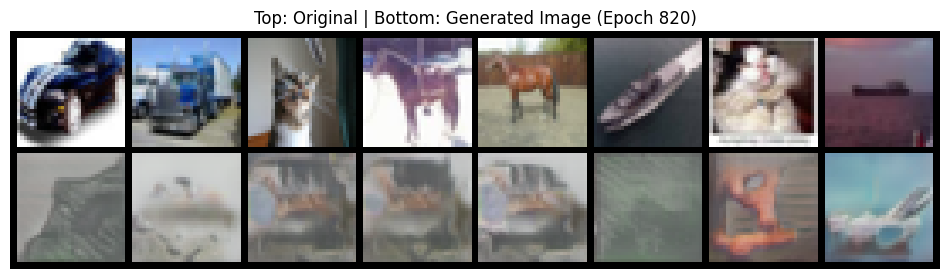

Epoch-821/1000: 100%|██████████| 782/782 [00:14<00:00, 54.01it/s, GenLoss=5.36, DisLoss=1.08, DisSteps=1]  


Generator Loss: 1.753141141417996
Discriminator Loss: 0.4919772641661832


Epoch-822/1000: 100%|██████████| 782/782 [00:18<00:00, 41.28it/s, GenLoss=3.56, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.690756566346149
Discriminator Loss: 0.49164113217531263


Epoch-823/1000: 100%|██████████| 782/782 [00:14<00:00, 52.76it/s, GenLoss=4.46, DisLoss=0.743, DisSteps=1] 


Generator Loss: 1.7091610791814296
Discriminator Loss: 0.5093123581822571


Epoch-824/1000: 100%|██████████| 782/782 [00:16<00:00, 48.03it/s, GenLoss=4.98, DisLoss=0.43, DisSteps=1]  


Generator Loss: 1.7691499427761264
Discriminator Loss: 0.4708463982547945


Epoch-825/1000: 100%|██████████| 782/782 [00:17<00:00, 45.17it/s, GenLoss=3.66, DisLoss=1.16, DisSteps=1]  


Generator Loss: 1.771631720082839
Discriminator Loss: 0.4884206410449789


Epoch-826/1000: 100%|██████████| 782/782 [00:14<00:00, 55.27it/s, GenLoss=4.67, DisLoss=0.89, DisSteps=1]  


Generator Loss: 1.7312588016395374
Discriminator Loss: 0.4975300565209535


Epoch-827/1000: 100%|██████████| 782/782 [00:14<00:00, 52.33it/s, GenLoss=5.03, DisLoss=0.77, DisSteps=1]  


Generator Loss: 1.8339714624768937
Discriminator Loss: 0.46003520715495816


Epoch-828/1000: 100%|██████████| 782/782 [00:14<00:00, 52.37it/s, GenLoss=6.08, DisLoss=0.701, DisSteps=1] 


Generator Loss: 1.8921109384587964
Discriminator Loss: 0.4639203779570892


Epoch-829/1000: 100%|██████████| 782/782 [00:16<00:00, 47.39it/s, GenLoss=3.55, DisLoss=1.83, DisSteps=1]  


Generator Loss: 1.9094965627888585
Discriminator Loss: 0.4684086057078808


Epoch-830/1000: 100%|██████████| 782/782 [00:15<00:00, 49.43it/s, GenLoss=1.58, DisLoss=1.34, DisSteps=1]  


Generator Loss: 1.796940442508139
Discriminator Loss: 0.4745035903799869


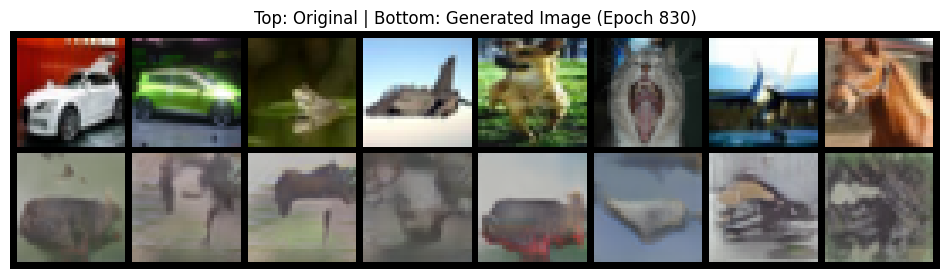

Epoch-831/1000: 100%|██████████| 782/782 [00:22<00:00, 34.61it/s, GenLoss=2.59, DisLoss=0.441, DisSteps=1] 


Generator Loss: 1.7508844415397595
Discriminator Loss: 0.48553312651793973


Epoch-832/1000: 100%|██████████| 782/782 [00:23<00:00, 33.48it/s, GenLoss=3.23, DisLoss=2.8, DisSteps=1]   


Generator Loss: 1.8145257838241888
Discriminator Loss: 0.44802840745738703


Epoch-833/1000: 100%|██████████| 782/782 [00:15<00:00, 49.82it/s, GenLoss=4.91, DisLoss=1.67, DisSteps=1]  


Generator Loss: 1.716281210065193
Discriminator Loss: 0.5017280823472515


Epoch-834/1000: 100%|██████████| 782/782 [00:18<00:00, 42.42it/s, GenLoss=6.18, DisLoss=2.25, DisSteps=1]  


Generator Loss: 1.850593936641503
Discriminator Loss: 0.4771996098177512


Epoch-835/1000: 100%|██████████| 782/782 [00:18<00:00, 42.00it/s, GenLoss=5.27, DisLoss=1.99, DisSteps=1]  


Generator Loss: 1.7497603503791876
Discriminator Loss: 0.5011754416100814


Epoch-836/1000: 100%|██████████| 782/782 [00:15<00:00, 50.15it/s, GenLoss=5.79, DisLoss=3.07, DisSteps=1]  


Generator Loss: 1.6549147578227856
Discriminator Loss: 0.5314327451922095


Epoch-837/1000: 100%|██████████| 782/782 [00:14<00:00, 52.89it/s, GenLoss=3.04, DisLoss=1.84, DisSteps=1]  


Generator Loss: 1.7636503398113543
Discriminator Loss: 0.47919881782111


Epoch-838/1000: 100%|██████████| 782/782 [00:14<00:00, 54.43it/s, GenLoss=4.32, DisLoss=1.36, DisSteps=1]  


Generator Loss: 1.753160844945237
Discriminator Loss: 0.5114819411464664


Epoch-839/1000: 100%|██████████| 782/782 [00:20<00:00, 38.70it/s, GenLoss=0.582, DisLoss=1.26, DisSteps=1] 


Generator Loss: 1.6995609543283883
Discriminator Loss: 0.4828732576021148


Epoch-840/1000: 100%|██████████| 782/782 [00:17<00:00, 44.41it/s, GenLoss=4.41, DisLoss=1.62, DisSteps=1]  


Generator Loss: 1.6621571228937115
Discriminator Loss: 0.5149839636500534


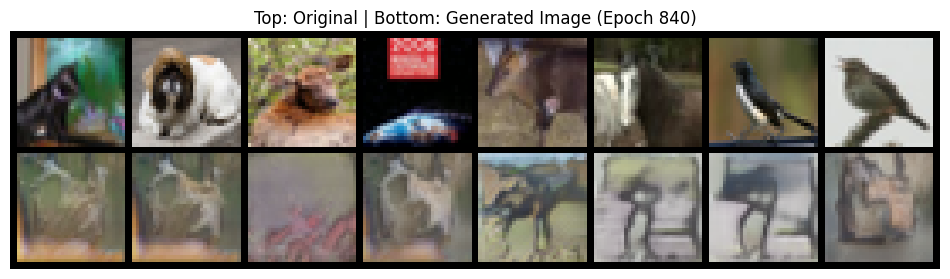

Epoch-841/1000: 100%|██████████| 782/782 [00:13<00:00, 55.89it/s, GenLoss=2.78, DisLoss=2.69, DisSteps=1]  


Generator Loss: 1.7068296171667632
Discriminator Loss: 0.5082047111390496


Epoch-842/1000: 100%|██████████| 782/782 [00:14<00:00, 55.07it/s, GenLoss=4.99, DisLoss=2.02, DisSteps=1]  


Generator Loss: 1.5259723685053
Discriminator Loss: 0.5675522069187116


Epoch-843/1000: 100%|██████████| 782/782 [00:15<00:00, 50.39it/s, GenLoss=4.18, DisLoss=2.53, DisSteps=1]  


Generator Loss: 1.7049483970912827
Discriminator Loss: 0.48948119207263907


Epoch-844/1000: 100%|██████████| 782/782 [00:14<00:00, 53.16it/s, GenLoss=3.27, DisLoss=0.541, DisSteps=1] 


Generator Loss: 1.6693469778351162
Discriminator Loss: 0.5059183561779044


Epoch-845/1000: 100%|██████████| 782/782 [00:13<00:00, 56.10it/s, GenLoss=4.38, DisLoss=1.68, DisSteps=1]  


Generator Loss: 1.682729262410832
Discriminator Loss: 0.5185044522175704


Epoch-846/1000: 100%|██████████| 782/782 [00:14<00:00, 54.30it/s, GenLoss=7.09, DisLoss=1.36, DisSteps=1]  


Generator Loss: 1.720258500112597
Discriminator Loss: 0.49294499065869907


Epoch-847/1000: 100%|██████████| 782/782 [00:19<00:00, 41.09it/s, GenLoss=6.36, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.741583959983133
Discriminator Loss: 0.4921422657911735


Epoch-848/1000: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, GenLoss=3.52, DisLoss=0.45, DisSteps=1]  


Generator Loss: 1.8723336280611775
Discriminator Loss: 0.45579810179484165


Epoch-849/1000: 100%|██████████| 782/782 [00:33<00:00, 23.06it/s, GenLoss=5.41, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.9258601674643319
Discriminator Loss: 0.46112846672687385


Epoch-850/1000: 100%|██████████| 782/782 [00:38<00:00, 20.07it/s, GenLoss=4.19, DisLoss=1.15, DisSteps=1]  


Generator Loss: 1.7513533279185405
Discriminator Loss: 0.49904503031155034


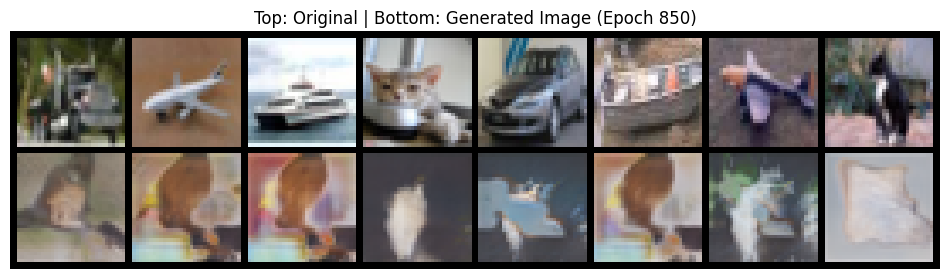

Epoch-851/1000: 100%|██████████| 782/782 [00:18<00:00, 42.54it/s, GenLoss=2.93, DisLoss=1.31, DisSteps=1]  


Generator Loss: 1.6723981147913067
Discriminator Loss: 0.5026420930309978


Epoch-852/1000: 100%|██████████| 782/782 [00:15<00:00, 51.72it/s, GenLoss=5.46, DisLoss=2.07, DisSteps=1]  


Generator Loss: 1.6135072962326162
Discriminator Loss: 0.5176194438048641


Epoch-853/1000: 100%|██████████| 782/782 [00:14<00:00, 54.59it/s, GenLoss=6.8, DisLoss=1.96, DisSteps=1]   


Generator Loss: 1.6274993209658986
Discriminator Loss: 0.5094272320532738


Epoch-854/1000: 100%|██████████| 782/782 [00:14<00:00, 54.88it/s, GenLoss=4.5, DisLoss=0.926, DisSteps=1]  


Generator Loss: 1.6828878076789935
Discriminator Loss: 0.48893591109901435


Epoch-855/1000: 100%|██████████| 782/782 [00:25<00:00, 30.67it/s, GenLoss=3.52, DisLoss=1.45, DisSteps=1]  


Generator Loss: 1.7759822758719743
Discriminator Loss: 0.46078962571633136


Epoch-856/1000: 100%|██████████| 782/782 [00:19<00:00, 41.09it/s, GenLoss=5, DisLoss=1.33, DisSteps=1]     


Generator Loss: 1.8052725288874047
Discriminator Loss: 0.46072593388502553


Epoch-857/1000: 100%|██████████| 782/782 [00:14<00:00, 53.04it/s, GenLoss=4.63, DisLoss=1.66, DisSteps=1]  


Generator Loss: 1.8730127202427906
Discriminator Loss: 0.4447505623102188


Epoch-858/1000: 100%|██████████| 782/782 [00:14<00:00, 53.86it/s, GenLoss=3.95, DisLoss=1.56, DisSteps=1]  


Generator Loss: 1.871929680904769
Discriminator Loss: 0.4523579206155694


Epoch-859/1000: 100%|██████████| 782/782 [00:22<00:00, 34.71it/s, GenLoss=3.09, DisLoss=0.875, DisSteps=1] 


Generator Loss: 1.6251032861602275
Discriminator Loss: 0.5117953631388562


Epoch-860/1000: 100%|██████████| 782/782 [00:17<00:00, 43.63it/s, GenLoss=1.97, DisLoss=0.799, DisSteps=1] 


Generator Loss: 1.7251167553083977
Discriminator Loss: 0.47389912300402554


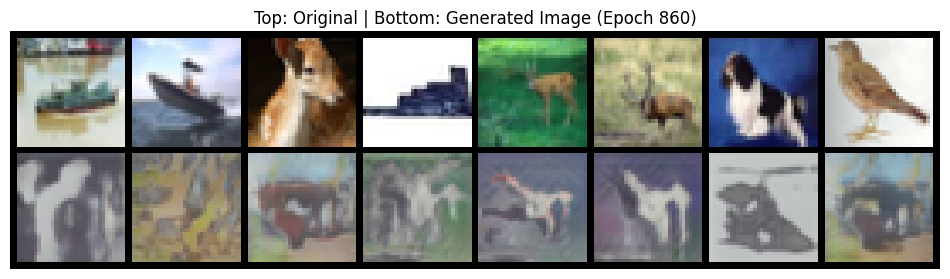

Epoch-861/1000: 100%|██████████| 782/782 [00:18<00:00, 41.97it/s, GenLoss=2.02, DisLoss=0.851, DisSteps=1] 


Generator Loss: 2.016510156414393
Discriminator Loss: 0.44315408408413154


Epoch-862/1000: 100%|██████████| 782/782 [00:20<00:00, 37.46it/s, GenLoss=3.31, DisLoss=0.462, DisSteps=1] 


Generator Loss: 2.082872447569657
Discriminator Loss: 0.44074214802449924


Epoch-863/1000: 100%|██████████| 782/782 [00:34<00:00, 22.58it/s, GenLoss=2.52, DisLoss=0.902, DisSteps=1] 


Generator Loss: 1.9358696658974108
Discriminator Loss: 0.44121899728275016


Epoch-864/1000: 100%|██████████| 782/782 [00:14<00:00, 52.38it/s, GenLoss=6.17, DisLoss=0.875, DisSteps=1] 


Generator Loss: 1.7402914126815698
Discriminator Loss: 0.47086154461821633


Epoch-865/1000: 100%|██████████| 782/782 [00:14<00:00, 52.18it/s, GenLoss=4.07, DisLoss=0.583, DisSteps=1] 


Generator Loss: 1.836984072614204
Discriminator Loss: 0.44781149228286865


Epoch-866/1000: 100%|██████████| 782/782 [00:15<00:00, 52.11it/s, GenLoss=3.42, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.792721836387044
Discriminator Loss: 0.47514228736195724


Epoch-867/1000: 100%|██████████| 782/782 [00:22<00:00, 34.43it/s, GenLoss=5.45, DisLoss=1.92, DisSteps=1]  


Generator Loss: 1.724527864390627
Discriminator Loss: 0.4968822378560405


Epoch-868/1000: 100%|██████████| 782/782 [00:14<00:00, 53.94it/s, GenLoss=2.95, DisLoss=3.5, DisSteps=1]   


Generator Loss: 1.6458356076722864
Discriminator Loss: 0.5058878130467651


Epoch-869/1000: 100%|██████████| 782/782 [00:18<00:00, 41.43it/s, GenLoss=2.75, DisLoss=2.85, DisSteps=1]  


Generator Loss: 1.7275850500368402
Discriminator Loss: 0.48780780317990674


Epoch-870/1000: 100%|██████████| 782/782 [00:15<00:00, 50.52it/s, GenLoss=5.03, DisLoss=1.64, DisSteps=1]  


Generator Loss: 1.6948435814941631
Discriminator Loss: 0.487996135030866


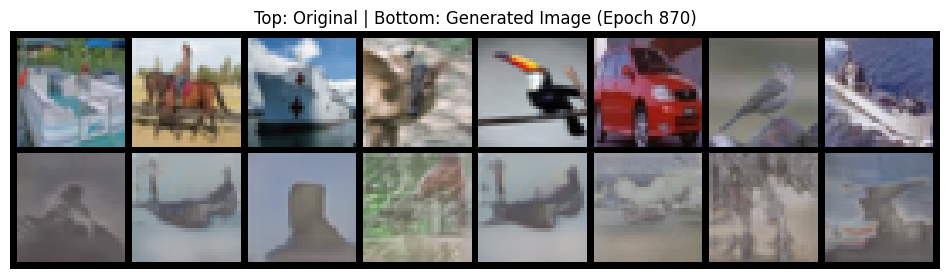

Epoch-871/1000: 100%|██████████| 782/782 [00:20<00:00, 38.97it/s, GenLoss=6.97, DisLoss=1.4, DisSteps=1]   


Generator Loss: 1.752674719142487
Discriminator Loss: 0.48838279125711803


Epoch-872/1000: 100%|██████████| 782/782 [00:22<00:00, 34.27it/s, GenLoss=4.39, DisLoss=0.251, DisSteps=1]  


Generator Loss: 1.6797099880435888
Discriminator Loss: 0.5139324441933266


Epoch-873/1000: 100%|██████████| 782/782 [00:14<00:00, 53.92it/s, GenLoss=6.36, DisLoss=2.32, DisSteps=1]  


Generator Loss: 1.7400187084360805
Discriminator Loss: 0.522186492372047


Epoch-874/1000: 100%|██████████| 782/782 [00:16<00:00, 48.76it/s, GenLoss=4.31, DisLoss=0.927, DisSteps=1] 


Generator Loss: 1.6632389879744987
Discriminator Loss: 0.519166667023888


Epoch-875/1000: 100%|██████████| 782/782 [00:18<00:00, 42.29it/s, GenLoss=4.04, DisLoss=0.88, DisSteps=1]  


Generator Loss: 1.769669400227954
Discriminator Loss: 0.4775559741936986


Epoch-876/1000: 100%|██████████| 782/782 [00:16<00:00, 48.52it/s, GenLoss=3.82, DisLoss=2.15, DisSteps=1]  


Generator Loss: 1.957029029612651
Discriminator Loss: 0.4495989091103644


Epoch-877/1000: 100%|██████████| 782/782 [00:25<00:00, 30.23it/s, GenLoss=4.04, DisLoss=2.42, DisSteps=1]  


Generator Loss: 1.8154033738786302
Discriminator Loss: 0.4510660630167293


Epoch-878/1000: 100%|██████████| 782/782 [00:19<00:00, 39.34it/s, GenLoss=3.45, DisLoss=0.882, DisSteps=1] 


Generator Loss: 1.623058207428364
Discriminator Loss: 0.49251837426286826


Epoch-879/1000: 100%|██████████| 782/782 [00:20<00:00, 37.68it/s, GenLoss=4.32, DisLoss=1.98, DisSteps=1]  


Generator Loss: 1.715011404641449
Discriminator Loss: 0.49171608253894256


Epoch-880/1000: 100%|██████████| 782/782 [00:21<00:00, 36.12it/s, GenLoss=4.97, DisLoss=1.21, DisSteps=1]  


Generator Loss: 1.6375203828143952
Discriminator Loss: 0.5228397889286661


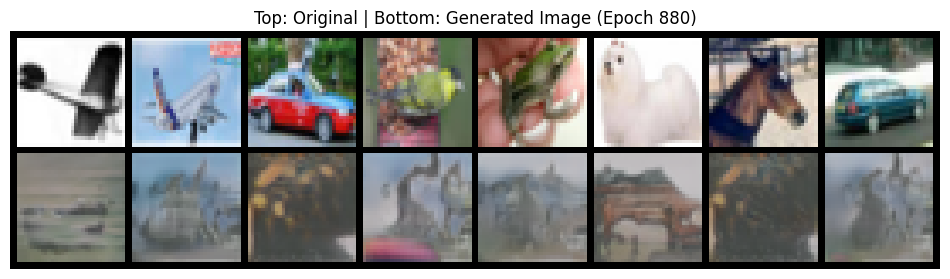

Epoch-881/1000: 100%|██████████| 782/782 [00:15<00:00, 50.43it/s, GenLoss=5.66, DisLoss=1.87, DisSteps=1]  


Generator Loss: 1.7807918359785129
Discriminator Loss: 0.4739489245140339


Epoch-882/1000: 100%|██████████| 782/782 [00:14<00:00, 54.34it/s, GenLoss=4.77, DisLoss=0.594, DisSteps=1] 


Generator Loss: 1.7562389719440503
Discriminator Loss: 0.4842058395028419


Epoch-883/1000: 100%|██████████| 782/782 [00:18<00:00, 41.56it/s, GenLoss=5.44, DisLoss=1.83, DisSteps=1]  


Generator Loss: 2.0137994997108075
Discriminator Loss: 0.4116583033786405


Epoch-884/1000: 100%|██████████| 782/782 [00:21<00:00, 35.59it/s, GenLoss=5.43, DisLoss=1.7, DisSteps=1]   


Generator Loss: 1.8985928794764497
Discriminator Loss: 0.4592318859170465


Epoch-885/1000: 100%|██████████| 782/782 [00:18<00:00, 41.16it/s, GenLoss=5.81, DisLoss=0.72, DisSteps=1]  


Generator Loss: 1.8125984360799765
Discriminator Loss: 0.4479169741730251


Epoch-886/1000: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s, GenLoss=4.58, DisLoss=1.13, DisSteps=1]  


Generator Loss: 1.7883890942691842
Discriminator Loss: 0.46218153639979986


Epoch-887/1000: 100%|██████████| 782/782 [00:16<00:00, 47.42it/s, GenLoss=3.66, DisLoss=0.203, DisSteps=1] 


Generator Loss: 1.8136932830066632
Discriminator Loss: 0.4795308488866557


Epoch-888/1000: 100%|██████████| 782/782 [00:14<00:00, 52.76it/s, GenLoss=2.9, DisLoss=1.68, DisSteps=1]   


Generator Loss: 1.6741520426309933
Discriminator Loss: 0.5036420878737479


Epoch-889/1000: 100%|██████████| 782/782 [00:15<00:00, 51.87it/s, GenLoss=2.4, DisLoss=2.75, DisSteps=1]   


Generator Loss: 1.6911660316197767
Discriminator Loss: 0.5009340474672634


Epoch-890/1000: 100%|██████████| 782/782 [00:19<00:00, 40.94it/s, GenLoss=4.2, DisLoss=1.78, DisSteps=1]   


Generator Loss: 1.6327886981579958
Discriminator Loss: 0.5383362326475666


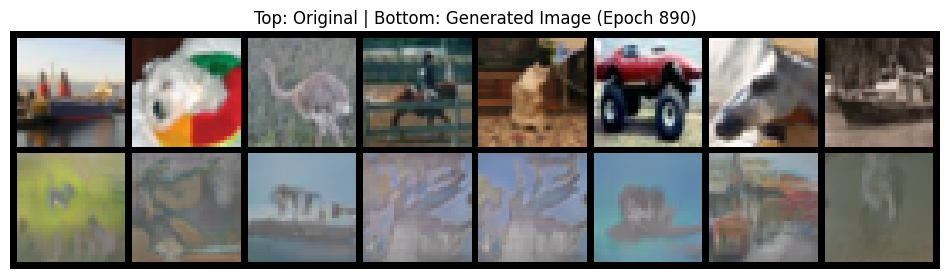

Epoch-891/1000: 100%|██████████| 782/782 [00:15<00:00, 51.94it/s, GenLoss=4.14, DisLoss=2.17, DisSteps=1]  


Generator Loss: 1.6423518058589048
Discriminator Loss: 0.5091338545808097


Epoch-892/1000: 100%|██████████| 782/782 [00:14<00:00, 53.66it/s, GenLoss=5.1, DisLoss=1.68, DisSteps=1]   


Generator Loss: 1.6048941423978342
Discriminator Loss: 0.5351151910889179


Epoch-893/1000: 100%|██████████| 782/782 [00:16<00:00, 48.28it/s, GenLoss=5.31, DisLoss=0.474, DisSteps=1] 


Generator Loss: 1.7202982263415671
Discriminator Loss: 0.49424621142694714


Epoch-894/1000: 100%|██████████| 782/782 [00:25<00:00, 30.93it/s, GenLoss=1.98, DisLoss=1.1, DisSteps=1]   


Generator Loss: 1.5595996044861995
Discriminator Loss: 0.5481054962367353


Epoch-895/1000: 100%|██████████| 782/782 [00:20<00:00, 38.38it/s, GenLoss=2.1, DisLoss=0.674, DisSteps=1]  


Generator Loss: 1.6240406819164295
Discriminator Loss: 0.5139895201567799


Epoch-896/1000: 100%|██████████| 782/782 [00:25<00:00, 30.64it/s, GenLoss=3.05, DisLoss=0.269, DisSteps=1] 


Generator Loss: 1.5610228815804357
Discriminator Loss: 0.5182151577204389


Epoch-897/1000: 100%|██████████| 782/782 [00:27<00:00, 28.90it/s, GenLoss=6.58, DisLoss=1.86, DisSteps=1]  


Generator Loss: 1.6832451031488531
Discriminator Loss: 0.5228805686621105


Epoch-898/1000: 100%|██████████| 782/782 [00:17<00:00, 44.62it/s, GenLoss=2.96, DisLoss=0.751, DisSteps=1] 


Generator Loss: 1.6118671256486716
Discriminator Loss: 0.5256481042412846


Epoch-899/1000: 100%|██████████| 782/782 [00:14<00:00, 53.75it/s, GenLoss=5.37, DisLoss=1.36, DisSteps=1]  


Generator Loss: 1.6564640398982846
Discriminator Loss: 0.49078575750369857


Epoch-900/1000: 100%|██████████| 782/782 [00:22<00:00, 34.25it/s, GenLoss=4.19, DisLoss=0.636, DisSteps=1] 


Generator Loss: 1.7847496510466652
Discriminator Loss: 0.4729498340117047


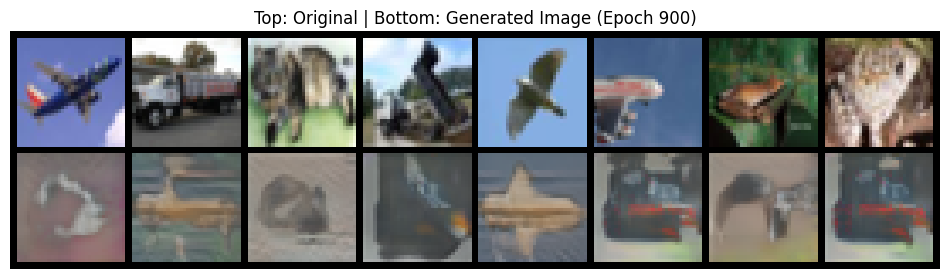

Epoch-901/1000: 100%|██████████| 782/782 [00:17<00:00, 44.70it/s, GenLoss=3.95, DisLoss=1.16, DisSteps=1]  


Generator Loss: 1.79113417486553
Discriminator Loss: 0.4615180867978984


Epoch-902/1000: 100%|██████████| 782/782 [00:15<00:00, 51.23it/s, GenLoss=2.52, DisLoss=2.48, DisSteps=1]  


Generator Loss: 1.710693151520951
Discriminator Loss: 0.4847468565720731


Epoch-903/1000: 100%|██████████| 782/782 [00:14<00:00, 52.63it/s, GenLoss=5.31, DisLoss=0.78, DisSteps=1]  


Generator Loss: 1.713429427588992
Discriminator Loss: 0.49053942351161367


Epoch-904/1000: 100%|██████████| 782/782 [00:14<00:00, 52.35it/s, GenLoss=3.67, DisLoss=1.54, DisSteps=1]  


Generator Loss: 1.7795338690509577
Discriminator Loss: 0.48167002031489103


Epoch-905/1000: 100%|██████████| 782/782 [00:17<00:00, 45.41it/s, GenLoss=2.7, DisLoss=1.76, DisSteps=1]   


Generator Loss: 1.6773991457489141
Discriminator Loss: 0.4897469418394901


Epoch-906/1000: 100%|██████████| 782/782 [00:14<00:00, 53.47it/s, GenLoss=2.48, DisLoss=1.36, DisSteps=1]  


Generator Loss: 1.7863346113801917
Discriminator Loss: 0.48066097002505037


Epoch-907/1000: 100%|██████████| 782/782 [00:14<00:00, 53.79it/s, GenLoss=5.4, DisLoss=1.77, DisSteps=1]   


Generator Loss: 1.8799170719845522
Discriminator Loss: 0.45253239059463485


Epoch-908/1000: 100%|██████████| 782/782 [00:14<00:00, 53.60it/s, GenLoss=7.27, DisLoss=0.247, DisSteps=1] 


Generator Loss: 1.668918274552621
Discriminator Loss: 0.5302429070977299


Epoch-909/1000: 100%|██████████| 782/782 [00:14<00:00, 53.24it/s, GenLoss=3.55, DisLoss=1.43, DisSteps=1]  


Generator Loss: 1.7193057629305992
Discriminator Loss: 0.4967887917785998


Epoch-910/1000: 100%|██████████| 782/782 [00:18<00:00, 42.15it/s, GenLoss=4.45, DisLoss=0.63, DisSteps=1]  


Generator Loss: 1.679881517158445
Discriminator Loss: 0.5067944126132199


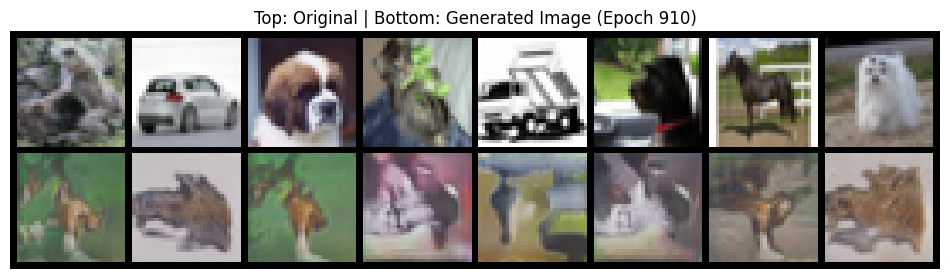

Epoch-911/1000: 100%|██████████| 782/782 [00:26<00:00, 29.80it/s, GenLoss=5.13, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.8392322998674935
Discriminator Loss: 0.48584588436062076


Epoch-912/1000: 100%|██████████| 782/782 [00:25<00:00, 30.66it/s, GenLoss=5.26, DisLoss=1.91, DisSteps=1]  


Generator Loss: 1.7959545349983304
Discriminator Loss: 0.4767577685511021


Epoch-913/1000: 100%|██████████| 782/782 [00:19<00:00, 40.65it/s, GenLoss=5.91, DisLoss=1.57, DisSteps=1]  


Generator Loss: 1.879184022774477
Discriminator Loss: 0.45204485007716566


Epoch-914/1000: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s, GenLoss=4.47, DisLoss=2.24, DisSteps=1]  


Generator Loss: 1.8070383137830384
Discriminator Loss: 0.4912118041683036


Epoch-915/1000: 100%|██████████| 782/782 [00:15<00:00, 50.40it/s, GenLoss=2.82, DisLoss=1.32, DisSteps=1]  


Generator Loss: 1.7430759695408595
Discriminator Loss: 0.49532927885232375


Epoch-916/1000: 100%|██████████| 782/782 [00:22<00:00, 35.25it/s, GenLoss=1.59, DisLoss=2.97, DisSteps=1]  


Generator Loss: 1.7495372687154414
Discriminator Loss: 0.4871829319411836


Epoch-917/1000: 100%|██████████| 782/782 [00:15<00:00, 49.78it/s, GenLoss=4.91, DisLoss=0.601, DisSteps=1] 


Generator Loss: 1.699670269208796
Discriminator Loss: 0.5168344220503822


Epoch-918/1000: 100%|██████████| 782/782 [00:14<00:00, 53.32it/s, GenLoss=5.04, DisLoss=1.42, DisSteps=1]  


Generator Loss: 1.6702074417296577
Discriminator Loss: 0.5071450414712472


Epoch-919/1000: 100%|██████████| 782/782 [00:14<00:00, 53.95it/s, GenLoss=5.22, DisLoss=0.376, DisSteps=1] 


Generator Loss: 1.7362555762004974
Discriminator Loss: 0.4775876152469679


Epoch-920/1000: 100%|██████████| 782/782 [00:17<00:00, 43.90it/s, GenLoss=1.88, DisLoss=1.12, DisSteps=1]  


Generator Loss: 1.7033687988510522
Discriminator Loss: 0.4998228145224969


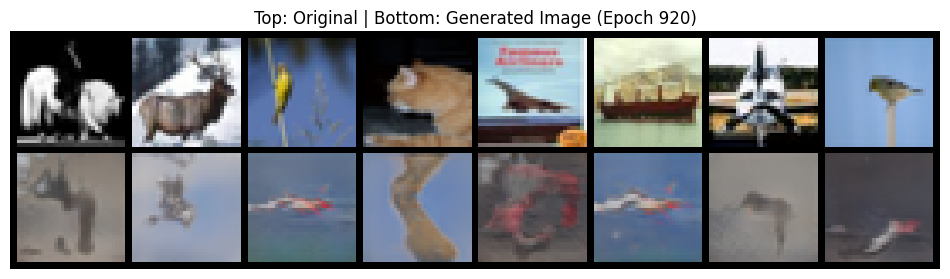

Epoch-921/1000: 100%|██████████| 782/782 [00:15<00:00, 50.87it/s, GenLoss=2.52, DisLoss=3.64, DisSteps=1]  


Generator Loss: 1.7853726775140104
Discriminator Loss: 0.48117934218834124


Epoch-922/1000: 100%|██████████| 782/782 [00:14<00:00, 54.77it/s, GenLoss=4.31, DisLoss=0.48, DisSteps=1]  


Generator Loss: 1.768919842589237
Discriminator Loss: 0.47806704029097885


Epoch-923/1000: 100%|██████████| 782/782 [00:14<00:00, 55.16it/s, GenLoss=6.3, DisLoss=1.71, DisSteps=1]   


Generator Loss: 1.6914010864237081
Discriminator Loss: 0.5064324879128


Epoch-924/1000: 100%|██████████| 782/782 [00:14<00:00, 54.55it/s, GenLoss=4.32, DisLoss=1.1, DisSteps=1]   


Generator Loss: 1.771771217055638
Discriminator Loss: 0.47653938309692057


Epoch-925/1000: 100%|██████████| 782/782 [00:19<00:00, 40.56it/s, GenLoss=4.19, DisLoss=1.97, DisSteps=1]  


Generator Loss: 1.8303480857168621
Discriminator Loss: 0.4629548297018346


Epoch-926/1000: 100%|██████████| 782/782 [00:33<00:00, 23.17it/s, GenLoss=6.88, DisLoss=1.11, DisSteps=1]  


Generator Loss: 1.9781524852261214
Discriminator Loss: 0.4375335524797135


Epoch-927/1000: 100%|██████████| 782/782 [00:21<00:00, 35.56it/s, GenLoss=6.71, DisLoss=1.49, DisSteps=1]  


Generator Loss: 2.077119590223903
Discriminator Loss: 0.419645109063829


Epoch-928/1000: 100%|██████████| 782/782 [00:25<00:00, 30.28it/s, GenLoss=8.96, DisLoss=2.74, DisSteps=1]  


Generator Loss: 1.9327142737481906
Discriminator Loss: 0.4330252678040653


Epoch-929/1000: 100%|██████████| 782/782 [00:17<00:00, 45.06it/s, GenLoss=6.5, DisLoss=1.29, DisSteps=1]   


Generator Loss: 1.930194735870032
Discriminator Loss: 0.4594552328671946


Epoch-930/1000: 100%|██████████| 782/782 [00:19<00:00, 40.60it/s, GenLoss=6.01, DisLoss=1.88, DisSteps=1]  


Generator Loss: 1.820998762574647
Discriminator Loss: 0.4635440005213403


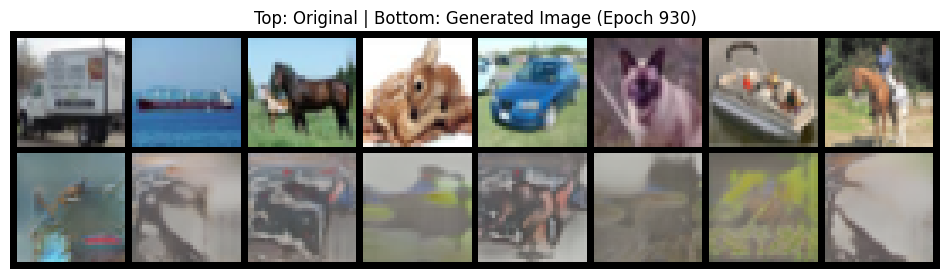

Epoch-931/1000: 100%|██████████| 782/782 [00:15<00:00, 50.16it/s, GenLoss=3.9, DisLoss=0.653, DisSteps=1]  


Generator Loss: 1.8059594635958867
Discriminator Loss: 0.4957338846514902


Epoch-932/1000: 100%|██████████| 782/782 [00:15<00:00, 50.57it/s, GenLoss=7.26, DisLoss=0.952, DisSteps=1] 


Generator Loss: 1.6883253864848706
Discriminator Loss: 0.4909313794825693


Epoch-933/1000: 100%|██████████| 782/782 [00:16<00:00, 46.18it/s, GenLoss=3.17, DisLoss=1.9, DisSteps=1]   


Generator Loss: 1.8690590618364036
Discriminator Loss: 0.4782172452344004


Epoch-934/1000: 100%|██████████| 782/782 [00:15<00:00, 51.60it/s, GenLoss=1.96, DisLoss=0.575, DisSteps=1] 


Generator Loss: 1.737736266439833
Discriminator Loss: 0.5127609249042429


Epoch-935/1000: 100%|██████████| 782/782 [00:15<00:00, 51.88it/s, GenLoss=4.06, DisLoss=1.18, DisSteps=1]  


Generator Loss: 1.8119404846445069
Discriminator Loss: 0.4787846532128656


Epoch-936/1000: 100%|██████████| 782/782 [00:14<00:00, 54.42it/s, GenLoss=6.36, DisLoss=1.61, DisSteps=1]  


Generator Loss: 1.7744193815666696
Discriminator Loss: 0.49297312384142594


Epoch-937/1000: 100%|██████████| 782/782 [00:17<00:00, 43.59it/s, GenLoss=2.52, DisLoss=0.537, DisSteps=1] 


Generator Loss: 1.801406206377327
Discriminator Loss: 0.48062520439896134


Epoch-938/1000: 100%|██████████| 782/782 [00:14<00:00, 55.61it/s, GenLoss=2.6, DisLoss=1.16, DisSteps=1]   


Generator Loss: 1.648646068161406
Discriminator Loss: 0.520979309459324


Epoch-939/1000: 100%|██████████| 782/782 [00:14<00:00, 54.63it/s, GenLoss=9.08, DisLoss=2.2, DisSteps=1]   


Generator Loss: 1.7295801276746003
Discriminator Loss: 0.5232344057287097


Epoch-940/1000: 100%|██████████| 782/782 [00:23<00:00, 32.92it/s, GenLoss=5.8, DisLoss=1.14, DisSteps=1]   


Generator Loss: 1.881641925448347
Discriminator Loss: 0.450443128700299


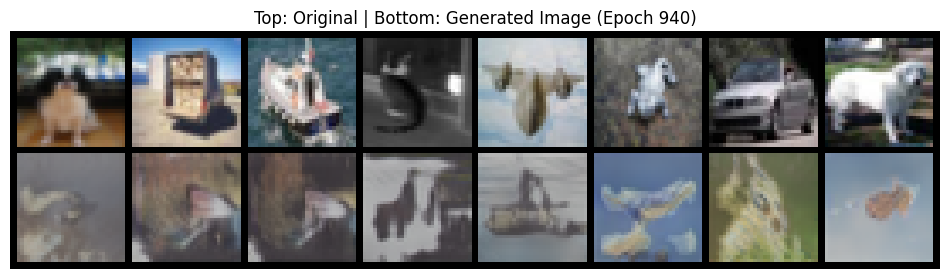

Epoch-941/1000: 100%|██████████| 782/782 [00:20<00:00, 38.66it/s, GenLoss=2.38, DisLoss=2.14, DisSteps=1]  


Generator Loss: 1.8971673683894565
Discriminator Loss: 0.45020219140574147


Epoch-942/1000: 100%|██████████| 782/782 [00:24<00:00, 31.59it/s, GenLoss=4.7, DisLoss=1.17, DisSteps=1]   


Generator Loss: 1.7560364580748942
Discriminator Loss: 0.48885653486184755


Epoch-943/1000: 100%|██████████| 782/782 [00:18<00:00, 42.45it/s, GenLoss=2.47, DisLoss=1.02, DisSteps=1]  


Generator Loss: 1.7282744607962002
Discriminator Loss: 0.48700031874429844


Epoch-944/1000: 100%|██████████| 782/782 [00:22<00:00, 34.95it/s, GenLoss=3.62, DisLoss=2.44, DisSteps=1]  


Generator Loss: 1.710970111515211
Discriminator Loss: 0.48111753741188734


Epoch-945/1000: 100%|██████████| 782/782 [00:30<00:00, 25.62it/s, GenLoss=2.58, DisLoss=0.65, DisSteps=1]  


Generator Loss: 1.70803348060764
Discriminator Loss: 0.5046649559798753


Epoch-946/1000: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s, GenLoss=6.58, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.7471033321012317
Discriminator Loss: 0.4879386428257693


Epoch-947/1000: 100%|██████████| 782/782 [00:13<00:00, 56.48it/s, GenLoss=6.21, DisLoss=0.849, DisSteps=1] 


Generator Loss: 1.7438611007102616
Discriminator Loss: 0.4990413675413412


Epoch-948/1000: 100%|██████████| 782/782 [00:15<00:00, 52.01it/s, GenLoss=4.31, DisLoss=0.678, DisSteps=1] 


Generator Loss: 1.7170369265329501
Discriminator Loss: 0.4844690908480178


Epoch-949/1000: 100%|██████████| 782/782 [00:14<00:00, 55.41it/s, GenLoss=3.93, DisLoss=1.19, DisSteps=1]  


Generator Loss: 1.8515768691401957
Discriminator Loss: 0.47687762466919087


Epoch-950/1000: 100%|██████████| 782/782 [00:17<00:00, 45.41it/s, GenLoss=2.11, DisLoss=2.06, DisSteps=1]  


Generator Loss: 1.664955969852255
Discriminator Loss: 0.4984471562992581


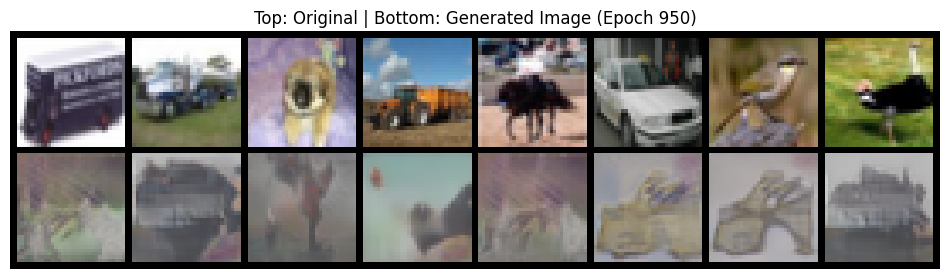

Epoch-951/1000: 100%|██████████| 782/782 [00:14<00:00, 53.35it/s, GenLoss=3.62, DisLoss=1.41, DisSteps=1]  


Generator Loss: 1.630849235388629
Discriminator Loss: 0.5246116291645848


Epoch-952/1000: 100%|██████████| 782/782 [00:19<00:00, 41.03it/s, GenLoss=4.08, DisLoss=0.575, DisSteps=1] 


Generator Loss: 1.5981903756061173
Discriminator Loss: 0.527615920928738


Epoch-953/1000: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s, GenLoss=1.8, DisLoss=0.427, DisSteps=1]  


Generator Loss: 1.6318355142460454
Discriminator Loss: 0.5256332139606061


Epoch-954/1000: 100%|██████████| 782/782 [00:24<00:00, 31.50it/s, GenLoss=3.37, DisLoss=1.69, DisSteps=1]  


Generator Loss: 1.6678342273092026
Discriminator Loss: 0.5280946455038417


Epoch-955/1000: 100%|██████████| 782/782 [00:24<00:00, 31.82it/s, GenLoss=2.43, DisLoss=3.01, DisSteps=1]  


Generator Loss: 1.770332504645028
Discriminator Loss: 0.48515075490907633


Epoch-956/1000: 100%|██████████| 782/782 [00:15<00:00, 50.01it/s, GenLoss=5.84, DisLoss=1.04, DisSteps=1]  


Generator Loss: 1.736427478892419
Discriminator Loss: 0.4426140670505021


Epoch-957/1000: 100%|██████████| 782/782 [00:20<00:00, 37.53it/s, GenLoss=6.01, DisLoss=1.88, DisSteps=1]  


Generator Loss: 1.7583921677468684
Discriminator Loss: 0.49403101948978345


Epoch-958/1000: 100%|██████████| 782/782 [00:14<00:00, 54.44it/s, GenLoss=1.02, DisLoss=0.73, DisSteps=1]  


Generator Loss: 1.7835225081809647
Discriminator Loss: 0.5119962838223523


Epoch-959/1000: 100%|██████████| 782/782 [00:15<00:00, 49.46it/s, GenLoss=6.17, DisLoss=0.877, DisSteps=1] 


Generator Loss: 1.7619251270047234
Discriminator Loss: 0.497911207416021


Epoch-960/1000: 100%|██████████| 782/782 [00:14<00:00, 53.36it/s, GenLoss=5.78, DisLoss=1.24, DisSteps=1]  


Generator Loss: 1.8595837190785371
Discriminator Loss: 0.46435570128052434


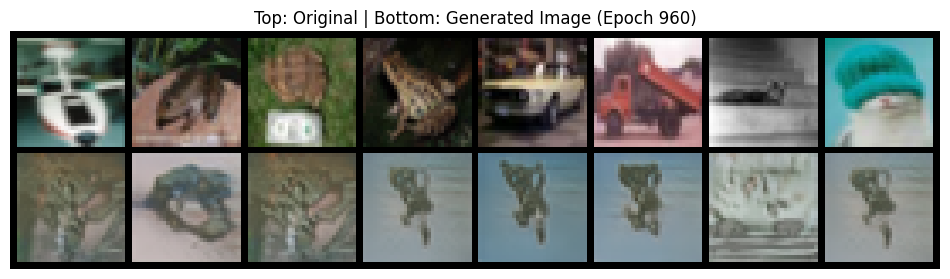

Epoch-961/1000: 100%|██████████| 782/782 [00:14<00:00, 53.26it/s, GenLoss=4.78, DisLoss=0.267, DisSteps=1] 


Generator Loss: 1.9003569434975724
Discriminator Loss: 0.43324509505039593


Epoch-962/1000: 100%|██████████| 782/782 [00:14<00:00, 53.89it/s, GenLoss=6.03, DisLoss=0.261, DisSteps=1] 


Generator Loss: 1.8978296551100737
Discriminator Loss: 0.4407126360651477


Epoch-963/1000: 100%|██████████| 782/782 [00:13<00:00, 56.46it/s, GenLoss=3.43, DisLoss=1.44, DisSteps=1]  


Generator Loss: 1.9823466519565534
Discriminator Loss: 0.44634001671581924


Epoch-964/1000: 100%|██████████| 782/782 [00:14<00:00, 52.30it/s, GenLoss=3.46, DisLoss=0.59, DisSteps=1]  


Generator Loss: 1.9409114254252684
Discriminator Loss: 0.4370494917073213


Epoch-965/1000: 100%|██████████| 782/782 [00:19<00:00, 40.20it/s, GenLoss=4.73, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.8229743454919751
Discriminator Loss: 0.4898377323851866


Epoch-966/1000: 100%|██████████| 782/782 [00:20<00:00, 37.45it/s, GenLoss=4.37, DisLoss=1.58, DisSteps=1]  


Generator Loss: 1.9548904487239125
Discriminator Loss: 0.4164791203215909


Epoch-967/1000: 100%|██████████| 782/782 [00:16<00:00, 46.74it/s, GenLoss=4.71, DisLoss=0.919, DisSteps=1] 


Generator Loss: 2.01631234403309
Discriminator Loss: 0.42768850284235554


Epoch-968/1000: 100%|██████████| 782/782 [00:18<00:00, 43.43it/s, GenLoss=2.2, DisLoss=3.1, DisSteps=1]    


Generator Loss: 1.8989325631076417
Discriminator Loss: 0.4453786050381563


Epoch-969/1000: 100%|██████████| 782/782 [00:19<00:00, 39.63it/s, GenLoss=5.15, DisLoss=1.2, DisSteps=1]   


Generator Loss: 1.8059983467278273
Discriminator Loss: 0.4650736170465989


Epoch-970/1000: 100%|██████████| 782/782 [00:19<00:00, 39.47it/s, GenLoss=5.26, DisLoss=2.18, DisSteps=1]  


Generator Loss: 1.7495413738329086
Discriminator Loss: 0.4965748329792181


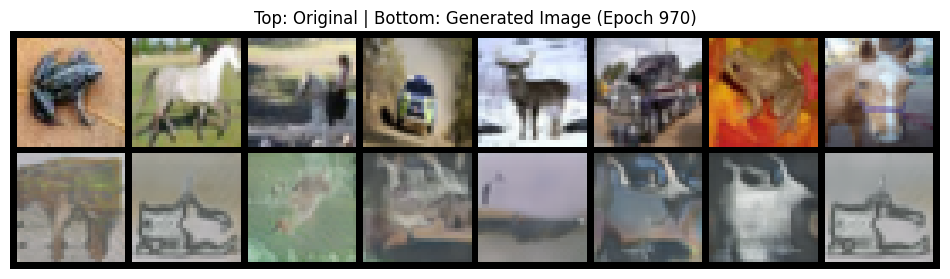

Epoch-971/1000: 100%|██████████| 782/782 [00:15<00:00, 49.85it/s, GenLoss=4.62, DisLoss=0.693, DisSteps=1] 


Generator Loss: 1.6472856322746448
Discriminator Loss: 0.5024908498653671


Epoch-972/1000: 100%|██████████| 782/782 [00:15<00:00, 50.92it/s, GenLoss=2.34, DisLoss=1.53, DisSteps=1]  


Generator Loss: 1.8407244727282268
Discriminator Loss: 0.47896002175862834


Epoch-973/1000: 100%|██████████| 782/782 [00:17<00:00, 45.95it/s, GenLoss=5.22, DisLoss=0.724, DisSteps=1] 


Generator Loss: 1.8417072469163733
Discriminator Loss: 0.4589803106415912


Epoch-974/1000: 100%|██████████| 782/782 [00:14<00:00, 53.04it/s, GenLoss=2.23, DisLoss=0.441, DisSteps=1] 


Generator Loss: 1.848771907389164
Discriminator Loss: 0.45513853163975276


Epoch-975/1000: 100%|██████████| 782/782 [00:15<00:00, 50.07it/s, GenLoss=4.42, DisLoss=3.33, DisSteps=1]  


Generator Loss: 1.9245626647454088
Discriminator Loss: 0.43351232576781834


Epoch-976/1000: 100%|██████████| 782/782 [00:21<00:00, 36.73it/s, GenLoss=6.48, DisLoss=1.96, DisSteps=1]  


Generator Loss: 2.027530109829
Discriminator Loss: 0.4260423182869506


Epoch-977/1000: 100%|██████████| 782/782 [00:14<00:00, 52.84it/s, GenLoss=7.34, DisLoss=2.66, DisSteps=1]  


Generator Loss: 1.9416325714277185
Discriminator Loss: 0.44136402559707233


Epoch-978/1000: 100%|██████████| 782/782 [00:18<00:00, 42.24it/s, GenLoss=4.62, DisLoss=1.34, DisSteps=1]  


Generator Loss: 1.7621691517741478
Discriminator Loss: 0.4900422713259602


Epoch-979/1000: 100%|██████████| 782/782 [00:17<00:00, 43.68it/s, GenLoss=3.53, DisLoss=1.2, DisSteps=1]   


Generator Loss: 1.686222066316763
Discriminator Loss: 0.49752280695359113


Epoch-980/1000: 100%|██████████| 782/782 [00:17<00:00, 45.11it/s, GenLoss=6.69, DisLoss=1.75, DisSteps=1]  


Generator Loss: 1.5895984170153319
Discriminator Loss: 0.5531251814664172


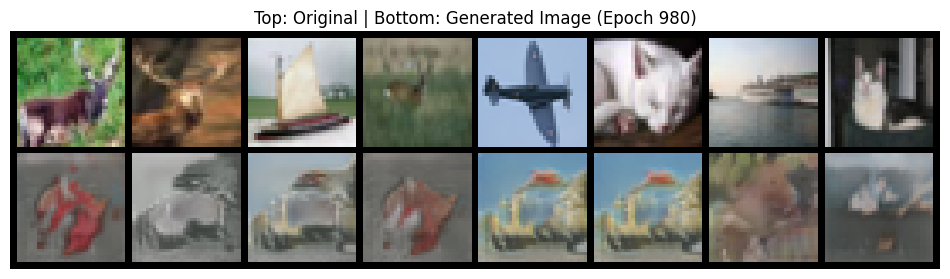

Epoch-981/1000: 100%|██████████| 782/782 [00:16<00:00, 48.15it/s, GenLoss=5.95, DisLoss=2.73, DisSteps=1]  


Generator Loss: 1.7307511630570491
Discriminator Loss: 0.4878031537317864


Epoch-982/1000: 100%|██████████| 782/782 [00:21<00:00, 36.04it/s, GenLoss=11, DisLoss=0.336, DisSteps=1]   


Generator Loss: 1.8940029918690167
Discriminator Loss: 0.4550254767584374


Epoch-983/1000: 100%|██████████| 782/782 [00:17<00:00, 43.81it/s, GenLoss=6.99, DisLoss=1.46, DisSteps=1]  


Generator Loss: 1.966724352763437
Discriminator Loss: 0.43016039063711


Epoch-984/1000: 100%|██████████| 782/782 [00:20<00:00, 39.06it/s, GenLoss=3.43, DisLoss=1.14, DisSteps=1]  


Generator Loss: 1.995628733540435
Discriminator Loss: 0.4239482588094214


Epoch-985/1000: 100%|██████████| 782/782 [00:17<00:00, 43.60it/s, GenLoss=4.62, DisLoss=1.96, DisSteps=1]  


Generator Loss: 1.922387698955853
Discriminator Loss: 0.4264923777917157


Epoch-986/1000: 100%|██████████| 782/782 [00:14<00:00, 52.18it/s, GenLoss=6.24, DisLoss=1.54, DisSteps=1]  


Generator Loss: 1.877573047605012
Discriminator Loss: 0.4551688047397472


Epoch-987/1000: 100%|██████████| 782/782 [00:15<00:00, 51.37it/s, GenLoss=1.56, DisLoss=1.07, DisSteps=1]  


Generator Loss: 1.8657934702265904
Discriminator Loss: 0.4585897143539565


Epoch-988/1000: 100%|██████████| 782/782 [00:14<00:00, 53.38it/s, GenLoss=6.5, DisLoss=0.353, DisSteps=1]  


Generator Loss: 1.9070403669648768
Discriminator Loss: 0.45161487861438787


Epoch-989/1000: 100%|██████████| 782/782 [00:14<00:00, 53.02it/s, GenLoss=5.66, DisLoss=1.43, DisSteps=1]  


Generator Loss: 1.8971710090746965
Discriminator Loss: 0.44831231804302585


Epoch-990/1000: 100%|██████████| 782/782 [00:14<00:00, 52.77it/s, GenLoss=4.85, DisLoss=2.36, DisSteps=1]  


Generator Loss: 1.9889708436511058
Discriminator Loss: 0.44655529971775193


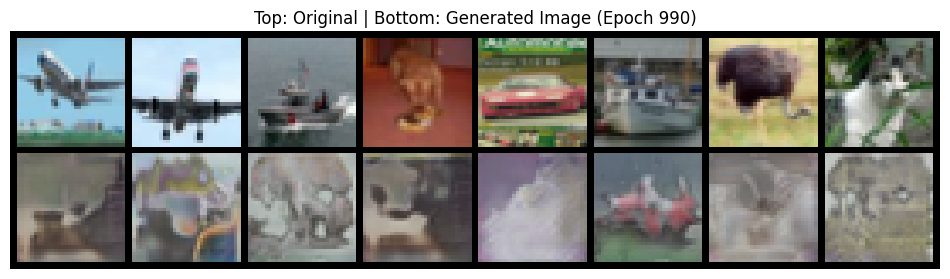

Epoch-991/1000: 100%|██████████| 782/782 [00:17<00:00, 43.61it/s, GenLoss=4.78, DisLoss=0.606, DisSteps=1] 


Generator Loss: 1.8248184570647261
Discriminator Loss: 0.46023662100591317


Epoch-992/1000: 100%|██████████| 782/782 [00:14<00:00, 54.70it/s, GenLoss=2.94, DisLoss=1.89, DisSteps=1]  


Generator Loss: 1.7706975826369526
Discriminator Loss: 0.48205221379580704


Epoch-993/1000: 100%|██████████| 782/782 [00:14<00:00, 53.95it/s, GenLoss=2.93, DisLoss=2.64, DisSteps=1]  


Generator Loss: 1.8045788632939235
Discriminator Loss: 0.48427468210534974


Epoch-994/1000: 100%|██████████| 782/782 [00:16<00:00, 47.95it/s, GenLoss=5.49, DisLoss=0.432, DisSteps=1] 


Generator Loss: 1.8743707582621318
Discriminator Loss: 0.48827936738500816


Epoch-995/1000: 100%|██████████| 782/782 [00:14<00:00, 55.25it/s, GenLoss=8.55, DisLoss=2.33, DisSteps=1]  


Generator Loss: 1.8212045761173035
Discriminator Loss: 0.4669010784772351


Epoch-996/1000: 100%|██████████| 782/782 [00:20<00:00, 38.57it/s, GenLoss=5.06, DisLoss=2.61, DisSteps=1]  


Generator Loss: 1.8404647029574266
Discriminator Loss: 0.45346741624119336


Epoch-997/1000: 100%|██████████| 782/782 [00:17<00:00, 44.12it/s, GenLoss=4.19, DisLoss=2.71, DisSteps=1]  


Generator Loss: 1.8505845176022682
Discriminator Loss: 0.48098683349616694


Epoch-998/1000: 100%|██████████| 782/782 [00:20<00:00, 38.55it/s, GenLoss=6.45, DisLoss=1.33, DisSteps=1]  


Generator Loss: 1.9448766465229756
Discriminator Loss: 0.43478045982244373


Epoch-999/1000: 100%|██████████| 782/782 [00:19<00:00, 39.87it/s, GenLoss=2.07, DisLoss=1.97, DisSteps=1]  


Generator Loss: 1.8753281352693771
Discriminator Loss: 0.42936536766912625


Epoch-1000/1000: 100%|██████████| 782/782 [00:16<00:00, 48.72it/s, GenLoss=5.89, DisLoss=1.56, DisSteps=1]  


Generator Loss: 1.9346408950703224
Discriminator Loss: 0.4605813568739025


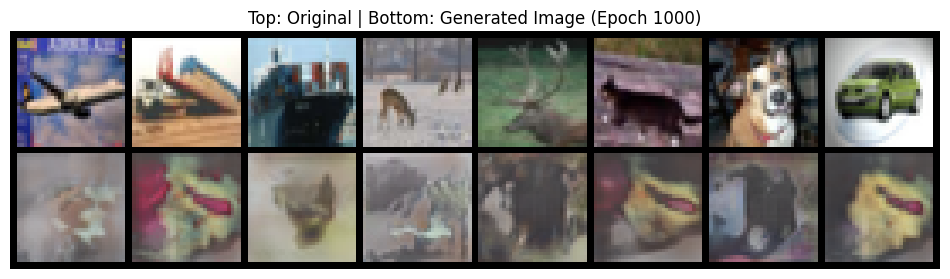

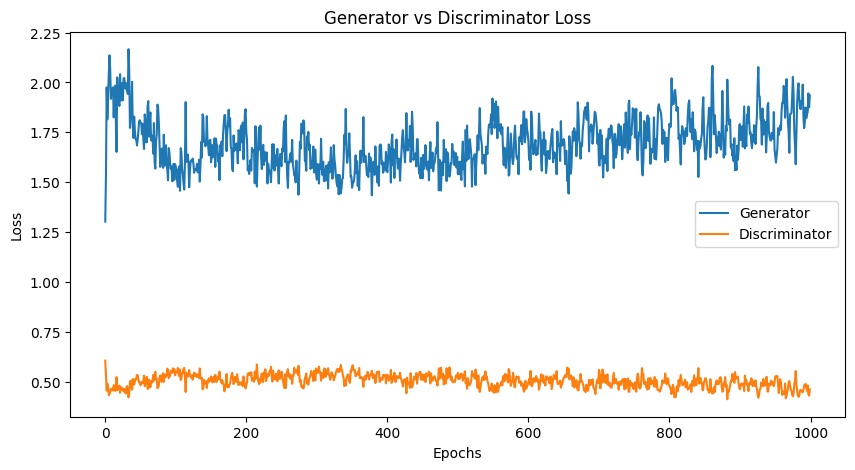

In [6]:
epochs=1000
warmup_epochs = 30
dis_schedule = np.linspace(1, 1, num=warmup_epochs)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
gan_model = GANModel().to(DEVICE)
opt_gen = torch.optim.Adam(gan_model.generator.parameters(), lr=1e-4)
opt_dis = torch.optim.Adam(gan_model.discriminator.parameters(), lr=1e-4)
data = DataLoader(CIFAR(), batch_size=64, shuffle=True, num_workers=4)
l1_loss = nn.L1Loss()

gen_loss_list = []
dis_loss_list = []

for epoch in range(epochs):
    tot_gen_loss = 0
    tot_dis_loss = 0
    gan_model.train()
    tqdm_data = tqdm(data, desc=f"Epoch-{epoch+1}/{epochs}")
    dis_steps = ceil(dis_schedule[epoch]) if epoch+1 < warmup_epochs else 1
    i=0
    for real_img in tqdm_data:
        i+=1
        real_img = real_img.to(DEVICE)
        bs = real_img.size(0)
        if i%dis_steps==0:
            z_dis = torch.randn(bs, 100).to(DEVICE)
            opt_dis.zero_grad()
            dis_loss = gan_model.compute_discriminator_loss(real_img, z_dis)
            dis_loss.backward()
            opt_dis.step()
        else:
            dis_loss = torch.tensor(0.0).to(DEVICE)

        for param in gan_model.discriminator.parameters():
            param.requires_grad = False

        z = torch.randn(bs, 100).to(DEVICE)
        opt_gen.zero_grad()
        gen_loss, fake_img = gan_model.compute_generator_loss(z)
        gen_loss.backward()
        opt_gen.step()

        tot_gen_loss+=gen_loss.detach().cpu().item()
        tot_dis_loss+=dis_loss.detach().cpu().item()
        tqdm_data.set_postfix({
            "GenLoss":gen_loss.detach().cpu().item(),
            "DisLoss":dis_loss.detach().cpu().item(),
            "DisSteps":dis_steps
        })

        for param in gan_model.discriminator.parameters():
            param.requires_grad = True

    
    gen_loss_list.append(tot_gen_loss/len(data))
    dis_loss_list.append(tot_dis_loss*dis_steps/len(data))

    print(f"Generator Loss: {gen_loss_list[-1]}\nDiscriminator Loss: {dis_loss_list[-1]}")

    if (epoch + 1) % 10 == 0:
        torch.save(gan_model.state_dict(), f'/scratch/s25090/gan_outputs/weights/Experiment3/gan_epoch_{epoch+1}.pth')
        gan_model.eval()
        with torch.no_grad():
            gan_image = gan_model(z)
            comparison = torch.cat([real_img[:8], gan_image[:8]], dim=0)
            grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
            plt.figure(figsize=(12, 4))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Top: Original | Bottom: Generated Image (Epoch {epoch+1})')
            plt.savefig(f"/scratch/s25090/gan_outputs/plots/Experiment3/Epoch-{epoch+1}.png")
            plt.show()
            plt.close()

plt.figure(figsize=(10, 5))
plt.title("Generator vs Discriminator Loss")
plt.plot(gen_loss_list, label="Generator")
plt.plot(dis_loss_list, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f"/scratch/s25090/gan_outputs/plots/Experiment_3.png")
plt.legend()
plt.show()